## Roadmap
1. Load biometric long-form extracts and Stage 2 survey metrics.
2. Build reusable join helpers (respondent/form/title alignment, filtering, caching).
3. Implement Part 1 (overall correlations), Part 2 (format-specific slopes), Part 3 (title-level comparisons) for FAC Adaptive Engagement Ã— enjoyment/familiarity/recall.
4. Extend pipeline to additional biometric metrics and export annotated tables/plots.

In [54]:
from pathlib import Path
from typing import Callable, Dict, List, Optional, Sequence, Tuple, cast

import matplotlib.patches as patches
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from IPython.display import Markdown, display
from scipy import stats
from statsmodels.stats.anova import anova_lm

from wbdlib import (
    COLOR_MAP,
    FORM_ORDER,
    PlotDataExporter,
    format_p_value,
    format_value,
    print_long_short_summary,
    significance_label,
)


In [106]:
PROJECT_ROOT = Path.cwd().resolve()
if PROJECT_ROOT.name == "analysis":
    PROJECT_ROOT = PROJECT_ROOT.parent

RESULTS_PATH = PROJECT_ROOT / "results"
DATA_PATH = PROJECT_ROOT / "data"
TASKS_PATH = PROJECT_ROOT / "tasks"
PLOT_EXPORT_ROOT = RESULTS_PATH / "plot_data_exports"
CROSS_PLOT_EXPORTER = PlotDataExporter(
    base_path=PLOT_EXPORT_ROOT,
    notebook_name="analysis_cross",
    static_metadata={
        "notebook": "analysis_cross",
        "source": "analysis_cross.ipynb",
    },
)
THREE_PART_EXPORT_OPTS = {"plot_exporter": CROSS_PLOT_EXPORTER}

print(f"Project root: {PROJECT_ROOT}")
print(f"Results path: {RESULTS_PATH}")
print(f"Plot exports: {PLOT_EXPORT_ROOT / 'analysis_cross'}")


Project root: C:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU
Results path: C:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\results
Plot exports: C:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\results\plot_data_exports\analysis_cross


In [56]:
plt.rcParams['font.family'] = 'Century Gothic'
plt.rcParams['font.sans-serif'] = ['Century Gothic']
plt.rcParams.update({'font.size': 10, 'figure.figsize': (8, 4)})
sns.set_theme(style='whitegrid', rc={'font.family': 'Century Gothic'})

print('Plotting defaults configured.')

Plotting defaults configured.


## Data Sources
Load the long-form biometric extract alongside the Stage 2 survey outputs (enjoyment plus screening familiarity) and the post-study recall survey so downstream helpers can operate on consistent in-memory tables.

In [57]:
BIOMETRIC_PATH = RESULTS_PATH / "uv_biometric_long.csv"
STAGE2_PATH = RESULTS_PATH / "stage2_enjoyment_responses_long.csv"
POST_SURVEY_PATH = RESULTS_PATH / "post_study_survey_responses.csv"

raw_biometric = pd.read_csv(BIOMETRIC_PATH)
raw_stage2 = pd.read_csv(STAGE2_PATH)
raw_post_survey = pd.read_csv(POST_SURVEY_PATH)

print(
    f"Biometric rows: {raw_biometric.shape[0]:,} | Stage 2 rows: {raw_stage2.shape[0]:,} | "
    f"Post-survey rows: {raw_post_survey.shape[0]:,}"
)

Biometric rows: 9,576 | Stage 2 rows: 18,367 | Post-survey rows: 3,910


## Preparation & Merge Helpers
Reusable cleaning utilities keep respondent/form/title keys aligned across biometric, enjoyment, familiarity, and recall datasets.

In [58]:
TARGET_TITLES = ["Mad Max", "The Town", "Abbott Elementary"]
BASE_JOIN_KEYS = ["respondent", "form", "title"]


def _standardize_title(series: pd.Series) -> pd.Series:
    cleaned = (
        series.fillna("")
        .astype(str)
        .str.replace("Abbot Elementary", "Abbott Elementary", regex=False)
        .str.strip()
    )
    return cleaned.replace({"": np.nan})


def _clean_form(series: pd.Series) -> pd.Series:
    cleaned = (
        series.fillna("")
        .astype(str)
        .str.replace(" Form", "", regex=False)
        .str.strip()
        .str.title()
    )
    return cleaned.replace({"": np.nan})


def prepare_biometric_base(frame: pd.DataFrame) -> pd.DataFrame:
    """Extract respondent IDs, normalise labels, and limit to the target titles."""
    base = frame.copy()
    base["respondent"] = (
        base["respondent_id"].str.extract(r"_(\d+)\.csv").iloc[:, 0]
    ).astype("Int64")
    base["title"] = _standardize_title(base["title"])
    base = base.loc[base["title"].isin(TARGET_TITLES)].copy()
    base["form"] = pd.Categorical(
        base["form"].astype(str), categories=list(FORM_ORDER), ordered=True
    )
    base = base.dropna(subset=BASE_JOIN_KEYS)
    return base


def build_enjoyment_metric(
    stage2_df: pd.DataFrame,
    *,
    stat_label: str = "NormalizedCorrected",
    value_col: str = "score_value",
) -> pd.DataFrame:
    """Return enjoyment composites keyed by respondent/form/title."""
    mask = stage2_df["score_stat"].fillna("").str.casefold() == stat_label.casefold()
    subset = stage2_df.loc[mask].copy()
    subset["respondent"] = pd.to_numeric(subset["respondent"], errors="coerce").astype("Int64")
    subset["form"] = _clean_form(subset["stimulus_form"])
    subset["title"] = _standardize_title(subset["stimulus_title"])
    subset = subset.loc[subset["title"].isin(TARGET_TITLES)]
    subset["enjoyment_norm"] = pd.to_numeric(subset[value_col], errors="coerce")
    subset = subset.dropna(subset=BASE_JOIN_KEYS + ["enjoyment_norm"])
    subset = subset.drop_duplicates(BASE_JOIN_KEYS, keep="last")
    return subset[BASE_JOIN_KEYS + ["enjoyment_norm"]]


def build_familiarity_metric(
    stage2_df: pd.DataFrame,
    *,
    score_method: str = "stage2_feature_screening_c1",
    value_col: str = "score_value",
) -> pd.DataFrame:
    """Return Screening Familiarity C1 scores keyed by respondent/form/title."""
    mask = stage2_df["score_method"].fillna("").str.casefold() == score_method.casefold()
    subset = stage2_df.loc[mask].copy()
    subset["respondent"] = pd.to_numeric(subset["respondent"], errors="coerce").astype("Int64")
    subset["form"] = _clean_form(subset["stimulus_form"])
    subset["title"] = _standardize_title(subset["stimulus_title"])
    subset = subset.loc[subset["title"].isin(TARGET_TITLES)]
    subset["familiarity_c1"] = pd.to_numeric(subset[value_col], errors="coerce")
    subset = subset.dropna(subset=BASE_JOIN_KEYS + ["familiarity_c1"])
    subset = subset.drop_duplicates(BASE_JOIN_KEYS, keep="last")
    return subset[BASE_JOIN_KEYS + ["familiarity_c1"]]


def build_recall_metrics(
    post_df: pd.DataFrame,
    *,
    question_codes: Tuple[str, ...] = ("13", "18"),
    value_col: str = "score_value",
) -> pd.DataFrame:
    """Pivot recall scores (key moment vs global) into wide columns per respondent/form/title."""
    codes = tuple(str(code) for code in question_codes)
    subset = post_df.loc[
        post_df["question_code"].astype(str).isin(codes)
    ].copy()
    subset["respondent"] = pd.to_numeric(subset["respondent"], errors="coerce").astype("Int64")
    subset["form"] = _clean_form(subset["stimulus_form"])
    subset["title"] = _standardize_title(subset["stimulus_title"])
    subset = subset.loc[subset["title"].isin(TARGET_TITLES)]
    subset[value_col] = pd.to_numeric(subset[value_col], errors="coerce")
    subset["response_numeric"] = pd.to_numeric(subset["response_numeric"], errors="coerce")
    subset["recall_score"] = subset[value_col]
    subset.loc[subset["recall_score"].isna(), "recall_score"] = subset.loc[
        subset["recall_score"].isna(), "response_numeric"
    ]
    pivot = (
        subset.pivot_table(
            index=BASE_JOIN_KEYS,
            columns="question_code",
            values="recall_score",
            aggfunc="max",
        )
        .rename(columns={"13": "recall_q13", "18": "recall_q18"})
        .reset_index()
    )
    pivot.columns.name = None
    return pivot.dropna(subset=BASE_JOIN_KEYS)


def merge_metric(
    biometric_df: pd.DataFrame,
    metric_df: pd.DataFrame,
    *,
    metric_column: str,
    how: str = "inner",
) -> pd.DataFrame:
    """Join a biometric slice with a prepared metric using the respondent/form/title keys."""
    if metric_column not in metric_df.columns:
        raise KeyError(f"Metric column '{metric_column}' not found.")
    metric_cols = BASE_JOIN_KEYS + [metric_column]
    merged = biometric_df.merge(
        metric_df[metric_cols],
        on=BASE_JOIN_KEYS,
        how=how,
        validate="many_to_one",
    )
    return merged.dropna(subset=[metric_column])


def build_biometric_metric(
    base_df: pd.DataFrame,
    *,
    sensor: str,
    metric: str,
    stats: Tuple[str, ...],
    prefix: Optional[str] = None,
    aggfunc: str = "first",
) -> pd.DataFrame:
    """Pivot biometric stats (AUC, Mean, etc.) into wide columns per respondent/form/title."""
    stats_upper = tuple(stat.upper() for stat in stats)
    sensor_key = sensor.casefold()
    metric_key = metric.casefold()
    sensor_series = base_df["sensor"].fillna("").astype(str).str.casefold()
    metric_series = base_df["metric"].fillna("").astype(str).str.casefold()
    subset = base_df.loc[(sensor_series == sensor_key) & (metric_series == metric_key)].copy()
    if subset.empty:
        raise ValueError(f"No rows found for sensor={sensor} metric={metric}.")

    subset["stat_norm"] = subset["stat"].fillna("").astype(str).str.upper()
    subset = subset.loc[subset["stat_norm"].isin(stats_upper)]
    subset["value_numeric"] = pd.to_numeric(subset["value"], errors="coerce")
    subset = subset.dropna(subset=BASE_JOIN_KEYS + ["value_numeric"])

    pivot = (
        subset.pivot_table(
            index=BASE_JOIN_KEYS,
            columns="stat_norm",
            values="value_numeric",
            aggfunc=aggfunc,
        )
        .reset_index()
        .dropna(subset=BASE_JOIN_KEYS)
    )
    pivot.columns.name = None

    safe_prefix = (
        prefix or f"{sensor}_{metric}"
    ).replace(" ", "_").replace("/", "_").replace("-", "_").lower()
    rename_map = {
        stat: f"{safe_prefix}_{stat.lower()}"
        for stat in stats_upper
        if stat in pivot.columns
    }
    pivot = pivot.rename(columns=rename_map)
    return pivot


def summarise_metric_counts(*frames: pd.DataFrame) -> pd.Series:
    """Return quick respondent/row coverage info for debugging joins."""
    summary = {}
    for idx, frame in enumerate(frames, start=1):
        summary[f"frame_{idx}_rows"] = f"{frame.shape[0]:,}"
        summary[f"frame_{idx}_respondents"] = frame.get("respondent").nunique()
    return pd.Series(summary)


biometric_base = prepare_biometric_base(raw_biometric)
enjoyment_norm = build_enjoyment_metric(raw_stage2)
familiarity_c1 = build_familiarity_metric(raw_stage2)
recall_scores = build_recall_metrics(raw_post_survey)

print(
    "Biometric base rows:", f"{biometric_base.shape[0]:,}",
    "| Enjoyment records:", f"{enjoyment_norm.shape[0]:,}",
    "| Familiarity records:", f"{familiarity_c1.shape[0]:,}",
    "| Recall records:", f"{recall_scores.shape[0]:,}"
)
print("Respondent coverage (biometric):", biometric_base["respondent"].nunique())

Biometric base rows: 9,576 | Enjoyment records: 163 | Familiarity records: 246 | Recall records: 0
Respondent coverage (biometric): 83


### Helper Usage
Use `merge_metric` to bind a biometric subset (for example, FAC Adaptive Engagement AUC rows filtered from `biometric_base`) with any of the prepared outcome tables:
- `enjoyment_norm` for Stage 2 NormalizedCorrected enjoyment scores.
- `familiarity_c1` for Screening Familiarity C1 values.
- `recall_scores` for the paired recall questions (Q13 key moment, Q18 overall).

Each outcome shares the same respondent/form/title keys, so the Part 1â€“3 correlation sections can simply filter `biometric_base`, call `merge_metric`, and proceed with the Hypothesis 3-style statistics/plots.

## Section Vocabulary
- **Section**: Pairing a biometric metric with a single self-report metric (Enjoyment, Familiarity, Recall). Each biometric metric therefore spawns three sections.
- **Part 1**: Overall correlation across all formats/titles (mirrors the Part 1 workflow from the self-report Hypothesis 3 notebook).
- **Part 2**: Format-specific deep dive (Short vs Long lenses).
- **Part 3**: Title-level comparisons.

Every section will eventually host Parts 1â€“3; we begin with the FAC Adaptive Engagement Ã— Enjoyment section below.

### Notebook Scope
Only prepare and analyze the biometric metrics requested for this task:
- FAC Adaptive Engagement AUC
- FAC Contempt AUC
- FAC Joy AUC
- FAC Surprise AUC
- GSR Peaks Per Minute
- ET Blink Rate
- ET Fixation Dispersion Mean
- EEG Distraction AUC
- EEG High Engagement AUC

All subsequent sections should ignore other sensor metrics or redundant statistics (such as FAC Adaptive Mean).

In [ ]:
THREE_PART_SUMMARY: List[Dict[str, object]] = []
_DEFAULT_EXPORTER = object()


def _normalize_export_title(raw_title: str) -> str:
    cleaned = raw_title.replace("\n", " ")
    return " ".join(cleaned.split())


def _export_plot_bundle(
    plot_exporter: Callable[..., object] | None,
    *,
    section_label: str,
    part: str,
    title: str,
    frames: List[Tuple[str, pd.DataFrame]],
    filename_suffix: str | None = None,
    metadata: Dict[str, object] | None = None,
    folder_parts: Sequence[str] | None = None,
) -> None:
    """Write supplied frames to disk if an exporter is configured."""

    if not plot_exporter:
        return

    prepared_frames: List[Tuple[str, pd.DataFrame]] = []
    for sheet_name, frame in frames:
        prepared_frames.append((sheet_name, frame.reset_index(drop=True).copy()))

    normalized_title = _normalize_export_title(title)
    plot_exporter(
        title=normalized_title,
        part=part,
        data_frames=prepared_frames,
        section=section_label,
        filename_suffix=filename_suffix,
        metadata=metadata,
        folder_parts=list(folder_parts) if folder_parts else None,
    )


def _run_three_part_section_impl(
    *,
    metric_label: str,
    metric_df: pd.DataFrame,
    metric_columns: Dict[str, str],
    outcome_df: pd.DataFrame,
    outcome_column: str,
    outcome_label: str,
    section_label: str,
    merge_validate: str = "many_to_one",
    line_color: str = "#5b2c6f",
    plot_exporter: object = _DEFAULT_EXPORTER,
    exporter_section: str | None = None,
    include_title_format: bool = False,
) -> None:
    """Replicate Parts 1-3 (and optionally Part 2.1) for any metric/outcome pairing."""

    include_stat_suffix = len(metric_columns) > 1
    export_section = exporter_section or section_label
    effective_exporter: Callable[..., object] | None
    if plot_exporter is _DEFAULT_EXPORTER:
        default_opts = globals().get("THREE_PART_EXPORT_OPTS", {})
        effective_exporter = cast(
            Callable[..., object] | None, default_opts.get("plot_exporter")
        )
    else:
        effective_exporter = cast(Callable[..., object] | None, plot_exporter)

    def _metric_axis(stat_label: str) -> str:
        return metric_label if not include_stat_suffix else f"{metric_label} ({stat_label})"

    def _append_summary(stat_label: str, part: str, **payload: object) -> None:
        entry: Dict[str, object] = {
            "metric_label": metric_label,
            "metric_stat": stat_label,
            "metric_axis": _metric_axis(stat_label),
            "outcome_label": outcome_label,
            "section_label": section_label,
            "part": part,
        }
        entry.update(payload)
        THREE_PART_SUMMARY.append(entry)

    available_cols = BASE_JOIN_KEYS + [outcome_column]
    metric_base = metric_df.merge(
        outcome_df[available_cols],
        on=BASE_JOIN_KEYS,
        how="inner",
        validate=merge_validate,
    )
    metric_base = metric_base.dropna(
        subset=list(metric_columns.values()) + [outcome_column]
    )

    section_frames: Dict[str, pd.DataFrame] = {}
    for stat_label, value_col in metric_columns.items():
        column_order = [*BASE_JOIN_KEYS, value_col, outcome_column]
        column_order = list(dict.fromkeys(column_order))
        subset = metric_base[column_order].copy()
        subset = subset.rename(
            columns={value_col: "metric_value", outcome_column: "outcome_value"}
        )
        subset = subset.dropna(subset=["metric_value", "outcome_value"])
        if subset.empty:
            print(
                f"Warning: No overlapping rows for {metric_label} {stat_label} vs {outcome_label}."
            )
            continue
        section_frames[stat_label] = subset
        stat_descriptor = (
            metric_label if not include_stat_suffix else f"{metric_label} ({stat_label})"
        )
        print(
            f"{stat_descriptor}: n={subset.shape[0]}, "
            f"respondents={subset['respondent'].nunique()}, "
            f"titles={subset['title'].nunique()}"
        )

    if not section_frames:
        print(f"{section_label}: unable to build analysis frame.")
        return

    # Part 1
    display(Markdown(f"#### Part 1: Overall {section_label}"))
    part1_stats: List[Dict[str, object]] = []
    for stat_label, subset in section_frames.items():
        if subset["metric_value"].nunique() < 2 or subset["outcome_value"].nunique() < 2:
            print(
                f"Skipping {_metric_axis(stat_label)} x {outcome_label}: insufficient variance."
            )
            continue

        r_val, p_val = stats.pearsonr(subset["metric_value"], subset["outcome_value"])
        fig, ax = plt.subplots(figsize=(6.5, 4.3))
        fig.subplots_adjust(bottom=0.3, right=0.96)
        sns.regplot(
            data=subset,
            x="metric_value",
            y="outcome_value",
            scatter_kws={"alpha": 0.45, "s": 30, "color": "#3a3a3a"},
            line_kws={"color": line_color, "linewidth": 2},
            ax=ax,
        )
        ax.set_xlabel(_metric_axis(stat_label))
        ax.set_ylabel(outcome_label)
        ax.set_title(f"Part 1: {_metric_axis(stat_label)} vs {outcome_label}")
        annotation = f"Pearson r = {r_val:.3f}, p = {p_val:.3g}, n = {subset.shape[0]}"
        ax.text(0.0, -0.24, annotation, transform=ax.transAxes, ha="left", va="top", fontsize=9)
        plt.show()

        long_mean = subset.loc[subset["form"] == "Long", "outcome_value"].mean()
        short_mean = subset.loc[subset["form"] == "Short", "outcome_value"].mean()
        payload = {
            "metric_stat": stat_label,
            "pearson_r": r_val,
            "p_value": p_val,
            "n": subset.shape[0],
            "long_mean": long_mean,
            "short_mean": short_mean,
            "metric_mean": subset["metric_value"].mean(),
            "outcome_mean": subset["outcome_value"].mean(),
        }
        part1_stats.append(payload)
        _append_summary(
            stat_label,
            "Part 1",
            subtype="overall",
            group="All",
            pearson_r=r_val,
            p_value=p_val,
            n=subset.shape[0],
            long_mean=long_mean,
            short_mean=short_mean,
            metric_mean=subset["metric_value"].mean(),
            outcome_mean=subset["outcome_value"].mean(),
        )

        if effective_exporter:
            folder_parts = ["part1_overall"]
            if stat_label:
                folder_parts.append(stat_label)
            export_metadata = {
                "metric_label": metric_label,
                "metric_stat": stat_label,
                "outcome_label": outcome_label,
                "pearson_r": float(r_val),
                "p_value": float(p_val),
                "n": int(subset.shape[0]),
                "long_mean": float(long_mean),
                "short_mean": float(short_mean),
            }
            _export_plot_bundle(
                effective_exporter,
                section_label=export_section,
                part="Part 1",
                title=f"Part 1: {_metric_axis(stat_label)} vs {outcome_label}",
                frames=[
                    ("data", subset.copy()),
                    ("summary", pd.DataFrame([payload])),
                ],
                filename_suffix=stat_label if include_stat_suffix else None,
                metadata=export_metadata,
                folder_parts=folder_parts,
            )

    if part1_stats:
        summary = pd.DataFrame(part1_stats)
        summary["p-value"] = summary["p_value"].apply(format_p_value)
        display(
            summary[["metric_stat", "pearson_r", "p-value", "n"]]
            .rename(columns={"metric_stat": "Metric stat", "pearson_r": "Pearson r"})
        )
        for row in part1_stats:
            extra_items = [
                f"Pearson r={row['pearson_r']:.3f}",
                format_p_value(row["p_value"]),
                f"n={row['n']}",
            ]
            print_long_short_summary(
                label=f"Part 1 - {_metric_axis(row['metric_stat'])} x {outcome_label}",
                long_mean=row["long_mean"],
                short_mean=row["short_mean"],
                extra_note=", ".join(extra_items),
            )
    else:
        print("Part 1 skipped: insufficient variance across stats.")
        return

    # Part 2
    display(Markdown(f"#### Part 2: Format-Specific {section_label}"))
    part2_results: Dict[str, Dict[str, object]] = {}
    for stat_label, subset in section_frames.items():
        if subset["form"].nunique() < 2:
            print(f"Skipping {_metric_axis(stat_label)}: need both formats for Part 2.")
            continue

        working = subset.copy()
        working["form"] = pd.Categorical(working["form"], categories=FORM_ORDER, ordered=True)

        format_rows: List[Dict[str, float]] = []
        for form, form_df in working.groupby("form", observed=True):
            valid_df = form_df.dropna(subset=["metric_value", "outcome_value"])
            if (
                valid_df.shape[0] >= 3
                and valid_df["metric_value"].nunique() > 1
                and valid_df["outcome_value"].nunique() > 1
            ):
                r_val, p_val = stats.pearsonr(
                    valid_df["metric_value"], valid_df["outcome_value"]
                )
            else:
                r_val, p_val = np.nan, np.nan
            format_rows.append(
                {
                    "format": form,
                    "n": valid_df.shape[0],
                    "pearson_r": r_val,
                    "p_value": p_val,
                    "metric_mean": valid_df["metric_value"].mean(),
                    "outcome_mean": valid_df["outcome_value"].mean(),
                }
            )

        if not format_rows:
            print(
                f"Skipping {_metric_axis(stat_label)}: insufficient data after format split."
            )
            continue

        for row in format_rows:
            _append_summary(
                stat_label,
                "Part 2",
                subtype="format-correlation",
                group=row["format"],
                pearson_r=row["pearson_r"],
                p_value=row["p_value"],
                n=row["n"],
                metric_mean=row["metric_mean"],
                outcome_mean=row["outcome_mean"],
            )

        model = smf.ols("outcome_value ~ metric_value * C(form)", data=working).fit()
        interaction_term = "metric_value:C(form)[T.Long]"
        baseline_slope = model.params.get("metric_value", np.nan)
        interaction_coef = model.params.get(interaction_term, np.nan)
        long_slope = (
            baseline_slope + interaction_coef
            if np.isfinite(baseline_slope) and np.isfinite(interaction_coef)
            else np.nan
        )
        interaction_p = model.pvalues.get(interaction_term, np.nan)

        slope_details = pd.DataFrame(
            [
                {
                    "format": "Short",
                    "slope": baseline_slope,
                    "comparison": "Reference",
                    "p_value": np.nan,
                },
                {
                    "format": "Long",
                    "slope": long_slope,
                    "comparison": "vs Short",
                    "p_value": interaction_p,
                },
            ]
        )

        for _, slope_row in slope_details.iterrows():
            _append_summary(
                stat_label,
                "Part 2",
                subtype="slope",
                group=slope_row["format"],
                comparison=slope_row["comparison"],
                slope=slope_row["slope"],
                p_value=slope_row["p_value"],
            )

        _append_summary(
            stat_label,
            "Part 2",
            subtype="interaction",
            group="Long vs Short",
            p_value=interaction_p,
        )

        palette = {form: COLOR_MAP.get(form, "#595959") for form in working["form"].cat.categories}
        g = sns.lmplot(
            data=working,
            x="metric_value",
            y="outcome_value",
            hue="form",
            palette=palette,
            height=4.3,
            aspect=1.45,
            scatter_kws={"alpha": 0.65, "s": 35},
            markers=["o", "s"],
        )
        g.set_axis_labels(_metric_axis(stat_label), outcome_label)
        g.fig.subplots_adjust(top=0.85)
        g.fig.suptitle(f"Part 2: {_metric_axis(stat_label)} x Format ({outcome_label})")
        annotation_lines: List[str] = []
        for row in format_rows:
            r_fmt = format_value(row["pearson_r"], decimals=3)
            annotation_lines.append(
                f"{row['format']}: r = {r_fmt}, p = {format_p_value(row['p_value'])}, n = {row['n']}"
            )
        annotation_lines.append(f"Slope difference p = {format_p_value(interaction_p)}")
        g.ax.text(
            0.0,
            -0.24,
            "\n".join(annotation_lines),
            transform=g.ax.transAxes,
            ha="left",
            va="top",
            fontsize=9,
        )

        anova_table = anova_lm(model, typ=2)
        part2_results[stat_label] = {
            "format_summary": pd.DataFrame(format_rows),
            "slope_details": slope_details,
            "anova": anova_table,
            "interaction_p": interaction_p,
            "long_mean": working.loc[working["form"] == "Long", "outcome_value"].mean(),
            "short_mean": working.loc[working["form"] == "Short", "outcome_value"].mean(),
        }

        if effective_exporter:
            folder_parts = ["part2_format"]
            if stat_label:
                folder_parts.append(stat_label)
            export_metadata = {
                "metric_label": metric_label,
                "metric_stat": stat_label,
                "outcome_label": outcome_label,
                "interaction_p": float(interaction_p),
            }
            _export_plot_bundle(
                effective_exporter,
                section_label=export_section,
                part="Part 2",
                title=f"Part 2: {_metric_axis(stat_label)} x Format ({outcome_label})",
                frames=[
                    ("data", working.copy()),
                    ("format_summary", part2_results[stat_label]["format_summary"].copy()),
                    ("slope_details", slope_details.copy()),
                    (
                        "anova",
                        anova_table.reset_index().rename(columns={"index": "term"}),
                    ),
                ],
                filename_suffix=stat_label if include_stat_suffix else None,
                metadata=export_metadata,
                folder_parts=folder_parts,
            )

    if part2_results:
        for stat_label, payload in part2_results.items():
            print(
                f"=== {_metric_axis(stat_label)} - Format Diagnostics ({outcome_label}) ==="
            )
            summary = payload["format_summary"].copy()
            summary["p-value"] = summary["p_value"].apply(format_p_value)
            display(
                summary[["format", "n", "pearson_r", "p-value", "metric_mean", "outcome_mean"]]
                .rename(
                    columns={
                        "metric_mean": "Metric mean",
                        "outcome_mean": f"{outcome_label} mean",
                    }
                )
                .style.format(
                    {
                        "pearson_r": "{:.3f}",
                        "Metric mean": "{:.3f}",
                        f"{outcome_label} mean": "{:.3f}",
                    }
                )
            )

            slope_table = payload["slope_details"].copy()
            slope_table["p-value"] = slope_table["p_value"].apply(format_p_value)
            display(
                slope_table[["format", "comparison", "slope", "p-value"]]
                .rename(columns={"slope": f"Slope ({outcome_label} ~ Metric)"})
                .style.format({f"Slope ({outcome_label} ~ Metric)": "{:.3f}"})
            )

            display(payload["anova"])

            print_long_short_summary(
                label=f"Part 2 - {_metric_axis(stat_label)} x {outcome_label}",
                long_mean=payload["long_mean"],
                short_mean=payload["short_mean"],
                extra_note=f"Interaction p={format_p_value(payload['interaction_p'])}",
            )
    else:
        print("Part 2 skipped: no format-level coverage.")
        return

    if include_title_format:
        display(Markdown(f"#### Part 2.1: Format-Specific per title {section_label}"))
        part21_results: Dict[str, Dict[str, object]] = {}
        for stat_label, subset in section_frames.items():
            if subset["form"].nunique() < 2:
                print(f"Skipping {_metric_axis(stat_label)}: need both formats for Part 2.")
                continue

            for title_name, title_df in subset.groupby("title", observed=True):
                working = title_df.copy()
                working["form"] = pd.Categorical(
                    working["form"], categories=FORM_ORDER, ordered=True
                )

                format_rows: List[Dict[str, float]] = []
                for form, form_df in working.groupby("form", observed=True):
                    valid_df = form_df.dropna(subset=["metric_value", "outcome_value"])
                    if (
                        valid_df.shape[0] >= 3
                        and valid_df["metric_value"].nunique() > 1
                        and valid_df["outcome_value"].nunique() > 1
                    ):
                        r_val, p_val = stats.pearsonr(
                            valid_df["metric_value"], valid_df["outcome_value"]
                        )
                    else:
                        r_val, p_val = np.nan, np.nan
                    format_rows.append(
                        {
                            "format": form,
                            "n": valid_df.shape[0],
                            "pearson_r": r_val,
                            "p_value": p_val,
                            "metric_mean": valid_df["metric_value"].mean(),
                            "outcome_mean": valid_df["outcome_value"].mean(),
                        }
                    )

                if not format_rows:
                    print(
                        f"Skipping {_metric_axis(stat_label)}: insufficient data after format split."
                    )
                    continue

                for row in format_rows:
                    _append_summary(
                        stat_label,
                        "Part 2.1",
                        subtype="format-correlation-title",
                        group=row["format"],
                        pearson_r=row["pearson_r"],
                        p_value=row["p_value"],
                        n=row["n"],
                        metric_mean=row["metric_mean"],
                        outcome_mean=row["outcome_mean"],
                    )

                model = smf.ols("outcome_value ~ metric_value * C(form)", data=working).fit()
                interaction_term = "metric_value:C(form)[T.Long]"
                baseline_slope = model.params.get("metric_value", np.nan)
                interaction_coef = model.params.get(interaction_term, np.nan)
                long_slope = (
                    baseline_slope + interaction_coef
                    if np.isfinite(baseline_slope) and np.isfinite(interaction_coef)
                    else np.nan
                )
                interaction_p = model.pvalues.get(interaction_term, np.nan)

                slope_details = pd.DataFrame(
                    [
                        {
                            "format": "Short",
                            "slope": baseline_slope,
                            "comparison": "Reference",
                            "p_value": np.nan,
                        },
                        {
                            "format": "Long",
                            "slope": long_slope,
                            "comparison": "vs Short",
                            "p_value": interaction_p,
                        },
                    ]
                )

                for _, slope_row in slope_details.iterrows():
                    _append_summary(
                        stat_label,
                        "Part 2.1",
                        subtype="slope",
                        group=slope_row["format"],
                        comparison=slope_row["comparison"],
                        slope=slope_row["slope"],
                        p_value=slope_row["p_value"],
                    )

                _append_summary(
                    stat_label,
                    "Part 2.1",
                    subtype="interaction",
                    group="Long vs Short",
                    p_value=interaction_p,
                )

                palette = {
                    form: COLOR_MAP.get(form, "#595959")
                    for form in working["form"].cat.categories
                }
                g = sns.lmplot(
                    data=working,
                    x="metric_value",
                    y="outcome_value",
                    hue="form",
                    palette=palette,
                    height=4.3,
                    aspect=1.45,
                    scatter_kws={"alpha": 0.65, "s": 35},
                    markers=["o", "s"],
                )
                g.set_axis_labels(_metric_axis(stat_label), outcome_label)
                g.fig.subplots_adjust(top=0.85)
                g.fig.suptitle(
                    f"Part 2.1: {_metric_axis(stat_label)}:{title_name}\\n By Format ({outcome_label})"
                )
                annotation_lines: List[str] = []
                for row in format_rows:
                    r_fmt = format_value(row["pearson_r"], decimals=3)
                    annotation_lines.append(
                        f"{row['format']}: r = {r_fmt}, p = {format_p_value(row['p_value'])}, n = {row['n']}"
                    )
                annotation_lines.append(
                    f"Slope difference p = {format_p_value(interaction_p)}"
                )
                g.ax.text(
                    0.0,
                    -0.24,
                    "\n".join(annotation_lines),
                    transform=g.ax.transAxes,
                    ha="left",
                    va="top",
                    fontsize=9,
                )

                anova_table = anova_lm(model, typ=2)
                part21_results[stat_label] = {
                    "format_summary": pd.DataFrame(format_rows),
                    "slope_details": slope_details,
                    "anova": anova_table,
                    "interaction_p": interaction_p,
                    "long_mean": working.loc[working["form"] == "Long", "outcome_value"].mean(),
                    "short_mean": working.loc[working["form"] == "Short", "outcome_value"].mean(),
                }

                if effective_exporter:
                    folder_parts = ["part2_1_title_format", title_name]
                    export_metadata = {
                        "metric_label": metric_label,
                        "metric_stat": stat_label,
                        "outcome_label": outcome_label,
                        "title": title_name,
                        "interaction_p": float(interaction_p),
                    }
                    _export_plot_bundle(
                        effective_exporter,
                        section_label=export_section,
                        part="Part 2.1",
                        title=f"Part 2.1: {_metric_axis(stat_label)} - {title_name}",
                        frames=[
                            ("data", working.copy()),
                            ("format_summary", part21_results[stat_label]["format_summary"].copy()),
                            ("slope_details", slope_details.copy()),
                            (
                                "anova",
                                anova_table.reset_index().rename(columns={"index": "term"}),
                            ),
                        ],
                        filename_suffix=f"{stat_label}_{title_name}" if stat_label else title_name,
                        metadata=export_metadata,
                        folder_parts=folder_parts,
                    )

        if part21_results:
            for stat_label, payload in part21_results.items():
                print(
                    f"=== {_metric_axis(stat_label)} - Title Diagnostics ({outcome_label}) ==="
                )
                summary = payload["format_summary"].copy()
                summary["p-value"] = summary["p_value"].apply(format_p_value)
                display(
                    summary[["format", "n", "pearson_r", "p-value", "metric_mean", "outcome_mean"]]
                    .rename(
                        columns={
                            "metric_mean": "Metric mean",
                            "outcome_mean": f"{outcome_label} mean",
                        }
                    )
                    .style.format(
                        {
                            "pearson_r": "{:.3f}",
                            "Metric mean": "{:.3f}",
                            f"{outcome_label} mean": "{:.3f}",
                        }
                    )
                )

                slope_table = payload["slope_details"].copy()
                slope_table["p-value"] = slope_table["p_value"].apply(format_p_value)
                display(
                    slope_table[["format", "comparison", "slope", "p-value"]]
                    .rename(columns={"slope": f"Slope ({outcome_label} ~ Metric)"})
                    .style.format({f"Slope ({outcome_label} ~ Metric)": "{:.3f}"})
                )

                display(payload["anova"])

                print_long_short_summary(
                    label=f"Part 2.1 - {_metric_axis(stat_label)} x {outcome_label}",
                    long_mean=payload["long_mean"],
                    short_mean=payload["short_mean"],
                    extra_note=f"Interaction p={format_p_value(payload['interaction_p'])}",
                )
        else:
            print("Part 2.1 skipped: no format-level coverage.")
            return

    # Part 3
    display(Markdown(f"#### Part 3: Title-Level {section_label}"))
    for stat_label, subset in section_frames.items():
        title_corr_records: List[Dict[str, object]] = []
        title_diff_records: List[Dict[str, object]] = []

        for title_name, title_df in subset.groupby("title", observed=True):
            for form_name, form_df in title_df.groupby("form", observed=True):
                form_df = form_df.dropna(subset=["metric_value", "outcome_value"])
                if (
                    form_df.shape[0] < 3
                    or form_df["metric_value"].nunique() < 2
                    or form_df["outcome_value"].nunique() < 2
                ):
                    r_val = np.nan
                    p_val = np.nan
                else:
                    r_val, p_val = stats.pearsonr(
                        form_df["metric_value"], form_df["outcome_value"]
                    )
                title_corr_records.append(
                    {
                        "title": title_name,
                        "form": form_name,
                        "pearson_r": r_val,
                        "p_value": p_val,
                        "n": form_df.shape[0],
                    }
                )
                _append_summary(
                    stat_label,
                    "Part 3",
                    subtype="title-form",
                    title=title_name,
                    group=form_name,
                    pearson_r=r_val,
                    p_value=p_val,
                    n=form_df.shape[0],
                )

            if title_df["form"].nunique() >= 2:
                diff_model = smf.ols("outcome_value ~ metric_value * C(form)", data=title_df).fit()
                interaction_name = "metric_value:C(form)[T.Long]"
                diff_p = diff_model.pvalues.get(interaction_name, np.nan)
            else:
                diff_p = np.nan
            title_diff_records.append({"title": title_name, "delta_p_value": diff_p})
            _append_summary(
                stat_label,
                "Part 3",
                subtype="title-delta",
                title=title_name,
                group="Long vs Short",
                p_value=diff_p,
            )

        title_corr_df = pd.DataFrame(title_corr_records)
        title_diff_df = pd.DataFrame(title_diff_records)

        if title_corr_df.empty:
            print(
                f"Part 3 skipped for {_metric_axis(stat_label)}: insufficient title coverage."
            )
            continue

        title_order = [t for t in TARGET_TITLES if t in title_corr_df["title"].unique()]
        if not title_order:
            title_order = sorted(title_corr_df["title"].unique())
        form_order = ["Short", "Long"]
        bar_width = 0.34
        x_positions = np.arange(len(title_order))
        fig, ax = plt.subplots(figsize=(8.6, 4.6))
        max_bar_height = 0.0
        min_bar_height = 0.0

        for title_idx, title_name in enumerate(title_order):
            title_subset = title_corr_df.loc[title_corr_df["title"] == title_name]
            local_max = 0.0
            local_min = 0.0
            for offset_idx, form_name in enumerate(form_order):
                form_row = title_subset.loc[title_subset["form"] == form_name]
                if form_row.empty:
                    continue
                r_val = form_row["pearson_r"].iloc[0]
                p_val = form_row["p_value"].iloc[0]
                if not np.isfinite(r_val):
                    continue
                bar_x = x_positions[title_idx] + (offset_idx - 0.5) * (bar_width + 0.06)
                color = COLOR_MAP.get(form_name, COLOR_MAP.get("Default", "#1f77b4"))
                ax.bar(bar_x, r_val, width=bar_width, color=color, alpha=0.9)
                local_max = max(local_max, r_val, 0.0)
                local_min = min(local_min, r_val, 0.0)
                annotation_label = significance_label(p_val)
                if annotation_label:
                    text_offset = 0.035 if r_val >= 0 else -0.05
                    va = "bottom" if r_val >= 0 else "top"
                    ax.text(
                        bar_x,
                        r_val + text_offset,
                        annotation_label,
                        ha="center",
                        va=va,
                        fontsize=11,
                        fontweight="bold",
                    )
                bar_text_color = "white" if r_val >= 0.25 else "black"
                text_y = r_val / 2 if r_val != 0 else 0.015
                ax.text(
                    bar_x,
                    text_y,
                    f"r={r_val:.2f}",
                    ha="center",
                    va="center",
                    color=bar_text_color,
                    fontsize=9,
                )
            max_bar_height = max(max_bar_height, local_max)
            min_bar_height = min(min_bar_height, local_min)
            diff_row = title_diff_df.loc[title_diff_df["title"] == title_name]
            if not diff_row.empty:
                diff_p = diff_row["delta_p_value"].iloc[0]
                diff_label = significance_label(diff_p)
                if diff_label:
                    x_center = x_positions[title_idx]
                    half_span = (bar_width + 0.06) / 2
                    bracket_height = local_max + 0.18
                    ax.plot(
                        [
                            x_center - half_span,
                            x_center - half_span,
                            x_center + half_span,
                            x_center + half_span,
                        ],
                        [
                            bracket_height - 0.05,
                            bracket_height,
                            bracket_height,
                            bracket_height - 0.05,
                        ],
                        color="#2f2f2f",
                        linewidth=1.4,
                    )
                    ax.text(
                        x_center,
                        bracket_height + 0.02,
                        diff_label,
                        ha="center",
                        va="bottom",
                        fontsize=11,
                        fontweight="bold",
                    )

        ax.set_xticks(x_positions)
        ax.set_xticklabels(title_order)
        ax.set_ylabel(f"Pearson r ({_metric_axis(stat_label)} vs {outcome_label})")
        ax.set_title(
            f"Part 3: {_metric_axis(stat_label)} Correlations by Title & Format ({outcome_label})"
        )
        lower_bound = min(-0.35, min_bar_height - 0.18)
        upper_bound = max(0.1, max_bar_height + 0.25)
        ax.set_ylim(lower_bound, upper_bound)

        format_handles = [
            patches.Patch(
                color=COLOR_MAP.get(form_name, COLOR_MAP.get("Default", "#1f77b4")),
                label=form_name,
            )
            for form_name in form_order
            if form_name in title_corr_df["form"].unique()
        ]
        sign_handles = [
            plt.Line2D(
                [],
                [],
                color="black",
                marker="",
                linestyle="None",
                markersize=11,
                label="** p <= 0.001",
            ),
            plt.Line2D(
                [],
                [],
                color="black",
                marker="",
                linestyle="None",
                markersize=11,
                label="* 0.001 < p <= 0.05",
            ),
        ]
        legend_handles = format_handles + sign_handles
        ax.legend(
            legend_handles,
            [handle.get_label() for handle in legend_handles],
            loc="upper center",
            bbox_to_anchor=(0.5, -0.18),
            ncol=2,
            frameon=False,
        )
        plt.tight_layout(rect=(0, 0.08, 1, 1))
        plt.show()

        if effective_exporter:
            folder_parts = ["part3_title"]
            if stat_label:
                folder_parts.append(stat_label)
            export_metadata = {
                "metric_label": metric_label,
                "metric_stat": stat_label,
                "outcome_label": outcome_label,
                "title_order": ", ".join(title_order),
                "form_order": ", ".join(form_order),
            }
            _export_plot_bundle(
                effective_exporter,
                section_label=export_section,
                part="Part 3",
                title=f"Part 3: {_metric_axis(stat_label)} Title Correlations",
                frames=[
                    ("title_correlations", title_corr_df.copy()),
                    ("title_deltas", title_diff_df.copy()),
                ],
                filename_suffix=stat_label if include_stat_suffix else None,
                metadata=export_metadata,
                folder_parts=folder_parts,
            )


def run_three_part_section(
    *,
    metric_label: str,
    metric_df: pd.DataFrame,
    metric_columns: Dict[str, str],
    outcome_df: pd.DataFrame,
    outcome_column: str,
    outcome_label: str,
    section_label: str,
    merge_validate: str = "many_to_one",
    line_color: str = "#5b2c6f",
    plot_exporter: object = _DEFAULT_EXPORTER,
    exporter_section: str | None = None,
) -> None:
    """Render Parts 1-3 without per-title format diagnostics."""

    _run_three_part_section_impl(
        metric_label=metric_label,
        metric_df=metric_df,
        metric_columns=metric_columns,
        outcome_df=outcome_df,
        outcome_column=outcome_column,
        outcome_label=outcome_label,
        section_label=section_label,
        merge_validate=merge_validate,
        line_color=line_color,
        plot_exporter=plot_exporter,
        exporter_section=exporter_section,
        include_title_format=False,
    )


def run_three_part_section2(
    *,
    metric_label: str,
    metric_df: pd.DataFrame,
    metric_columns: Dict[str, str],
    outcome_df: pd.DataFrame,
    outcome_column: str,
    outcome_label: str,
    section_label: str,
    merge_validate: str = "many_to_one",
    line_color: str = "#5b2c6f",
    plot_exporter: object = _DEFAULT_EXPORTER,
    exporter_section: str | None = None,
) -> None:
    """Render Parts 1-3 plus Part 2.1 title-level format diagnostics."""

    _run_three_part_section_impl(
        metric_label=metric_label,
        metric_df=metric_df,
        metric_columns=metric_columns,
        outcome_df=outcome_df,
        outcome_column=outcome_column,
        outcome_label=outcome_label,
        section_label=section_label,
        merge_validate=merge_validate,
        line_color=line_color,
        plot_exporter=plot_exporter,
        exporter_section=exporter_section,
        include_title_format=True,
    )


In [ ]:
# Override export helper to keep outputs in a flat folder and rename data headers.
def _export_plot_bundle(
    plot_exporter: Callable[..., object] | None,
    *,
    section_label: str,
    part: str,
    title: str,
    frames: List[Tuple[str, pd.DataFrame]],
    filename_suffix: str | None = None,
    metadata: Dict[str, object] | None = None,
    folder_parts: Sequence[str] | None = None,
) -> None:
    """Write frames to disk with descriptive headers when an exporter is configured."""

    if not plot_exporter:
        return

    meta_payload = metadata or {}
    metric_label = meta_payload.get("metric_label")
    outcome_label = meta_payload.get("outcome_label")

    prepared_frames: List[Tuple[str, pd.DataFrame]] = []
    for sheet_name, frame in frames:
        cleaned = frame.reset_index(drop=True).copy()
        if sheet_name.strip().lower() == "data":
            rename_map: Dict[str, str] = {}
            if isinstance(metric_label, str) and "metric_value" in cleaned.columns:
                rename_map["metric_value"] = metric_label
            if isinstance(outcome_label, str) and "outcome_value" in cleaned.columns:
                rename_map["outcome_value"] = outcome_label
            if rename_map:
                cleaned = cleaned.rename(columns=rename_map)
        prepared_frames.append((sheet_name, cleaned))

    normalized_title = _normalize_export_title(title)
    plot_exporter(
        title=normalized_title,
        part=part,
        data_frames=prepared_frames,
        section=section_label,
        filename_suffix=filename_suffix,
        metadata=meta_payload,
        folder_parts=None,  # Keep everything in the flat root folder.
    )


In [61]:

def run_three_part_section2(
    *,
    metric_label: str,
    metric_df: pd.DataFrame,
    metric_columns: Dict[str, str],
    outcome_df: pd.DataFrame,
    outcome_column: str,
    outcome_label: str,
    section_label: str,
    merge_validate: str = "many_to_one",
    line_color: str = "#5b2c6f",
):
    """Replicate Parts 1-3 for any biometric metric/outcome pairing."""
    include_stat_suffix = len(metric_columns) > 1

    def _metric_axis(stat_label: str) -> str:
        return metric_label if not include_stat_suffix else f"{metric_label} ({stat_label})"

    def _append_summary(stat_label: str, part: str, **payload: object) -> None:
        entry: Dict[str, object] = {
            "metric_label": metric_label,
            "metric_stat": stat_label,
            "metric_axis": _metric_axis(stat_label),
            "outcome_label": outcome_label,
            "section_label": section_label,
            "part": part,
        }
        entry.update(payload)
        THREE_PART_SUMMARY.append(entry)

    available_cols = BASE_JOIN_KEYS + [outcome_column]
    metric_base = metric_df.merge(
        outcome_df[available_cols],
        on=BASE_JOIN_KEYS,
        how="inner",
        validate=merge_validate,
    )
    metric_base = metric_base.dropna(subset=list(metric_columns.values()) + [outcome_column])

    section_frames: Dict[str, pd.DataFrame] = {}
    for stat_label, value_col in metric_columns.items():
        column_order = [*BASE_JOIN_KEYS, value_col, outcome_column]
        column_order = list(dict.fromkeys(column_order))
        subset = metric_base[column_order].copy()
        subset = subset.rename(
            columns={value_col: "metric_value", outcome_column: "outcome_value"}
        )
        subset = subset.dropna(subset=["metric_value", "outcome_value"])
        if subset.empty:
            print(
                f"Warning: No overlapping rows for {metric_label} {stat_label} vs {outcome_label}."
            )
            continue
        section_frames[stat_label] = subset
        stat_descriptor = (
            metric_label if not include_stat_suffix else f"{metric_label} ({stat_label})"
        )
        print(
            f"{stat_descriptor}: n={subset.shape[0]}, "
            f"respondents={subset['respondent'].nunique()}, "
            f"titles={subset['title'].nunique()}"
        )

    if not section_frames:
        print(f"{section_label}: unable to build analysis frame.")
        return

    # Part 1
    display(Markdown(f"#### Part 1: Overall {section_label}"))
    part1_stats: List[Dict[str, object]] = []
    for stat_label, subset in section_frames.items():
        if subset["metric_value"].nunique() < 2 or subset["outcome_value"].nunique() < 2:
            print(
                f"Skipping {_metric_axis(stat_label)} Ã— {outcome_label}: insufficient variance."
            )
            continue

        r_val, p_val = stats.pearsonr(subset["metric_value"], subset["outcome_value"])
        fig, ax = plt.subplots(figsize=(6.5, 4.3))
        fig.subplots_adjust(bottom=0.3, right=0.96)
        sns.regplot(
            data=subset,
            x="metric_value",
            y="outcome_value",
            scatter_kws={"alpha": 0.45, "s": 30, "color": "#3a3a3a"},
            line_kws={"color": line_color, "linewidth": 2},
            ax=ax,
        )
        ax.set_xlabel(_metric_axis(stat_label))
        ax.set_ylabel(outcome_label)
        ax.set_title(
            f"Part 1: {_metric_axis(stat_label)} vs {outcome_label}"
        )
        annotation = f"Pearson r = {r_val:.3f}, p = {p_val:.3g}, n = {subset.shape[0]}"
        ax.text(0.0, -0.24, annotation, transform=ax.transAxes, ha="left", va="top", fontsize=9)
        plt.show()

        long_mean = subset.loc[subset["form"] == "Long", "outcome_value"].mean()
        short_mean = subset.loc[subset["form"] == "Short", "outcome_value"].mean()
        part1_stats.append(
            {
                "metric_stat": stat_label,
                "pearson_r": r_val,
                "p_value": p_val,
                "n": subset.shape[0],
                "long_mean": long_mean,
                "short_mean": short_mean,
                "metric_mean": subset["metric_value"].mean(),
                "outcome_mean": subset["outcome_value"].mean(),
            }
        )
        _append_summary(
            stat_label,
            "Part 1",
            subtype="overall",
            group="All",
            pearson_r=r_val,
            p_value=p_val,
            n=subset.shape[0],
            long_mean=long_mean,
            short_mean=short_mean,
            metric_mean=subset["metric_value"].mean(),
            outcome_mean=subset["outcome_value"].mean(),
        )

    if part1_stats:
        summary = pd.DataFrame(part1_stats)
        summary["p-value"] = summary["p_value"].apply(format_p_value)
        display(
            summary[["metric_stat", "pearson_r", "p-value", "n"]]
            .rename(columns={"metric_stat": "Metric stat", "pearson_r": "Pearson r"})
        )
        for row in part1_stats:
            extra_items = [
                f"Pearson r={row['pearson_r']:.3f}",
                format_p_value(row["p_value"]),
                f"n={row['n']}",
            ]
            print_long_short_summary(
                label=f"Part 1 â€” {_metric_axis(row['metric_stat'])} Ã— {outcome_label}",
                long_mean=row["long_mean"],
                short_mean=row["short_mean"],
                extra_note=", ".join(extra_items),
            )
    else:
        print("Part 1 skipped: insufficient variance across stats.")
        return

    # Part 2
    display(Markdown(f"#### Part 2: Format-Specific {section_label}"))
    part2_results: Dict[str, Dict[str, object]] = {}
    for stat_label, subset in section_frames.items():
        if subset["form"].nunique() < 2:
            print(f"Skipping {_metric_axis(stat_label)}: need both formats for Part 2.")
            continue

        working = subset.copy()
        working["form"] = pd.Categorical(working["form"], categories=FORM_ORDER, ordered=True)

        format_rows: List[Dict[str, float]] = []
        for form, form_df in working.groupby("form", observed=True):
            valid_df = form_df.dropna(subset=["metric_value", "outcome_value"])
            if (
                valid_df.shape[0] >= 3
                and valid_df["metric_value"].nunique() > 1
                and valid_df["outcome_value"].nunique() > 1
            ):
                r_val, p_val = stats.pearsonr(
                    valid_df["metric_value"], valid_df["outcome_value"]
                )
            else:
                r_val, p_val = np.nan, np.nan
            format_rows.append(
                {
                    "format": form,
                    "n": valid_df.shape[0],
                    "pearson_r": r_val,
                    "p_value": p_val,
                    "metric_mean": valid_df["metric_value"].mean(),
                    "outcome_mean": valid_df["outcome_value"].mean(),
                }
            )

        if not format_rows:
            print(
                f"Skipping {_metric_axis(stat_label)}: insufficient data after format split."
            )
            continue

        for row in format_rows:
            _append_summary(
                stat_label,
                "Part 2",
                subtype="format-correlation",
                group=row["format"],
                pearson_r=row["pearson_r"],
                p_value=row["p_value"],
                n=row["n"],
                metric_mean=row["metric_mean"],
                outcome_mean=row["outcome_mean"],
            )

        model = smf.ols(
            "outcome_value ~ metric_value * C(form)", data=working
        ).fit()
        interaction_term = "metric_value:C(form)[T.Long]"
        baseline_slope = model.params.get("metric_value", np.nan)
        interaction_coef = model.params.get(interaction_term, np.nan)
        long_slope = (
            baseline_slope + interaction_coef
            if np.isfinite(baseline_slope) and np.isfinite(interaction_coef)
            else np.nan
        )
        interaction_p = model.pvalues.get(interaction_term, np.nan)

        slope_details = pd.DataFrame(
            [
                {"format": "Short", "slope": baseline_slope, "comparison": "Reference", "p_value": np.nan},
                {"format": "Long", "slope": long_slope, "comparison": "vs Short", "p_value": interaction_p},
            ]
        )

        for _, slope_row in slope_details.iterrows():
            _append_summary(
                stat_label,
                "Part 2",
                subtype="slope",
                group=slope_row["format"],
                comparison=slope_row["comparison"],
                slope=slope_row["slope"],
                p_value=slope_row["p_value"],
            )

        _append_summary(
            stat_label,
            "Part 2",
            subtype="interaction",
            group="Long vs Short",
            p_value=interaction_p,
        )

        palette = {form: COLOR_MAP.get(form, "#595959") for form in working["form"].cat.categories}
        g = sns.lmplot(
            data=working,
            x="metric_value",
            y="outcome_value",
            hue="form",
            palette=palette,
            height=4.3,
            aspect=1.45,
            scatter_kws={"alpha": 0.65, "s": 35},
            markers=["o", "s"],
        )
        g.set_axis_labels(_metric_axis(stat_label), outcome_label)
        g.fig.subplots_adjust(top=0.85)
        g.fig.suptitle(
            f"Part 2: {_metric_axis(stat_label)} Ã— Format ({outcome_label})"
        )
        annotation_lines: List[str] = []
        for row in format_rows:
            r_fmt = format_value(row["pearson_r"], decimals=3)
            annotation_lines.append(
                f"{row['format']}: r = {r_fmt}, p = {format_p_value(row['p_value'])}, n = {row['n']}"
            )
        annotation_lines.append(
            f"Slope difference p = {format_p_value(interaction_p)}"
        )
        g.ax.text(
            0.0,
            -0.24,
            "\n".join(annotation_lines),
            transform=g.ax.transAxes,
            ha="left",
            va="top",
            fontsize=9,
        )

        part2_results[stat_label] = {
            "format_summary": pd.DataFrame(format_rows),
            "slope_details": slope_details,
            "anova": anova_lm(model, typ=2),
            "interaction_p": interaction_p,
            "long_mean": working.loc[working["form"] == "Long", "outcome_value"].mean(),
            "short_mean": working.loc[working["form"] == "Short", "outcome_value"].mean(),
        }

    if part2_results:
        for stat_label, payload in part2_results.items():
            print(
                f"=== {_metric_axis(stat_label)} â€” Format Diagnostics ({outcome_label}) ==="
            )
            summary = payload["format_summary"].copy()
            summary["p-value"] = summary["p_value"].apply(format_p_value)
            display(
                summary[["format", "n", "pearson_r", "p-value", "metric_mean", "outcome_mean"]]
                .rename(columns={
                    "metric_mean": "Metric mean",
                    "outcome_mean": f"{outcome_label} mean",
                })
                .style.format({
                    "pearson_r": "{:.3f}",
                    "Metric mean": "{:.3f}",
                    f"{outcome_label} mean": "{:.3f}",
                })
            )

            slope_table = payload["slope_details"].copy()
            slope_table["p-value"] = slope_table["p_value"].apply(format_p_value)
            display(
                slope_table[["format", "comparison", "slope", "p-value"]]
                .rename(columns={"slope": f"Slope ({outcome_label} ~ Metric)"})
                .style.format({f"Slope ({outcome_label} ~ Metric)": "{:.3f}"})
            )

            display(payload["anova"])

            print_long_short_summary(
                label=f"Part 2 â€” {_metric_axis(stat_label)} Ã— {outcome_label}",
                long_mean=payload["long_mean"],
                short_mean=payload["short_mean"],
                extra_note=f"Interaction p={format_p_value(payload['interaction_p'])}",
            )
    else:
        print("Part 2 skipped: no format-level coverage.")
        return

    # Part 2.1
    display(Markdown(f"#### Part 2.1: Format-Specific per title {section_label}"))
    part2_results: Dict[str, Dict[str, object]] = {}
    for stat_label, subset in section_frames.items():
        if subset["form"].nunique() < 2:
            print(f"Skipping {_metric_axis(stat_label)}: need both formats for Part 2.")
            continue

        for title_name, title_df in subset.groupby("title", observed=True):
            working = title_df.copy()
            working["form"] = pd.Categorical(working["form"], categories=FORM_ORDER, ordered=True)

            format_rows: List[Dict[str, float]] = []
            for form, form_df in working.groupby("form", observed=True):
                valid_df = form_df.dropna(subset=["metric_value", "outcome_value"])
                if (
                    valid_df.shape[0] >= 3
                    and valid_df["metric_value"].nunique() > 1
                    and valid_df["outcome_value"].nunique() > 1
                ):
                    r_val, p_val = stats.pearsonr(
                        valid_df["metric_value"], valid_df["outcome_value"]
                    )
                else:
                    r_val, p_val = np.nan, np.nan
                format_rows.append(
                    {
                        "format": form,
                        "n": valid_df.shape[0],
                        "pearson_r": r_val,
                        "p_value": p_val,
                        "metric_mean": valid_df["metric_value"].mean(),
                        "outcome_mean": valid_df["outcome_value"].mean(),
                    }
                )

            if not format_rows:
                print(
                    f"Skipping {_metric_axis(stat_label)}: insufficient data after format split."
                )
                continue

            for row in format_rows:
                _append_summary(
                    stat_label,
                    "Part 2.1",
                    subtype="format-correlation-title",
                    group=row["format"],
                    pearson_r=row["pearson_r"],
                    p_value=row["p_value"],
                    n=row["n"],
                    metric_mean=row["metric_mean"],
                    outcome_mean=row["outcome_mean"],
                )

            model = smf.ols(
                "outcome_value ~ metric_value * C(form)", data=working
            ).fit()
            interaction_term = "metric_value:C(form)[T.Long]"
            baseline_slope = model.params.get("metric_value", np.nan)
            interaction_coef = model.params.get(interaction_term, np.nan)
            long_slope = (
                baseline_slope + interaction_coef
                if np.isfinite(baseline_slope) and np.isfinite(interaction_coef)
                else np.nan
            )
            interaction_p = model.pvalues.get(interaction_term, np.nan)

            slope_details = pd.DataFrame(
                [
                    {"format": "Short", "slope": baseline_slope, "comparison": "Reference", "p_value": np.nan},
                    {"format": "Long", "slope": long_slope, "comparison": "vs Short", "p_value": interaction_p},
                ]
            )

            for _, slope_row in slope_details.iterrows():
                _append_summary(
                    stat_label,
                    "Part 2.1",
                    subtype="slope",
                    group=slope_row["format"],
                    comparison=slope_row["comparison"],
                    slope=slope_row["slope"],
                    p_value=slope_row["p_value"],
                )

            _append_summary(
                stat_label,
                "Part 2.1",
                subtype="interaction",
                group="Long vs Short",
                p_value=interaction_p,
            )

            palette = {form: COLOR_MAP.get(form, "#595959") for form in working["form"].cat.categories}
            g = sns.lmplot(
                data=working,
                x="metric_value",
                y="outcome_value",
                hue="form",
                palette=palette,
                height=4.3,
                aspect=1.45,
                scatter_kws={"alpha": 0.65, "s": 35},
                markers=["o", "s"],
            )
            g.set_axis_labels(_metric_axis(stat_label), outcome_label)
            g.fig.subplots_adjust(top=0.85)
            g.fig.suptitle(
                f"Part 2.1: {_metric_axis(stat_label)}:{title_name}\n By Format ({outcome_label})"
            )
            annotation_lines: List[str] = []
            for row in format_rows:
                r_fmt = format_value(row["pearson_r"], decimals=3)
                annotation_lines.append(
                    f"{row['format']}: r = {r_fmt}, p = {format_p_value(row['p_value'])}, n = {row['n']}"
                )
            annotation_lines.append(
                f"Slope difference p = {format_p_value(interaction_p)}"
            )
            g.ax.text(
                0.0,
                -0.24,
                "\n".join(annotation_lines),
                transform=g.ax.transAxes,
                ha="left",
                va="top",
                fontsize=9,
            )

            part2_results[stat_label] = {
                "format_summary": pd.DataFrame(format_rows),
                "slope_details": slope_details,
                "anova": anova_lm(model, typ=2),
                "interaction_p": interaction_p,
                "long_mean": working.loc[working["form"] == "Long", "outcome_value"].mean(),
                "short_mean": working.loc[working["form"] == "Short", "outcome_value"].mean(),
            }

        if part2_results:
            for stat_label, payload in part2_results.items():
                print(
                    f"=== {_metric_axis(stat_label)} â€” Format Diagnostics ({outcome_label}) ==="
                )
                summary = payload["format_summary"].copy()
                summary["p-value"] = summary["p_value"].apply(format_p_value)
                display(
                    summary[["format", "n", "pearson_r", "p-value", "metric_mean", "outcome_mean"]]
                    .rename(columns={
                        "metric_mean": "Metric mean",
                        "outcome_mean": f"{outcome_label} mean",
                    })
                    .style.format({
                        "pearson_r": "{:.3f}",
                        "Metric mean": "{:.3f}",
                        f"{outcome_label} mean": "{:.3f}",
                    })
                )

                slope_table = payload["slope_details"].copy()
                slope_table["p-value"] = slope_table["p_value"].apply(format_p_value)
                display(
                    slope_table[["format", "comparison", "slope", "p-value"]]
                    .rename(columns={"slope": f"Slope ({outcome_label} ~ Metric)"})
                    .style.format({f"Slope ({outcome_label} ~ Metric)": "{:.3f}"})
                )

                display(payload["anova"])

                print_long_short_summary(
                    label=f"Part 2.1 â€” {_metric_axis(stat_label)} Ã— {outcome_label}",
                    long_mean=payload["long_mean"],
                    short_mean=payload["short_mean"],
                    extra_note=f"Interaction p={format_p_value(payload['interaction_p'])}",
                )
        else:
            print("Part 2.1 skipped: no format-level coverage.")
            return

    # Part 3
    display(Markdown(f"#### Part 3: Title-Level {section_label}"))
    for stat_label, subset in section_frames.items():
        title_corr_records: List[Dict[str, object]] = []
        title_diff_records: List[Dict[str, object]] = []

        for title_name, title_df in subset.groupby("title", observed=True):
            for form_name, form_df in title_df.groupby("form", observed=True):
                form_df = form_df.dropna(subset=["metric_value", "outcome_value"])
                if (
                    form_df.shape[0] < 3
                    or form_df["metric_value"].nunique() < 2
                    or form_df["outcome_value"].nunique() < 2
                ):
                    r_val = np.nan
                    p_val = np.nan
                else:
                    r_val, p_val = stats.pearsonr(
                        form_df["metric_value"], form_df["outcome_value"]
                    )
                title_corr_records.append(
                    {
                        "title": title_name,
                        "form": form_name,
                        "pearson_r": r_val,
                        "p_value": p_val,
                        "n": form_df.shape[0],
                    }
                )
                _append_summary(
                    stat_label,
                    "Part 3",
                    subtype="title-form",
                    title=title_name,
                    group=form_name,
                    pearson_r=r_val,
                    p_value=p_val,
                    n=form_df.shape[0],
                )

            if title_df["form"].nunique() >= 2:
                diff_model = smf.ols(
                    "outcome_value ~ metric_value * C(form)", data=title_df
                ).fit()
                interaction_name = "metric_value:C(form)[T.Long]"
                diff_p = diff_model.pvalues.get(interaction_name, np.nan)
            else:
                diff_p = np.nan
            title_diff_records.append({"title": title_name, "delta_p_value": diff_p})
            _append_summary(
                stat_label,
                "Part 3",
                subtype="title-delta",
                title=title_name,
                group="Long vs Short",
                p_value=diff_p,
            )

        title_corr_df = pd.DataFrame(title_corr_records)
        title_diff_df = pd.DataFrame(title_diff_records)

        if title_corr_df.empty:
            print(
                f"Part 3 skipped for {_metric_axis(stat_label)}: insufficient title coverage."
            )
            continue

        title_order = [t for t in TARGET_TITLES if t in title_corr_df["title"].unique()]
        if not title_order:
            title_order = sorted(title_corr_df["title"].unique())
        form_order = ["Short", "Long"]
        bar_width = 0.34
        x_positions = np.arange(len(title_order))
        fig, ax = plt.subplots(figsize=(8.6, 4.6))
        max_bar_height = 0.0
        min_bar_height = 0.0

        for title_idx, title_name in enumerate(title_order):
            title_subset = title_corr_df.loc[title_corr_df["title"] == title_name]
            local_max = 0.0
            local_min = 0.0
            for offset_idx, form_name in enumerate(form_order):
                form_row = title_subset.loc[title_subset["form"] == form_name]
                if form_row.empty:
                    continue
                r_val = form_row["pearson_r"].iloc[0]
                p_val = form_row["p_value"].iloc[0]
                if not np.isfinite(r_val):
                    continue
                bar_x = x_positions[title_idx] + (offset_idx - 0.5) * (bar_width + 0.06)
                color = COLOR_MAP.get(form_name, COLOR_MAP.get("Default", "#1f77b4"))
                ax.bar(bar_x, r_val, width=bar_width, color=color, alpha=0.9)
                local_max = max(local_max, r_val, 0.0)
                local_min = min(local_min, r_val, 0.0)
                annotation_label = significance_label(p_val)
                if annotation_label:
                    text_offset = 0.035 if r_val >= 0 else -0.05
                    va = "bottom" if r_val >= 0 else "top"
                    ax.text(
                        bar_x,
                        r_val + text_offset,
                        annotation_label,
                        ha="center",
                        va=va,
                        fontsize=11,
                        fontweight="bold",
                    )
                bar_text_color = "white" if r_val >= 0.25 else "black"
                text_y = r_val / 2 if r_val != 0 else 0.015
                ax.text(
                    bar_x,
                    text_y,
                    f"r={r_val:.2f}",
                    ha="center",
                    va="center",
                    color=bar_text_color,
                    fontsize=9,
                )
            max_bar_height = max(max_bar_height, local_max)
            min_bar_height = min(min_bar_height, local_min)
            diff_row = title_diff_df.loc[title_diff_df["title"] == title_name]
            if not diff_row.empty:
                diff_p = diff_row["delta_p_value"].iloc[0]
                diff_label = significance_label(diff_p)
                if diff_label:
                    x_center = x_positions[title_idx]
                    half_span = (bar_width + 0.06) / 2
                    bracket_height = local_max + 0.18
                    ax.plot(
                        [
                            x_center - half_span,
                            x_center - half_span,
                            x_center + half_span,
                            x_center + half_span,
                        ],
                        [
                            bracket_height - 0.05,
                            bracket_height,
                            bracket_height,
                            bracket_height - 0.05,
                        ],
                        color="#2f2f2f",
                        linewidth=1.4,
                    )
                    ax.text(
                        x_center,
                        bracket_height + 0.02,
                        diff_label,
                        ha="center",
                        va="bottom",
                        fontsize=11,
                        fontweight="bold",
                    )

        ax.set_xticks(x_positions)
        ax.set_xticklabels(title_order)
        ax.set_ylabel(f"Pearson r ({_metric_axis(stat_label)} vs {outcome_label})")
        ax.set_title(
            f"Part 3: {_metric_axis(stat_label)} Correlations by Title & Format ({outcome_label})"
        )
        lower_bound = min(-0.35, min_bar_height - 0.18)
        upper_bound = max(0.1, max_bar_height + 0.25)
        ax.set_ylim(lower_bound, upper_bound)

        format_handles = [
            patches.Patch(
                color=COLOR_MAP.get(form_name, COLOR_MAP.get("Default", "#1f77b4")),
                label=form_name,
            )
            for form_name in form_order
            if form_name in title_corr_df["form"].unique()
        ]
        sign_handles = [
            plt.Line2D([], [], color="black", marker="", linestyle="None", markersize=11, label="** p <= 0.001"),
            plt.Line2D([], [], color="black", marker="", linestyle="None", markersize=11, label="* 0.001 < p <= 0.05"),
        ]
        legend_handles = format_handles + sign_handles
        ax.legend(
            legend_handles,
            [handle.get_label() for handle in legend_handles],
            loc="upper center",
            bbox_to_anchor=(0.5, -0.18),
            ncol=2,
            frameon=False,
        )
        plt.tight_layout(rect=(0, 0.08, 1, 1))
        plt.show()


In [62]:
BIOMETRIC_EXTENSION_SPECS = {
    "fac_contempt": {
        "label": "FAC Contempt AUC",
        "sensor": "FAC",
        "metric": "Contempt",
        "stats": ("AUC",),
        "prefix": "fac_contempt",
        "line_color": "#8b1d3b",
    },
    "fac_joy": {
        "label": "FAC Joy AUC",
        "sensor": "FAC",
        "metric": "Joy",
        "stats": ("AUC",),
        "prefix": "fac_joy",
        "line_color": "#f4a259",
    },
    "fac_surprise": {
        "label": "FAC Surprise AUC",
        "sensor": "FAC",
        "metric": "Surprise",
        "stats": ("AUC",),
        "prefix": "fac_surprise",
        "line_color": "#d35400",
    },
    "gsr_peaks": {
        "label": "GSR Peaks Per Minute",
        "sensor": "GSR",
        "metric": "Peaks",
        "stats": ("PERMINUTE",),
        "prefix": "gsr_peaks",
        "line_color": "#2a9d8f",
    },
    "et_blink": {
        "label": "ET Blink Rate",
        "sensor": "ET",
        "metric": "Blink",
        "stats": ("RATE",),
        "prefix": "et_blink",
        "line_color": "#3d5a80",
    },
    "et_fixation": {
        "label": "ET Fixation Dispersion Mean",
        "sensor": "ET",
        "metric": "FixationDispersion",
        "stats": ("MEAN",),
        "prefix": "et_fixdisp",
        "line_color": "#264653",
    },
    "eeg_distraction": {
        "label": "EEG Distraction AUC",
        "sensor": "EEG",
        "metric": "Distraction",
        "stats": ("AUC",),
        "prefix": "eeg_distraction",
        "line_color": "#6a4c93",
    },
    "eeg_high_engagement": {
        "label": "EEG High Engagement AUC",
        "sensor": "EEG",
        "metric": "HighEngagement",
        "stats": ("AUC",),
        "prefix": "eeg_highengagement",
        "line_color": "#b56576",
    },
}

BIOMETRIC_EXTENSION = {}
for key, spec in BIOMETRIC_EXTENSION_SPECS.items():
    stats_upper = tuple(stat.upper() for stat in spec["stats"])
    metric_columns = {
        stat: f"{spec['prefix']}_{stat.lower()}" for stat in stats_upper
    }
    metric_frame = build_biometric_metric(
        biometric_base,
        sensor=spec["sensor"],
        metric=spec["metric"],
        stats=stats_upper,
        prefix=spec["prefix"],
    )
    BIOMETRIC_EXTENSION[key] = {
        "label": spec["label"],
        "columns": metric_columns,
        "frame": metric_frame,
        "line_color": spec["line_color"],
    }
    print(
        f"{spec['label']}: rows={metric_frame.shape[0]:,} | respondents={metric_frame['respondent'].nunique()}"
    )

FAC Contempt AUC: rows=165 | respondents=83
FAC Joy AUC: rows=165 | respondents=83
FAC Surprise AUC: rows=165 | respondents=83
GSR Peaks Per Minute: rows=119 | respondents=67
ET Blink Rate: rows=139 | respondents=70
ET Fixation Dispersion Mean: rows=165 | respondents=83
EEG Distraction AUC: rows=122 | respondents=62
EEG High Engagement AUC: rows=122 | respondents=62


C:\Users\ashra\AppData\Local\Temp\ipykernel_33400\1305026946.py:159: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  subset.pivot_table(
C:\Users\ashra\AppData\Local\Temp\ipykernel_33400\1305026946.py:159: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  subset.pivot_table(
C:\Users\ashra\AppData\Local\Temp\ipykernel_33400\1305026946.py:159: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  subset.pivot_table(
C:\Users\ashra\AppData\Local\Temp\ipykernel_33400\1305026946.py:159: FutureWarning: The default value o

## Engineered Metric: FAC Emotion Composite
Aggregate the affective AUC channels into a single "emotion energy" trace so it can participate in the same automated three-part workflow as the other biometrics.

In [63]:
FAC_EMOTION_CHANNELS: Tuple[Tuple[str, str], ...] = (
    ("Anger", "fac_emotion_anger_auc"),
    ("Confusion", "fac_emotion_confusion_auc"),
    ("Disgust", "fac_emotion_disgust_auc"),
    ("Fear", "fac_emotion_fear_auc"),
    ("Joy", "fac_emotion_joy_auc"),
    ("Sadness", "fac_emotion_sadness_auc"),
    ("Sentimentality", "fac_emotion_sentimentality_auc"),
    ("Surprise", "fac_emotion_surprise_auc"),
)

fac_emotion_lookup = {metric.casefold(): column for metric, column in FAC_EMOTION_CHANNELS}

fac_emotion_subset = biometric_base.copy()
fac_emotion_subset["sensor_norm"] = fac_emotion_subset["sensor"].fillna("").astype(str).str.casefold()
fac_emotion_subset["metric_norm"] = fac_emotion_subset["metric"].fillna("").astype(str).str.casefold()
fac_emotion_subset["stat_norm"] = fac_emotion_subset["stat"].fillna("").astype(str).str.upper()
fac_emotion_subset = fac_emotion_subset.loc[
    (fac_emotion_subset["sensor_norm"] == "fac")
    & (fac_emotion_subset["metric_norm"].isin(fac_emotion_lookup))
    & (fac_emotion_subset["stat_norm"] == "AUC")
].copy()

if fac_emotion_subset.empty:
    raise ValueError("FAC Emotion composite: no component rows located in biometric extract.")

fac_emotion_subset["value_numeric"] = pd.to_numeric(
    fac_emotion_subset["value"], errors="coerce"
)
fac_emotion_subset = fac_emotion_subset.dropna(
    subset=BASE_JOIN_KEYS + ["value_numeric"]
)

fac_emotion_components = (
    fac_emotion_subset.pivot_table(
        index=BASE_JOIN_KEYS,
        columns="metric_norm",
        values="value_numeric",
        aggfunc="first",
    )
    .rename(columns=fac_emotion_lookup)
    .reset_index()
)

component_cols = list(fac_emotion_lookup.values())
for column in component_cols:
    if column not in fac_emotion_components.columns:
        fac_emotion_components[column] = np.nan

fac_emotion_components["fac_emotion_sum_auc"] = fac_emotion_components[component_cols].sum(
    axis=1,
    min_count=len(component_cols),
)

fac_emotion = fac_emotion_components[
    BASE_JOIN_KEYS + ["fac_emotion_sum_auc"]
].dropna(subset=["fac_emotion_sum_auc"])

BIOMETRIC_EXTENSION["fac_emotion"] = {
    "label": "FAC Emotion Composite (AUC Sum)",
    "columns": {"Composite": "fac_emotion_sum_auc"},
    "frame": fac_emotion,
    "line_color": "#1d84b5",
}

print(
    "FAC Emotion Composite rows:",
    f"{fac_emotion.shape[0]:,}",
    "| Respondents:",
    fac_emotion["respondent"].nunique(),
)

C:\Users\ashra\AppData\Local\Temp\ipykernel_33400\2372268868.py:35: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  fac_emotion_subset.pivot_table(


FAC Emotion Composite rows: 165 | Respondents: 83


## FAC Adaptive Engagement Metric Base
Prepare the Adaptive Engagement AUC statistic once so each of the three sections (Enjoyment, Familiarity, Recall) can reuse the same wide + tidy tables.

In [64]:
FAC_ADAPT_STATS = ("AUC",)
FAC_ADAPT_PREFIX = "fac_adapt"
FAC_ADAPT_COLUMNS = {
    stat.upper(): f"{FAC_ADAPT_PREFIX}_{stat.lower()}" for stat in FAC_ADAPT_STATS
}

fac_adaptive = build_biometric_metric(
    biometric_base,
    sensor="FAC",
    metric="AdaptiveEngagement",
    stats=FAC_ADAPT_STATS,
    prefix=FAC_ADAPT_PREFIX,
)

fac_adaptive_long = (
    fac_adaptive.melt(
        id_vars=BASE_JOIN_KEYS,
        value_vars=list(FAC_ADAPT_COLUMNS.values()),
        var_name="fac_stat",
        value_name="fac_adapt_value",
    )
    .dropna(subset=["fac_adapt_value"])
)
fac_adaptive_long["fac_stat"] = fac_adaptive_long["fac_stat"].map(
    {v: k for k, v in FAC_ADAPT_COLUMNS.items()}
)

print(
    f"FAC Adaptive rows (wide): {fac_adaptive.shape[0]:,} | long rows: {fac_adaptive_long.shape[0]:,}",
    "| Unique respondents:", fac_adaptive["respondent"].nunique(),
)
display(fac_adaptive.head(3))

FAC Adaptive rows (wide): 165 | long rows: 165 | Unique respondents: 83


C:\Users\ashra\AppData\Local\Temp\ipykernel_33400\1305026946.py:159: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  subset.pivot_table(


respondent   form              title  fac_adapt_auc
0           1  Short           The Town       122.3020
1           1   Long  Abbott Elementary        68.2105
2           2  Short  Abbott Elementary         0.9110

## Section: FAC Adaptive Engagement Ã— Enjoyment
Use the shared three-part runner so Adaptive Engagement can mirror the same workflow as the other biometrics without custom code for each part.

### Automated Parts 1â€“3
The helper below merges FAC Adaptive AUC with Stage 2 enjoyment, then renders the overall, format, and title diagnostics in one call.

FAC Adaptive Engagement: n=163, respondents=82, titles=3


#### Part 1: Overall FAC Adaptive Ã— Enjoyment

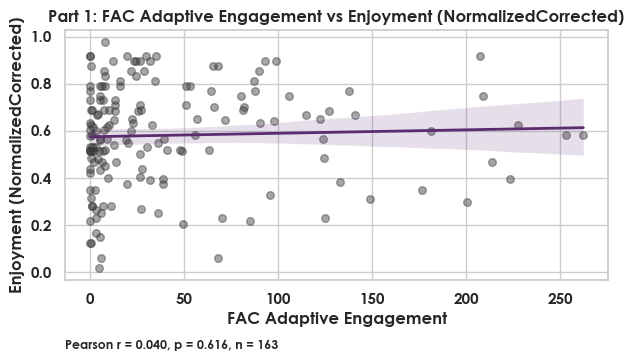

Metric stat  Pearson r  p-value    n
0         AUC   0.039625  p=0.616  163

Part 1 - FAC Adaptive Engagement x Enjoyment (NormalizedCorrected): Long form (68%) showed 20% greater than short form (48%) (Pearson r=0.040, p=0.616, n=163).


#### Part 2: Format-Specific FAC Adaptive Ã— Enjoyment

=== FAC Adaptive Engagement - Format Diagnostics (Enjoyment (NormalizedCorrected)) ===


sum_sq     df          F        PR(>F)
C(form)               1.571547    1.0  42.929008  7.500277e-10
metric_value          0.002980    1.0   0.081399  7.757823e-01
metric_value:C(form)  0.058489    1.0   1.597709  2.080781e-01
Residual              5.820680  159.0        NaN           NaN

Part 2 - FAC Adaptive Engagement x Enjoyment (NormalizedCorrected): Long form (68%) showed 20% greater than short form (48%) (Interaction p=p=0.208).


#### Part 3: Title-Level FAC Adaptive Ã— Enjoyment

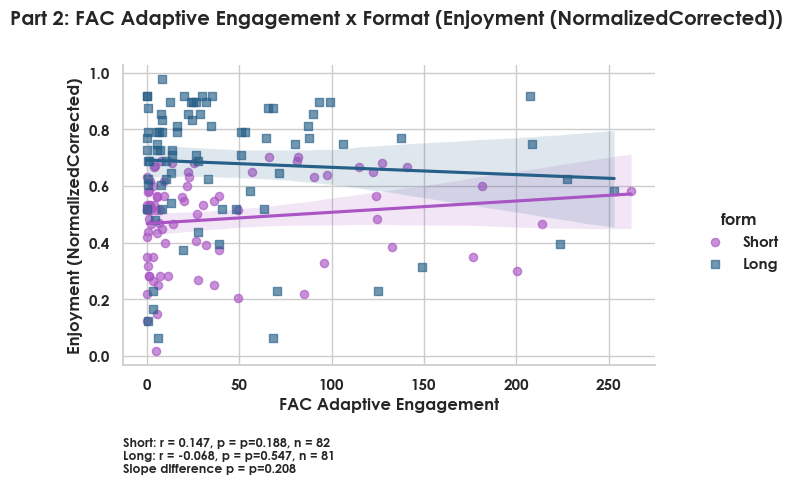

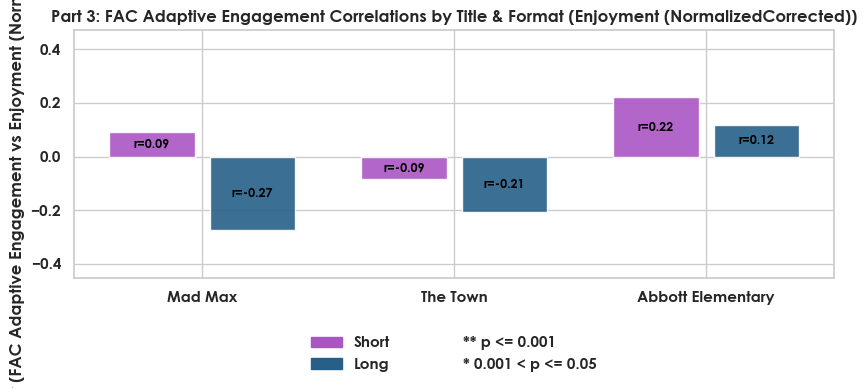

In [65]:
run_three_part_section(
    metric_label="FAC Adaptive Engagement",
    metric_df=fac_adaptive,
    metric_columns=FAC_ADAPT_COLUMNS,
    outcome_df=enjoyment_norm,
    outcome_column="enjoyment_norm",
    outcome_label="Enjoyment (NormalizedCorrected)",
    section_label="FAC Adaptive Ã— Enjoyment",
    merge_validate="many_to_one",
    line_color="#5b2c6f",
)

## Section: FAC Adaptive Engagement Ã— Familiarity
Run the identical helper to correlate Adaptive Engagement with the Screening Familiarity (C1) outcome.

### Automated Parts 1â€“3
Helper merges the FAC Adaptive metric with Screening Familiarity to recreate the three diagnostics.

In [66]:
fac_familiarity_base = (
    fac_adaptive.merge(
        familiarity_c1,
        on=BASE_JOIN_KEYS,
        how="inner",
        validate="many_to_one",
    )
    .dropna(subset=list(FAC_ADAPT_COLUMNS.values()) + ["familiarity_c1"])
)

fac_familiarity_section: Dict[str, pd.DataFrame] = {}
for stat_label, value_col in FAC_ADAPT_COLUMNS.items():
    column_order = [*BASE_JOIN_KEYS, value_col, "familiarity_c1"]
    column_order = list(dict.fromkeys(column_order))
    subset = fac_familiarity_base[column_order].copy()
    subset = subset.rename(
        columns={value_col: "fac_value", "familiarity_c1": "familiarity_value"}
    )
    subset = subset.dropna(subset=["fac_value", "familiarity_value"])
    if subset.empty:
        print(f"Warning: No overlapping rows for FAC Adaptive {stat_label} vs familiarity.")
        continue
    fac_familiarity_section[stat_label] = subset
    print(
        f"{stat_label}: n={subset.shape[0]}, respondents={subset['respondent'].nunique()}, titles={subset['title'].nunique()}"
    )

if not fac_familiarity_section:
    raise ValueError("FAC Adaptive Ã— Familiarity Part 1 cannot run (no data).")

AUC: n=164, respondents=82, titles=3


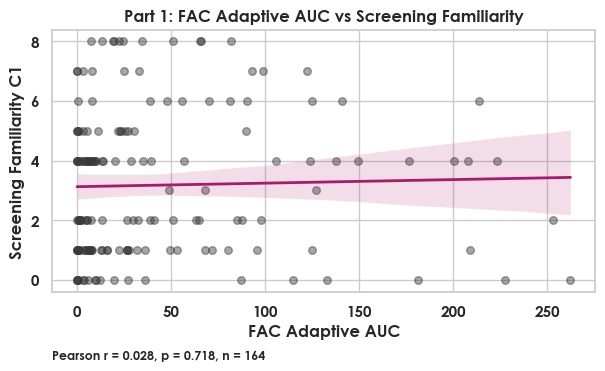

In [67]:
fac_familiarity_part1_stats: List[Dict[str, float]] = []

for stat_label, subset in fac_familiarity_section.items():
    if subset["fac_value"].nunique() < 2 or subset["familiarity_value"].nunique() < 2:
        print(f"Skipping {stat_label}: insufficient variance for correlation analysis.")
        continue

    r_val, p_val = stats.pearsonr(subset["fac_value"], subset["familiarity_value"])
    fig, ax = plt.subplots(figsize=(6.5, 4.3))
    fig.subplots_adjust(bottom=0.27, right=0.96)
    sns.regplot(
        data=subset,
        x="fac_value",
        y="familiarity_value",
        scatter_kws={"alpha": 0.45, "s": 30, "color": "#3a3a3a"},
        line_kws={"color": "#a81b6c", "linewidth": 2},
        ax=ax,
    )
    ax.set_xlabel(f"FAC Adaptive {stat_label}")
    ax.set_ylabel("Screening Familiarity C1")
    ax.set_title(f"Part 1: FAC Adaptive {stat_label} vs Screening Familiarity")
    annotation = f"Pearson r = {r_val:.3f}, p = {p_val:.3g}, n = {subset.shape[0]}"
    ax.text(0.0, -0.22, annotation, transform=ax.transAxes, ha="left", va="top", fontsize=9)
    plt.show()

    fac_familiarity_part1_stats.append(
        {
            "fac_stat": stat_label,
            "pearson_r": r_val,
            "p_value": p_val,
            "n": subset.shape[0],
            "long_mean": subset.loc[subset["form"] == "Long", "familiarity_value"].mean(),
            "short_mean": subset.loc[subset["form"] == "Short", "familiarity_value"].mean(),
        }
    )

if not fac_familiarity_part1_stats:
    raise ValueError("Part 1 plots did not run for the familiarity pairing; check data coverage.")

In [68]:
fac_familiarity_part1_table = pd.DataFrame(fac_familiarity_part1_stats)
if fac_familiarity_part1_table.empty:
    raise ValueError("FAC Adaptive Part 1 familiarity summary table is empty.")

fac_familiarity_part1_table = fac_familiarity_part1_table.assign(
    **{"p-value": fac_familiarity_part1_table["p_value"].apply(format_p_value)}
)
fac_familiarity_part1_table_display = fac_familiarity_part1_table[
    ["fac_stat", "pearson_r", "p-value", "n"]
].rename(columns={"fac_stat": "FAC Adaptive stat", "pearson_r": "Pearson r"})
display(fac_familiarity_part1_table_display)

for row in fac_familiarity_part1_stats:
    extra_items = [
        f"Pearson r={row['pearson_r']:.3f}",
        format_p_value(row["p_value"]),
        f"n={row['n']}",
    ]
    print_long_short_summary(
        label=f"Part 1 (Familiarity) â€” FAC Adaptive {row['fac_stat']}",
        long_mean=row["long_mean"],
        short_mean=row["short_mean"],
        extra_note=", ".join(extra_items),
    )

FAC Adaptive stat  Pearson r  p-value    n
0               AUC   0.028417  p=0.718  164

Part 1 (Familiarity) â€” FAC Adaptive AUC: Long form (327%) showed 18% greater than short form (309%) (Pearson r=0.028, p=0.718, n=164).


### Part 2: Format-specific Adaptive Engagement vs Screening Familiarity
Split the correlations by Short vs Long, then test whether the slopes differ across formats.

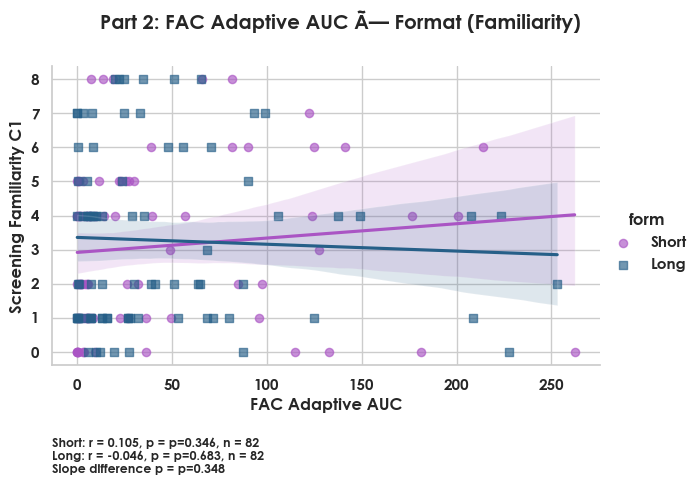

In [69]:
fac_familiarity_part2_results: Dict[str, Dict[str, pd.DataFrame]] = {}

for stat_label, subset in fac_familiarity_section.items():
    if subset["form"].nunique() < 2:
        print(f"Skipping {stat_label}: both Short and Long formats are required for Part 2.")
        continue

    working = subset.copy()
    working["form"] = pd.Categorical(working["form"], categories=FORM_ORDER, ordered=True)

    format_rows: List[Dict[str, float]] = []
    for form, form_df in working.groupby("form", observed=True):
        if form_df.empty:
            continue
        valid_df = form_df.dropna(subset=["fac_value", "familiarity_value"])
        if (
            valid_df.shape[0] >= 3
            and valid_df["fac_value"].nunique() > 1
            and valid_df["familiarity_value"].nunique() > 1
        ):
            r_val, p_val = stats.pearsonr(valid_df["fac_value"], valid_df["familiarity_value"])
        else:
            r_val, p_val = np.nan, np.nan
        format_rows.append(
            {
                "format": form,
                "n": valid_df.shape[0],
                "pearson_r": r_val,
                "p_value": p_val,
                "fac_mean": valid_df["fac_value"].mean(),
                "familiarity_mean": valid_df["familiarity_value"].mean(),
            }
        )

    if not format_rows:
        print(f"Skipping {stat_label}: insufficient data after format split.")
        continue

    model = smf.ols("familiarity_value ~ fac_value * C(form)", data=working).fit()
    interaction_term = "fac_value:C(form)[T.Long]"
    baseline_slope = model.params.get("fac_value", np.nan)
    interaction_coef = model.params.get(interaction_term, np.nan)
    long_slope = (
        baseline_slope + interaction_coef
        if np.isfinite(baseline_slope) and np.isfinite(interaction_coef)
        else np.nan
    )
    interaction_p = model.pvalues.get(interaction_term, np.nan)

    slope_details = pd.DataFrame(
        [
            {
                "format": "Short",
                "slope": baseline_slope,
                "comparison": "Reference",
                "p_value": np.nan,
            },
            {
                "format": "Long",
                "slope": long_slope,
                "comparison": "vs Short",
                "p_value": interaction_p,
            },
        ]
    )

    palette = {form: COLOR_MAP.get(form, "#595959") for form in working["form"].cat.categories}
    g = sns.lmplot(
        data=working,
        x="fac_value",
        y="familiarity_value",
        hue="form",
        palette=palette,
        height=4.3,
        aspect=1.45,
        scatter_kws={"alpha": 0.65, "s": 35},
        markers=["o", "s"],
    )
    g.set_axis_labels(f"FAC Adaptive {stat_label}", "Screening Familiarity C1")
    g.fig.subplots_adjust(top=0.85)
    g.fig.suptitle(f"Part 2: FAC Adaptive {stat_label} Ã— Format (Familiarity)")
    annotation_lines: List[str] = []
    for row in format_rows:
        r_fmt = format_value(row["pearson_r"], decimals=3)
        annotation_lines.append(
            f"{row['format']}: r = {r_fmt}, p = {format_p_value(row['p_value'])}, n = {row['n']}"
        )
    annotation_lines.append(f"Slope difference p = {format_p_value(interaction_p)}")
    g.ax.text(
        0.0,
        -0.24,
        "\n".join(annotation_lines),
        transform=g.ax.transAxes,
        ha="left",
        va="top",
        fontsize=9,
    )

    fac_familiarity_part2_results[stat_label] = {
        "format_summary": pd.DataFrame(format_rows),
        "slope_details": slope_details,
        "anova": anova_lm(model, typ=2),
        "interaction_p": interaction_p,
        "long_mean": working.loc[working["form"] == "Long", "familiarity_value"].mean(),
        "short_mean": working.loc[working["form"] == "Short", "familiarity_value"].mean(),
        "n_long": int(working.loc[working["form"] == "Long"].shape[0]),
        "n_short": int(working.loc[working["form"] == "Short"].shape[0]),
    }


In [70]:
if not fac_familiarity_part2_results:
    print("Part 2 did not yield any format-specific familiarity outputs.")
else:
    for stat_label, payload in fac_familiarity_part2_results.items():
        print(f"=== FAC Adaptive {stat_label} â€” Format Diagnostics (Familiarity) ===")

        summary = payload["format_summary"].copy()
        summary["p-value"] = summary["p_value"].apply(format_p_value)
        display(
            summary[["format", "n", "pearson_r", "p-value", "fac_mean", "familiarity_mean"]]
            .rename(columns={"fac_mean": "FAC mean", "familiarity_mean": "Familiarity mean"})
            .style.format({"pearson_r": "{:.3f}", "FAC mean": "{:.3f}", "Familiarity mean": "{:.3f}"})
        )

        slope_table = payload["slope_details"].copy()
        slope_table["p-value"] = slope_table["p_value"].apply(format_p_value)
        display(
            slope_table[["format", "comparison", "slope", "p-value"]]
            .rename(columns={"slope": "Slope (Familiarity ~ FAC)"})
            .style.format({"Slope (Familiarity ~ FAC)": "{:.3f}"})
        )

        display(payload["anova"])

        print_long_short_summary(
            label=f"Part 2 (Familiarity Format) â€” FAC Adaptive {stat_label}",
            long_mean=payload["long_mean"],
            short_mean=payload["short_mean"],
            extra_note=f"Interaction p={format_p_value(payload['interaction_p'])}",
        )


=== FAC Adaptive AUC â€” Format Diagnostics (Familiarity) ===


sum_sq     df         F    PR(>F)
C(form)              1.295249    1.0  0.218481  0.640835
fac_value            0.695193    1.0  0.117265  0.732470
fac_value:C(form)    5.258558    1.0  0.887009  0.347709
Residual           948.546249  160.0       NaN       NaN

Part 2 (Familiarity Format) â€” FAC Adaptive AUC: Long form (327%) showed 18% greater than short form (309%) (Interaction p=p=0.348).


### Part 3: Title-Level Adaptive Engagement vs Screening Familiarity
Reuse the Cell 65-style title Ã— format bar chart to highlight where familiarity correlations diverge by format.

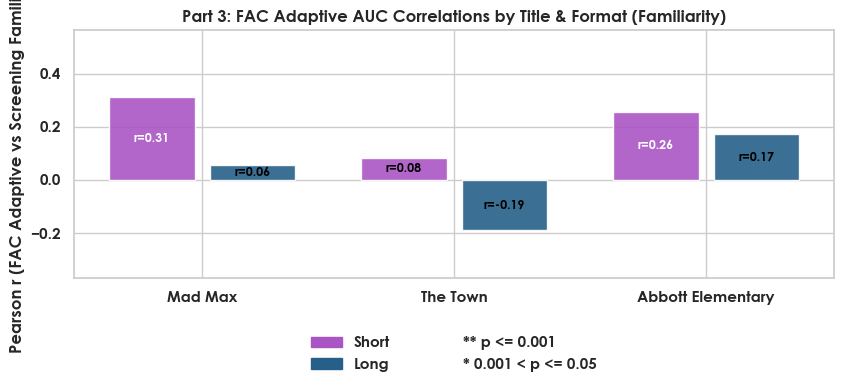

In [71]:
fac_familiarity_part3_results: Dict[str, Dict[str, pd.DataFrame]] = {}

for stat_label, subset in fac_familiarity_section.items():
    title_corr_records: List[Dict[str, object]] = []
    title_diff_records: List[Dict[str, object]] = []

    for title_name, title_df in subset.groupby("title", observed=True):
        for form_name, form_df in title_df.groupby("form", observed=True):
            form_df = form_df.dropna(subset=["fac_value", "familiarity_value"])
            if (
                form_df.shape[0] < 3
                or form_df["fac_value"].nunique() < 2
                or form_df["familiarity_value"].nunique() < 2
            ):
                r_val = np.nan
                p_val = np.nan
            else:
                r_val, p_val = stats.pearsonr(form_df["fac_value"], form_df["familiarity_value"])
            title_corr_records.append(
                {
                    "title": title_name,
                    "form": form_name,
                    "pearson_r": r_val,
                    "p_value": p_val,
                    "n": form_df.shape[0],
                }
            )

        if title_df["form"].nunique() >= 2:
            diff_model = smf.ols("familiarity_value ~ fac_value * C(form)", data=title_df).fit()
            interaction_name = "fac_value:C(form)[T.Long]"
            diff_p = diff_model.pvalues.get(interaction_name, np.nan)
        else:
            diff_p = np.nan
        title_diff_records.append({"title": title_name, "delta_p_value": diff_p})

    title_corr_df = pd.DataFrame(title_corr_records)
    title_diff_df = pd.DataFrame(title_diff_records)

    if title_corr_df.empty:
        print(f"Part 3 skipped for {stat_label}: insufficient title-format coverage.")
        continue

    title_order = [t for t in TARGET_TITLES if t in title_corr_df["title"].unique()]
    if not title_order:
        title_order = sorted(title_corr_df["title"].unique())
    form_order = ["Short", "Long"]
    bar_width = 0.34
    x_positions = np.arange(len(title_order))
    fig, ax = plt.subplots(figsize=(8.6, 4.6))
    max_bar_height = 0.0
    min_bar_height = 0.0

    for title_idx, title_name in enumerate(title_order):
        title_subset = title_corr_df.loc[title_corr_df["title"] == title_name]
        local_max = 0.0
        local_min = 0.0
        for offset_idx, form_name in enumerate(form_order):
            form_row = title_subset.loc[title_subset["form"] == form_name]
            if form_row.empty:
                continue
            r_val = form_row["pearson_r"].iloc[0]
            p_val = form_row["p_value"].iloc[0]
            if not np.isfinite(r_val):
                continue
            bar_x = x_positions[title_idx] + (offset_idx - 0.5) * (bar_width + 0.06)
            color = COLOR_MAP.get(form_name, COLOR_MAP.get("Default", "#1f77b4"))
            ax.bar(bar_x, r_val, width=bar_width, color=color, alpha=0.9)
            local_max = max(local_max, r_val, 0.0)
            local_min = min(local_min, r_val, 0.0)
            annotation_label = significance_label(p_val)
            if annotation_label:
                text_offset = 0.035 if r_val >= 0 else -0.05
                va = "bottom" if r_val >= 0 else "top"
                ax.text(
                    bar_x,
                    r_val + text_offset,
                    annotation_label,
                    ha="center",
                    va=va,
                    fontsize=11,
                    fontweight="bold",
                )
            bar_text_color = "white" if r_val >= 0.25 else "black"
            text_y = r_val / 2 if r_val != 0 else 0.015
            ax.text(bar_x, text_y, f"r={r_val:.2f}", ha="center", va="center", color=bar_text_color, fontsize=9)
        max_bar_height = max(max_bar_height, local_max)
        min_bar_height = min(min_bar_height, local_min)
        diff_row = title_diff_df.loc[title_diff_df["title"] == title_name]
        if not diff_row.empty:
            diff_p = diff_row["delta_p_value"].iloc[0]
            diff_label = significance_label(diff_p)
            if diff_label:
                x_center = x_positions[title_idx]
                half_span = (bar_width + 0.06) / 2
                bracket_height = local_max + 0.18
                ax.plot(
                    [x_center - half_span, x_center - half_span, x_center + half_span, x_center + half_span],
                    [bracket_height - 0.05, bracket_height, bracket_height, bracket_height - 0.05],
                    color="#2f2f2f",
                    linewidth=1.4,
                )
                ax.text(
                    x_center,
                    bracket_height + 0.02,
                    diff_label,
                    ha="center",
                    va="bottom",
                    fontsize=11,
                    fontweight="bold",
                )

    ax.set_xticks(x_positions)
    ax.set_xticklabels(title_order)
    ax.set_ylabel("Pearson r (FAC Adaptive vs Screening Familiarity)")
    ax.set_title(f"Part 3: FAC Adaptive {stat_label} Correlations by Title & Format (Familiarity)")
    lower_bound = min(-0.35, min_bar_height - 0.18)
    upper_bound = max(0.1, max_bar_height + 0.25)
    ax.set_ylim(lower_bound, upper_bound)

    format_handles = [
        patches.Patch(color=COLOR_MAP.get(form_name, COLOR_MAP.get("Default", "#1f77b4")), label=form_name)
        for form_name in form_order
        if form_name in title_corr_df["form"].unique()
    ]
    sign_handles = [
        plt.Line2D([], [], color="black", marker="", linestyle="None", markersize=11, label="** p <= 0.001"),
        plt.Line2D([], [], color="black", marker="", linestyle="None", markersize=11, label="* 0.001 < p <= 0.05"),
    ]
    legend_handles = format_handles + sign_handles
    ax.legend(
        legend_handles,
        [handle.get_label() for handle in legend_handles],
        loc="upper center",
        bbox_to_anchor=(0.5, -0.18),
        ncol=2,
        frameon=False,
    )
    plt.tight_layout(rect=(0, 0.08, 1, 1))
    plt.show()

    fac_familiarity_part3_results[stat_label] = {
        "title_correlations": title_corr_df.sort_values(["title", "form"]).reset_index(drop=True),
        "title_differences": title_diff_df.sort_values("title").reset_index(drop=True),
    }

if not fac_familiarity_part3_results:
    print("Part 3 did not generate any title-level familiarity outputs.")

## Section: FAC Adaptive Engagement Ã— Recall
Use the same workflow but treat the recall composites as a single pooled outcome: responses from questions 13 and 18 share one combined metric so each respondent/form/title supplies up to two observations.

### Part 1: Overall Adaptive Engagement vs Recall (Q13 & Q18 Combined)
Build the merged base once with both recall questions stacked together so the Pearson diagnostic reflects the pooled observation set.

In [72]:
RECALL_COMBINED_LABEL = "Open-Ended Recall (Key-Moment)"
recall_value_col = "score_value"

recall_subset = raw_post_survey.copy()
recall_subset["question_code_clean"] = (
    recall_subset["question_code"].astype(str).str.extract(r"^(\d+)", expand=False)
)
recall_subset = recall_subset.loc[
    recall_subset["question_code_clean"].isin(["13", "18"])
].copy()
recall_subset["respondent"] = pd.to_numeric(
    recall_subset["respondent"], errors="coerce"
).astype("Int64")
recall_subset["form"] = _clean_form(recall_subset["stimulus_form"])
recall_subset["title"] = _standardize_title(recall_subset["stimulus_title"])
recall_subset = recall_subset.loc[recall_subset["title"].isin(TARGET_TITLES)]
recall_subset[recall_value_col] = pd.to_numeric(
    recall_subset[recall_value_col], errors="coerce"
)
recall_subset["response_numeric"] = pd.to_numeric(
    recall_subset["response_numeric"], errors="coerce"
)
recall_subset["recall_score"] = recall_subset[recall_value_col]
recall_subset.loc[recall_subset["recall_score"].isna(), "recall_score"] = recall_subset.loc[
    recall_subset["recall_score"].isna(), "response_numeric"
]
recall_scores_refreshed = (
    recall_subset.pivot_table(
        index=BASE_JOIN_KEYS,
        columns="question_code_clean",
        values="recall_score",
        aggfunc="max",
    )
    .rename(columns={"13": "recall_q13", "18": "recall_q18"})
    .reset_index()
)
recall_scores_refreshed.columns.name = None
recall_scores_refreshed = recall_scores_refreshed.dropna(subset=BASE_JOIN_KEYS)
if recall_scores_refreshed.empty:
    raise ValueError("No recall rows found for question codes 13/18.")
recall_scores = recall_scores_refreshed

recall_long_combined = (
    recall_scores.melt(
        id_vars=BASE_JOIN_KEYS,
        value_vars=[col for col in ["recall_q13", "recall_q18"] if col in recall_scores.columns],
        value_name="recall_value",
    )
    .drop(columns="variable")
    .dropna(subset=["recall_value"])
)
if recall_long_combined.empty:
    raise ValueError("No usable recall values after stacking Q13/Q18.")

fac_recall_base = (
    fac_adaptive.merge(
        recall_long_combined,
        on=BASE_JOIN_KEYS,
        how="inner",
        validate="one_to_many",
    )
    .dropna(subset=list(FAC_ADAPT_COLUMNS.values()) + ["recall_value"])
)

fac_recall_section: Dict[Tuple[str, str], pd.DataFrame] = {}
for stat_label, value_col in FAC_ADAPT_COLUMNS.items():
    column_order = [*BASE_JOIN_KEYS, value_col, "recall_value"]
    column_order = list(dict.fromkeys(column_order))
    subset = fac_recall_base[column_order].copy()
    subset = subset.rename(columns={value_col: "fac_value"})
    subset = subset.dropna(subset=["fac_value", "recall_value"])
    if subset.empty:
        print(
            f"Warning: No overlapping rows for FAC Adaptive {stat_label} vs {RECALL_COMBINED_LABEL}."
        )
        continue
    fac_recall_section[(stat_label, RECALL_COMBINED_LABEL)] = subset
    print(
        f"{stat_label} Ã— {RECALL_COMBINED_LABEL}: n={subset.shape[0]}, respondents={subset['respondent'].nunique()}, titles={subset['title'].nunique()}"
    )

if not fac_recall_section:
    raise ValueError("FAC Adaptive Ã— Recall Part 1 cannot run (no data).")

AUC Ã— Open-Ended Recall (Key-Moment): n=161, respondents=82, titles=3


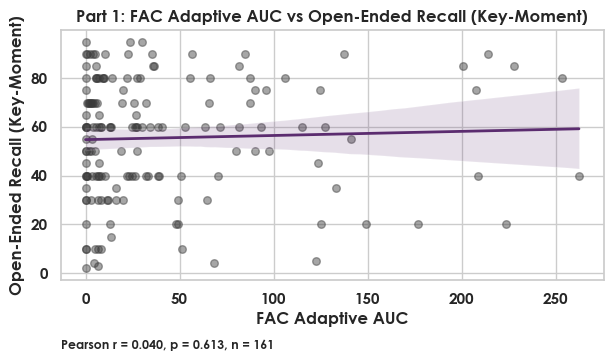

In [73]:
fac_recall_part1_stats: List[Dict[str, object]] = []

for (stat_label, recall_label), subset in fac_recall_section.items():
    if subset["fac_value"].nunique() < 2 or subset["recall_value"].nunique() < 2:
        print(f"Skipping {stat_label} Ã— {recall_label}: insufficient variance.")
        continue

    r_val, p_val = stats.pearsonr(subset["fac_value"], subset["recall_value"])
    fig, ax = plt.subplots(figsize=(6.5, 4.3))
    fig.subplots_adjust(bottom=0.3, right=0.96)
    sns.regplot(
        data=subset,
        x="fac_value",
        y="recall_value",
        scatter_kws={"alpha": 0.45, "s": 30, "color": "#3a3a3a"},
        line_kws={"color": "#5b2c6f", "linewidth": 2},
        ax=ax,
    )
    ax.set_xlabel(f"FAC Adaptive {stat_label}")
    ax.set_ylabel(recall_label)
    ax.set_title(f"Part 1: FAC Adaptive {stat_label} vs {recall_label}")
    annotation = f"Pearson r = {r_val:.3f}, p = {p_val:.3g}, n = {subset.shape[0]}"
    ax.text(0.0, -0.24, annotation, transform=ax.transAxes, ha="left", va="top", fontsize=9)
    plt.show()

    fac_recall_part1_stats.append(
        {
            "fac_stat": stat_label,
            "recall_label": recall_label,
            "pearson_r": r_val,
            "p_value": p_val,
            "n": subset.shape[0],
            "long_mean": subset.loc[subset["form"] == "Long", "recall_value"].mean(),
            "short_mean": subset.loc[subset["form"] == "Short", "recall_value"].mean(),
        }
    )

if not fac_recall_part1_stats:
    raise ValueError("Part 1 plots did not run for the recall pairing; check data coverage.")

In [74]:
fac_recall_part1_table = pd.DataFrame(fac_recall_part1_stats)
if fac_recall_part1_table.empty:
    raise ValueError("FAC Adaptive Part 1 recall summary table is empty.")

fac_recall_part1_table = fac_recall_part1_table.assign(
    **{"p-value": fac_recall_part1_table["p_value"].apply(format_p_value)}
)
fac_recall_part1_table_display = fac_recall_part1_table[
    ["fac_stat", "recall_label", "pearson_r", "p-value", "n"]
].rename(
    columns={
        "fac_stat": "FAC Adaptive stat",
        "recall_label": "Recall metric",
        "pearson_r": "Pearson r",
    }
)
display(fac_recall_part1_table_display)

for row in fac_recall_part1_stats:
    extra_items = [
        f"Pearson r={row['pearson_r']:.3f}",
        format_p_value(row["p_value"]),
        f"n={row['n']}",
    ]
    print_long_short_summary(
        label=f"Part 1 (Recall) â€” FAC Adaptive {row['fac_stat']} Ã— {row['recall_label']}",
        long_mean=row["long_mean"],
        short_mean=row["short_mean"],
        extra_note=", ".join(extra_items),
    )

FAC Adaptive stat                   Recall metric  Pearson r  p-value    n
0               AUC  Open-Ended Recall (Key-Moment)   0.040111  p=0.613  161

Part 1 (Recall) â€” FAC Adaptive AUC Ã— Open-Ended Recall (Key-Moment): Long form (5162%) showed 778% lower than short form (5940%) (Pearson r=0.040, p=0.613, n=161).


### Part 2: Format-specific Adaptive Engagement vs Recall
Split by Short vs Long for each recall metric and test slope differences as before.

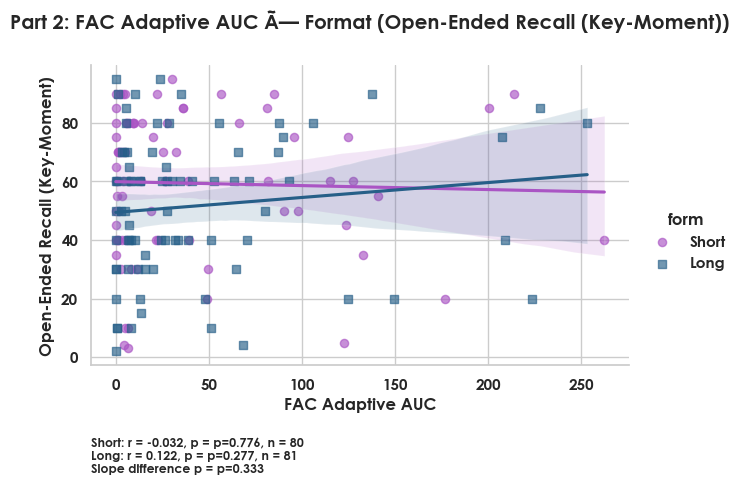

In [75]:
fac_recall_part2_results: Dict[Tuple[str, str], Dict[str, pd.DataFrame]] = {}

for (stat_label, recall_label), subset in fac_recall_section.items():
    if subset["form"].nunique() < 2:
        print(f"Skipping {stat_label} Ã— {recall_label}: need both formats for Part 2.")
        continue

    working = subset.copy()
    working["form"] = pd.Categorical(working["form"], categories=FORM_ORDER, ordered=True)

    format_rows: List[Dict[str, float]] = []
    for form, form_df in working.groupby("form", observed=True):
        if form_df.empty:
            continue
        valid_df = form_df.dropna(subset=["fac_value", "recall_value"])
        if (
            valid_df.shape[0] >= 3
            and valid_df["fac_value"].nunique() > 1
            and valid_df["recall_value"].nunique() > 1
        ):
            r_val, p_val = stats.pearsonr(valid_df["fac_value"], valid_df["recall_value"])
        else:
            r_val, p_val = np.nan, np.nan
        format_rows.append(
            {
                "format": form,
                "n": valid_df.shape[0],
                "pearson_r": r_val,
                "p_value": p_val,
                "fac_mean": valid_df["fac_value"].mean(),
                "recall_mean": valid_df["recall_value"].mean(),
            }
        )

    if not format_rows:
        print(f"Skipping {stat_label} Ã— {recall_label}: insufficient data after split.")
        continue

    model = smf.ols("recall_value ~ fac_value * C(form)", data=working).fit()
    interaction_term = "fac_value:C(form)[T.Long]"
    baseline_slope = model.params.get("fac_value", np.nan)
    interaction_coef = model.params.get(interaction_term, np.nan)
    long_slope = (
        baseline_slope + interaction_coef
        if np.isfinite(baseline_slope) and np.isfinite(interaction_coef)
        else np.nan
    )
    interaction_p = model.pvalues.get(interaction_term, np.nan)

    slope_details = pd.DataFrame(
        [
            {
                "format": "Short",
                "slope": baseline_slope,
                "comparison": "Reference",
                "p_value": np.nan,
            },
            {
                "format": "Long",
                "slope": long_slope,
                "comparison": "vs Short",
                "p_value": interaction_p,
            },
        ]
    )

    palette = {form: COLOR_MAP.get(form, "#595959") for form in working["form"].cat.categories}
    g = sns.lmplot(
        data=working,
        x="fac_value",
        y="recall_value",
        hue="form",
        palette=palette,
        height=4.3,
        aspect=1.45,
        scatter_kws={"alpha": 0.65, "s": 35},
        markers=["o", "s"],
    )
    g.set_axis_labels(f"FAC Adaptive {stat_label}", recall_label)
    g.fig.subplots_adjust(top=0.85)
    g.fig.suptitle(f"Part 2: FAC Adaptive {stat_label} Ã— Format ({recall_label})")
    annotation_lines: List[str] = []
    for row in format_rows:
        r_fmt = format_value(row["pearson_r"], decimals=3)
        annotation_lines.append(
            f"{row['format']}: r = {r_fmt}, p = {format_p_value(row['p_value'])}, n = {row['n']}"
        )
    annotation_lines.append(f"Slope difference p = {format_p_value(interaction_p)}")
    g.ax.text(
        0.0,
        -0.24,
        "\n".join(annotation_lines),
        transform=g.ax.transAxes,
        ha="left",
        va="top",
        fontsize=9,
    )

    fac_recall_part2_results[(stat_label, recall_label)] = {
        "format_summary": pd.DataFrame(format_rows),
        "slope_details": slope_details,
        "anova": anova_lm(model, typ=2),
        "interaction_p": interaction_p,
        "long_mean": working.loc[working["form"] == "Long", "recall_value"].mean(),
        "short_mean": working.loc[working["form"] == "Short", "recall_value"].mean(),
        "n_long": int(working.loc[working["form"] == "Long"].shape[0]),
        "n_short": int(working.loc[working["form"] == "Short"].shape[0]),
    }


In [76]:
if not fac_recall_part2_results:
    print("Part 2 did not yield any format-specific recall outputs.")
else:
    for (stat_label, recall_label), payload in fac_recall_part2_results.items():
        print(f"=== FAC Adaptive {stat_label} â€” Format Diagnostics ({recall_label}) ===")

        summary = payload["format_summary"].copy()
        summary["p-value"] = summary["p_value"].apply(format_p_value)
        display(
            summary[["format", "n", "pearson_r", "p-value", "fac_mean", "recall_mean"]]
            .rename(columns={"fac_mean": "FAC mean", "recall_mean": "Recall mean"})
            .style.format({"pearson_r": "{:.3f}", "FAC mean": "{:.3f}", "Recall mean": "{:.3f}"})
        )

        slope_table = payload["slope_details"].copy()
        slope_table["p-value"] = slope_table["p_value"].apply(format_p_value)
        display(
            slope_table[["format", "comparison", "slope", "p-value"]]
            .rename(columns={"slope": "Slope (Recall ~ FAC)"})
            .style.format({"Slope (Recall ~ FAC)": "{:.3f}"})
        )

        display(payload["anova"])

        print_long_short_summary(
            label=f"Part 2 (Recall Format) â€” FAC Adaptive {stat_label} Ã— {recall_label}",
            long_mean=payload["long_mean"],
            short_mean=payload["short_mean"],
            extra_note=f"Interaction p={format_p_value(payload['interaction_p'])}",
        )

=== FAC Adaptive AUC â€” Format Diagnostics (Open-Ended Recall (Key-Moment)) ===


sum_sq     df         F    PR(>F)
C(form)             2487.501657    1.0  4.335708  0.038943
fac_value            199.661481    1.0  0.348009  0.556090
fac_value:C(form)    539.931198    1.0  0.941098  0.333488
Residual           90074.743123  157.0       NaN       NaN

Part 2 (Recall Format) â€” FAC Adaptive AUC Ã— Open-Ended Recall (Key-Moment): Long form (5162%) showed 778% lower than short form (5940%) (Interaction p=p=0.333).


### Part 3: Title-Level Adaptive Engagement vs Recall
Reuse the bracketed bar chart to flag title Ã— format differences for each recall outcome.

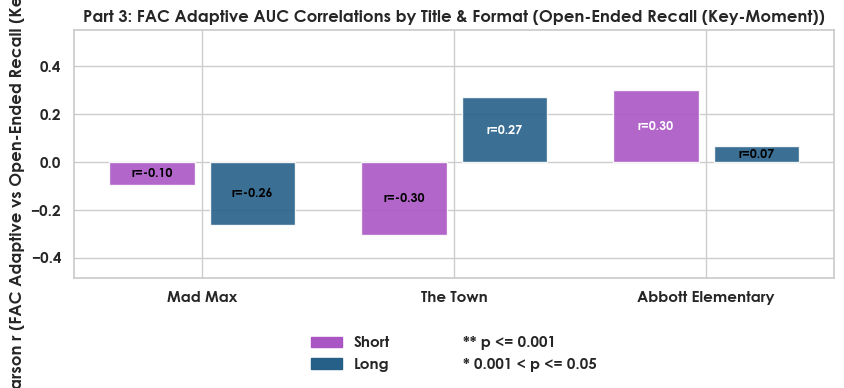

In [77]:
fac_recall_part3_results: Dict[Tuple[str, str], Dict[str, pd.DataFrame]] = {}

for (stat_label, recall_label), subset in fac_recall_section.items():
    title_corr_records: List[Dict[str, object]] = []
    title_diff_records: List[Dict[str, object]] = []

    for title_name, title_df in subset.groupby("title", observed=True):
        for form_name, form_df in title_df.groupby("form", observed=True):
            form_df = form_df.dropna(subset=["fac_value", "recall_value"])
            if (
                form_df.shape[0] < 3
                or form_df["fac_value"].nunique() < 2
                or form_df["recall_value"].nunique() < 2
            ):
                r_val = np.nan
                p_val = np.nan
            else:
                r_val, p_val = stats.pearsonr(form_df["fac_value"], form_df["recall_value"])
            title_corr_records.append(
                {
                    "title": title_name,
                    "form": form_name,
                    "pearson_r": r_val,
                    "p_value": p_val,
                    "n": form_df.shape[0],
                }
            )

        if title_df["form"].nunique() >= 2:
            diff_model = smf.ols("recall_value ~ fac_value * C(form)", data=title_df).fit()
            interaction_name = "fac_value:C(form)[T.Long]"
            diff_p = diff_model.pvalues.get(interaction_name, np.nan)
        else:
            diff_p = np.nan
        title_diff_records.append({"title": title_name, "delta_p_value": diff_p})

    title_corr_df = pd.DataFrame(title_corr_records)
    title_diff_df = pd.DataFrame(title_diff_records)

    if title_corr_df.empty:
        print(f"Part 3 skipped for {stat_label} Ã— {recall_label}: insufficient coverage.")
        continue

    title_order = [t for t in TARGET_TITLES if t in title_corr_df["title"].unique()]
    if not title_order:
        title_order = sorted(title_corr_df["title"].unique())
    form_order = ["Short", "Long"]
    bar_width = 0.34
    x_positions = np.arange(len(title_order))
    fig, ax = plt.subplots(figsize=(8.6, 4.6))
    max_bar_height = 0.0
    min_bar_height = 0.0

    for title_idx, title_name in enumerate(title_order):
        title_subset = title_corr_df.loc[title_corr_df["title"] == title_name]
        local_max = 0.0
        local_min = 0.0
        for offset_idx, form_name in enumerate(form_order):
            form_row = title_subset.loc[title_subset["form"] == form_name]
            if form_row.empty:
                continue
            r_val = form_row["pearson_r"].iloc[0]
            p_val = form_row["p_value"].iloc[0]
            if not np.isfinite(r_val):
                continue
            bar_x = x_positions[title_idx] + (offset_idx - 0.5) * (bar_width + 0.06)
            color = COLOR_MAP.get(form_name, COLOR_MAP.get("Default", "#1f77b4"))
            ax.bar(bar_x, r_val, width=bar_width, color=color, alpha=0.9)
            local_max = max(local_max, r_val, 0.0)
            local_min = min(local_min, r_val, 0.0)
            annotation_label = significance_label(p_val)
            if annotation_label:
                text_offset = 0.035 if r_val >= 0 else -0.05
                va = "bottom" if r_val >= 0 else "top"
                ax.text(
                    bar_x,
                    r_val + text_offset,
                    annotation_label,
                    ha="center",
                    va=va,
                    fontsize=11,
                    fontweight="bold",
                )
            bar_text_color = "white" if r_val >= 0.25 else "black"
            text_y = r_val / 2 if r_val != 0 else 0.015
            ax.text(bar_x, text_y, f"r={r_val:.2f}", ha="center", va="center", color=bar_text_color, fontsize=9)
        max_bar_height = max(max_bar_height, local_max)
        min_bar_height = min(min_bar_height, local_min)
        diff_row = title_diff_df.loc[title_diff_df["title"] == title_name]
        if not diff_row.empty:
            diff_p = diff_row["delta_p_value"].iloc[0]
            diff_label = significance_label(diff_p)
            if diff_label:
                x_center = x_positions[title_idx]
                half_span = (bar_width + 0.06) / 2
                bracket_height = local_max + 0.18
                ax.plot(
                    [x_center - half_span, x_center - half_span, x_center + half_span, x_center + half_span],
                    [bracket_height - 0.05, bracket_height, bracket_height, bracket_height - 0.05],
                    color="#2f2f2f",
                    linewidth=1.4,
                )
                ax.text(
                    x_center,
                    bracket_height + 0.02,
                    diff_label,
                    ha="center",
                    va="bottom",
                    fontsize=11,
                    fontweight="bold",
                )

    ax.set_xticks(x_positions)
    ax.set_xticklabels(title_order)
    ax.set_ylabel(f"Pearson r (FAC Adaptive vs {recall_label})")
    ax.set_title(f"Part 3: FAC Adaptive {stat_label} Correlations by Title & Format ({recall_label})")
    lower_bound = min(-0.35, min_bar_height - 0.18)
    upper_bound = max(0.1, max_bar_height + 0.25)
    ax.set_ylim(lower_bound, upper_bound)

    format_handles = [
        patches.Patch(color=COLOR_MAP.get(form_name, COLOR_MAP.get("Default", "#1f77b4")), label=form_name)
        for form_name in form_order
        if form_name in title_corr_df["form"].unique()
    ]
    sign_handles = [
        plt.Line2D([], [], color="black", marker="", linestyle="None", markersize=11, label="** p <= 0.001"),
        plt.Line2D([], [], color="black", marker="", linestyle="None", markersize=11, label="* 0.001 < p <= 0.05"),
    ]
    legend_handles = format_handles + sign_handles
    ax.legend(
        legend_handles,
        [handle.get_label() for handle in legend_handles],
        loc="upper center",
        bbox_to_anchor=(0.5, -0.18),
        ncol=2,
        frameon=False,
    )
    plt.tight_layout(rect=(0, 0.08, 1, 1))
    plt.show()

    fac_recall_part3_results[(stat_label, recall_label)] = {
        "title_correlations": title_corr_df.sort_values(["title", "form"]).reset_index(drop=True),
        "title_differences": title_diff_df.sort_values("title").reset_index(drop=True),
    }

if not fac_recall_part3_results:
    print("Part 3 did not generate any title-level recall outputs.")

## Metric: FAC Contempt AUC
Use the shared runner to replicate Enjoyment, Familiarity, and Recall parts for the Contempt signal.

### Section: FAC Contempt AUC Ã— Enjoyment
Runs Parts 1â€“3 against Stage 2 enjoyment scores.

FAC Contempt AUC: n=163, respondents=82, titles=3


#### Part 1: Overall FAC Contempt Ã— Enjoyment

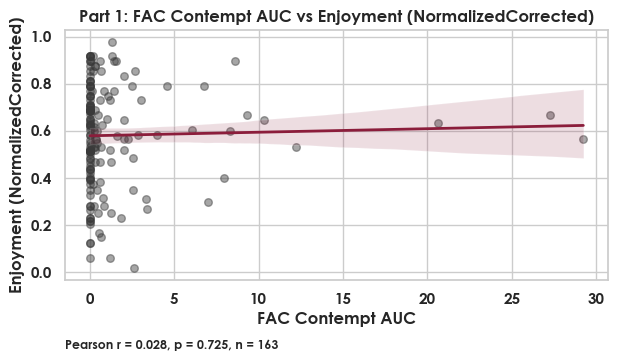

Metric stat  Pearson r  p-value    n
0         AUC   0.027717  p=0.725  163

Part 1 - FAC Contempt AUC x Enjoyment (NormalizedCorrected): Long form (68%) showed 20% greater than short form (48%) (Pearson r=0.028, p=0.725, n=163).


#### Part 2: Format-Specific FAC Contempt Ã— Enjoyment

=== FAC Contempt AUC - Format Diagnostics (Enjoyment (NormalizedCorrected)) ===


sum_sq     df          F        PR(>F)
C(form)               1.620217e+00    1.0  44.138647  4.617181e-10
metric_value          4.566519e-02    1.0   1.244031  2.663785e-01
metric_value:C(form)  8.893759e-07    1.0   0.000024  9.960788e-01
Residual              5.836483e+00  159.0        NaN           NaN

Part 2 - FAC Contempt AUC x Enjoyment (NormalizedCorrected): Long form (68%) showed 20% greater than short form (48%) (Interaction p=p=0.996).


#### Part 3: Title-Level FAC Contempt Ã— Enjoyment

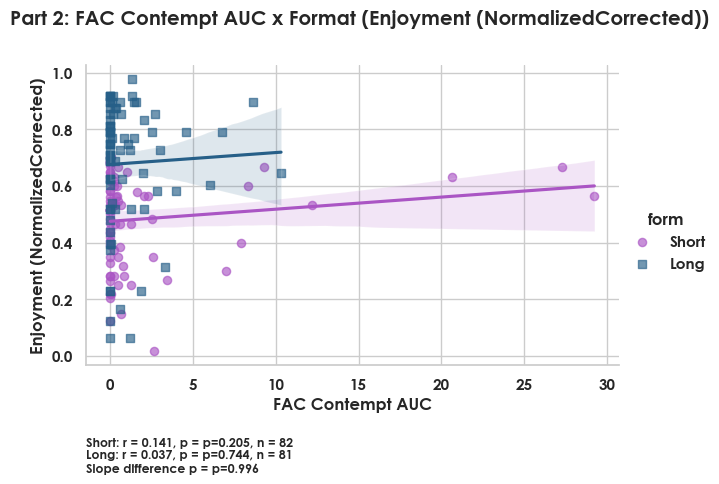

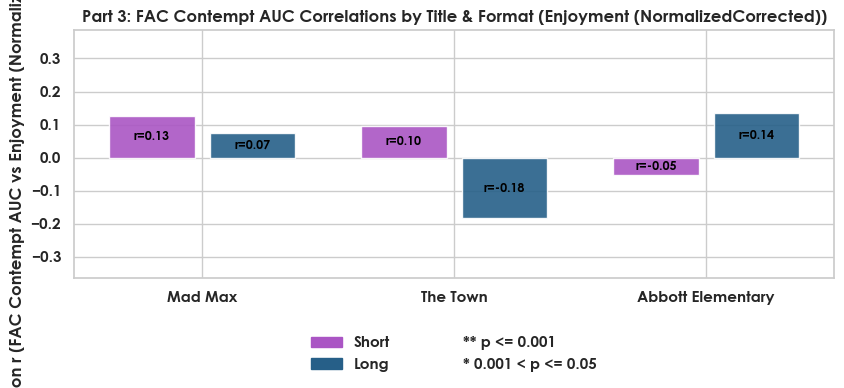

In [78]:
run_three_part_section(
    metric_label=BIOMETRIC_EXTENSION["fac_contempt"]["label"],
    metric_df=BIOMETRIC_EXTENSION["fac_contempt"]["frame"],
    metric_columns=BIOMETRIC_EXTENSION["fac_contempt"]["columns"],
    outcome_df=enjoyment_norm,
    outcome_column="enjoyment_norm",
    outcome_label="Enjoyment (NormalizedCorrected)",
    section_label="FAC Contempt Ã— Enjoyment",
    merge_validate="many_to_one",
    line_color=BIOMETRIC_EXTENSION["fac_contempt"]["line_color"],
)

### Section: FAC Contempt AUC Ã— Familiarity
Replicates Parts 1â€“3 against Screening Familiarity C1.

FAC Contempt AUC: n=164, respondents=82, titles=3


#### Part 1: Overall FAC Contempt Ã— Familiarity

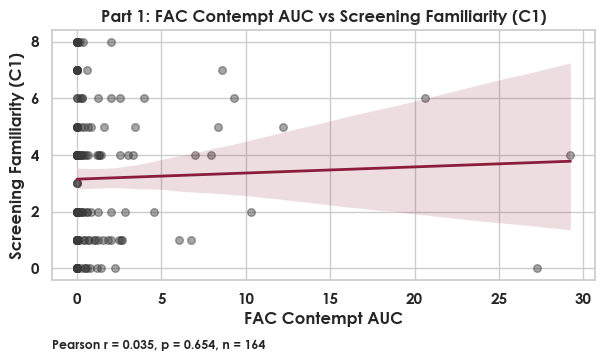

Metric stat  Pearson r  p-value    n
0         AUC   0.035255  p=0.654  164

Part 1 - FAC Contempt AUC x Screening Familiarity (C1): Long form (327%) showed 18% greater than short form (309%) (Pearson r=0.035, p=0.654, n=164).


#### Part 2: Format-Specific FAC Contempt Ã— Familiarity

=== FAC Contempt AUC - Format Diagnostics (Screening Familiarity (C1)) ===


sum_sq     df         F    PR(>F)
C(form)                 1.689475    1.0  0.284378  0.594586
metric_value            1.505589    1.0  0.253425  0.615366
metric_value:C(form)    2.441746    1.0  0.411002  0.522378
Residual              950.552665  160.0       NaN       NaN

Part 2 - FAC Contempt AUC x Screening Familiarity (C1): Long form (327%) showed 18% greater than short form (309%) (Interaction p=p=0.522).


#### Part 3: Title-Level FAC Contempt Ã— Familiarity

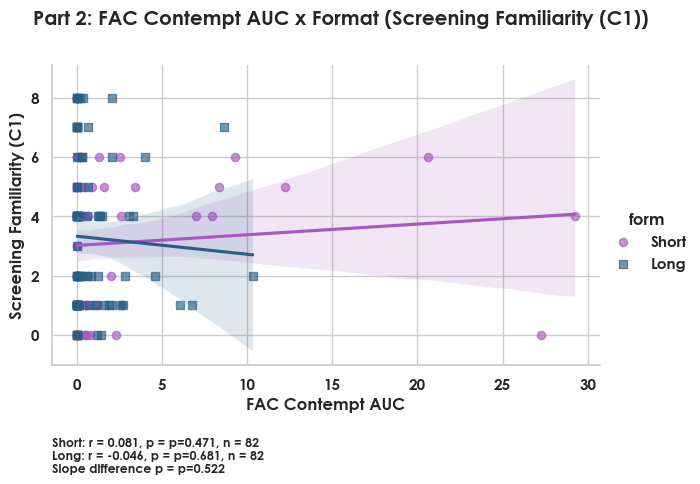

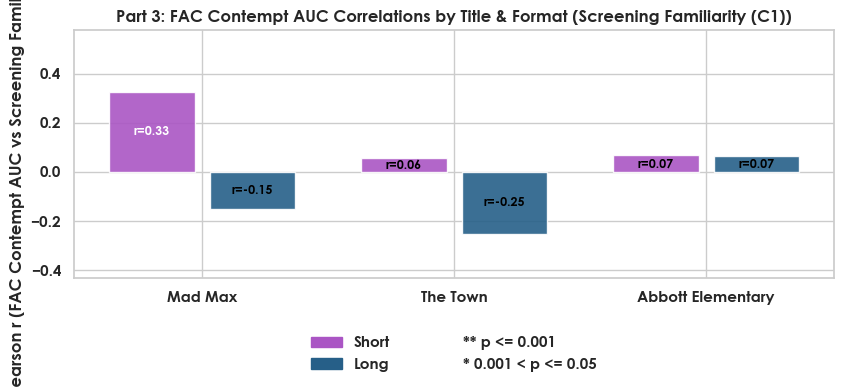

In [79]:
run_three_part_section(
    metric_label=BIOMETRIC_EXTENSION["fac_contempt"]["label"],
    metric_df=BIOMETRIC_EXTENSION["fac_contempt"]["frame"],
    metric_columns=BIOMETRIC_EXTENSION["fac_contempt"]["columns"],
    outcome_df=familiarity_c1,
    outcome_column="familiarity_c1",
    outcome_label="Screening Familiarity (C1)",
    section_label="FAC Contempt Ã— Familiarity",
    merge_validate="many_to_one",
    line_color=BIOMETRIC_EXTENSION["fac_contempt"]["line_color"],
)

### Section: FAC Contempt AUC Ã— Recall
Uses the pooled Q13/Q18 recall metric for Parts 1â€“3.

FAC Contempt AUC: n=161, respondents=82, titles=3


#### Part 1: Overall FAC Contempt Ã— Recall

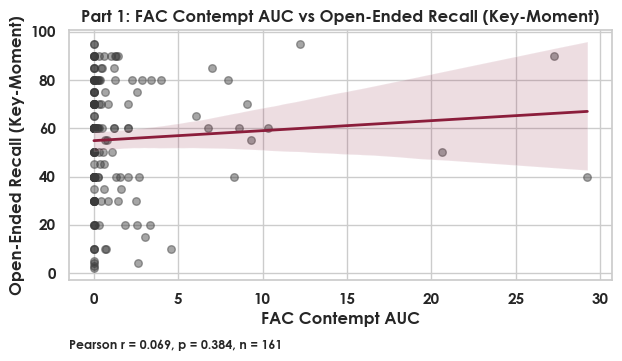

Metric stat  Pearson r  p-value    n
0         AUC   0.069049  p=0.384  161

Part 1 - FAC Contempt AUC x Open-Ended Recall (Key-Moment): Long form (5162%) showed 778% lower than short form (5940%) (Pearson r=0.069, p=0.384, n=161).


#### Part 2: Format-Specific FAC Contempt Ã— Recall

=== FAC Contempt AUC - Format Diagnostics (Open-Ended Recall (Key-Moment)) ===


sum_sq     df         F    PR(>F)
C(form)                2257.767124    1.0  3.915529  0.049591
metric_value            264.496795    1.0  0.458703  0.499227
metric_value:C(form)     20.700434    1.0  0.035900  0.849968
Residual              90529.138573  157.0       NaN       NaN

Part 2 - FAC Contempt AUC x Open-Ended Recall (Key-Moment): Long form (5162%) showed 778% lower than short form (5940%) (Interaction p=p=0.850).


#### Part 3: Title-Level FAC Contempt Ã— Recall

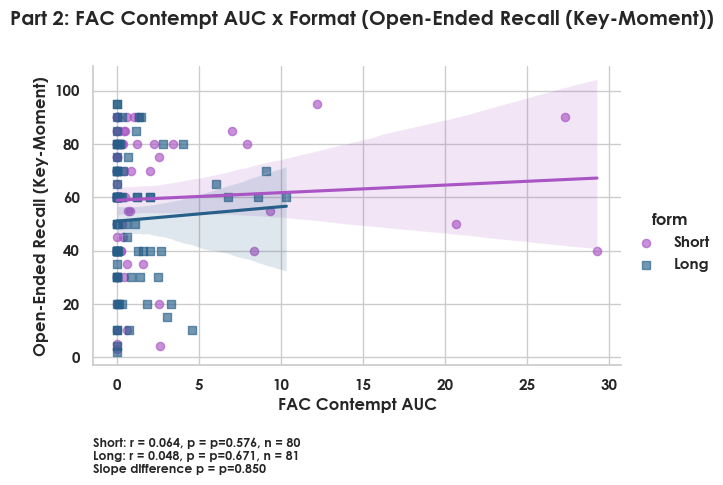

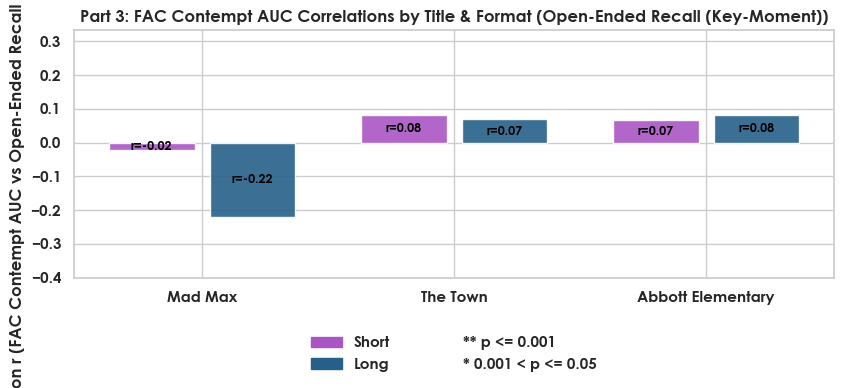

In [80]:
run_three_part_section(
    metric_label=BIOMETRIC_EXTENSION["fac_contempt"]["label"],
    metric_df=BIOMETRIC_EXTENSION["fac_contempt"]["frame"],
    metric_columns=BIOMETRIC_EXTENSION["fac_contempt"]["columns"],
    outcome_df=recall_long_combined,
    outcome_column="recall_value",
    outcome_label=RECALL_COMBINED_LABEL,
    section_label="FAC Contempt Ã— Recall",
    merge_validate="one_to_many",
    line_color=BIOMETRIC_EXTENSION["fac_contempt"]["line_color"],
)

## Metric: FAC Joy AUC
Mirror the same three sections using the Joy signal.

### Section: FAC Joy AUC Ã— Enjoyment
Applies Parts 1â€“3 to Joy vs enjoyment.

FAC Joy AUC: n=163, respondents=82, titles=3


#### Part 1: Overall FAC Joy Ã— Enjoyment

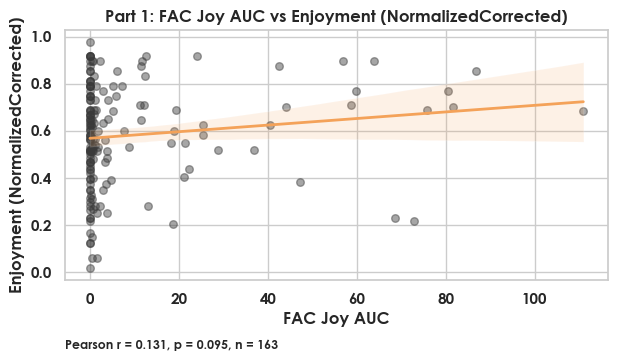

Metric stat  Pearson r  p-value    n
0         AUC   0.131228  p=0.095  163

Part 1 - FAC Joy AUC x Enjoyment (NormalizedCorrected): Long form (68%) showed 20% greater than short form (48%) (Pearson r=0.131, p=0.095, n=163).


#### Part 2: Format-Specific FAC Joy Ã— Enjoyment

=== FAC Joy AUC - Format Diagnostics (Enjoyment (NormalizedCorrected)) ===


sum_sq     df          F        PR(>F)
C(form)               1.519970    1.0  41.580183  1.293189e-09
metric_value          0.068195    1.0   1.865536  1.739161e-01
metric_value:C(form)  0.001683    1.0   0.046039  8.303804e-01
Residual              5.812271  159.0        NaN           NaN

Part 2 - FAC Joy AUC x Enjoyment (NormalizedCorrected): Long form (68%) showed 20% greater than short form (48%) (Interaction p=p=0.830).


#### Part 3: Title-Level FAC Joy Ã— Enjoyment

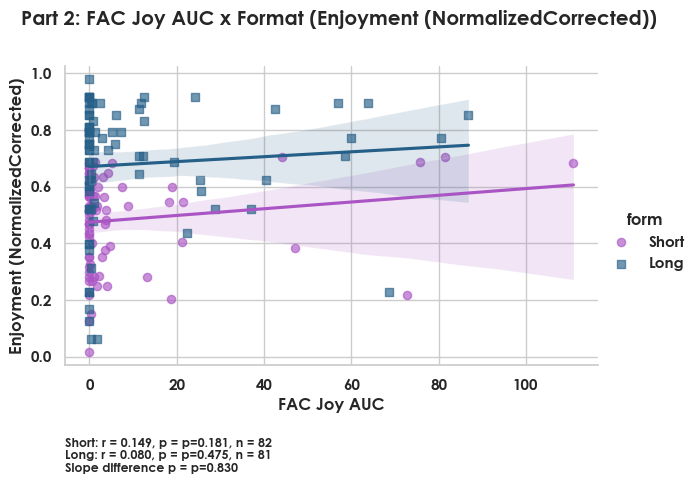

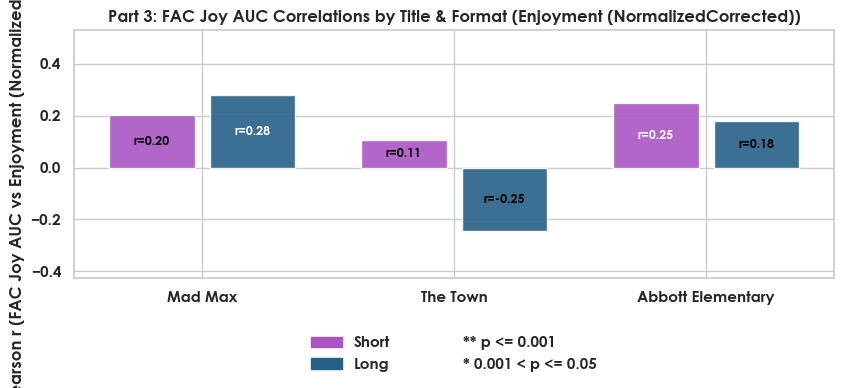

In [81]:
run_three_part_section(
    metric_label=BIOMETRIC_EXTENSION["fac_joy"]["label"],
    metric_df=BIOMETRIC_EXTENSION["fac_joy"]["frame"],
    metric_columns=BIOMETRIC_EXTENSION["fac_joy"]["columns"],
    outcome_df=enjoyment_norm,
    outcome_column="enjoyment_norm",
    outcome_label="Enjoyment (NormalizedCorrected)",
    section_label="FAC Joy Ã— Enjoyment",
    merge_validate="many_to_one",
    line_color=BIOMETRIC_EXTENSION["fac_joy"]["line_color"],
)

### Section: FAC Joy AUC Ã— Familiarity
Screening familiarity pairing.

FAC Joy AUC: n=164, respondents=82, titles=3


#### Part 1: Overall FAC Joy Ã— Familiarity

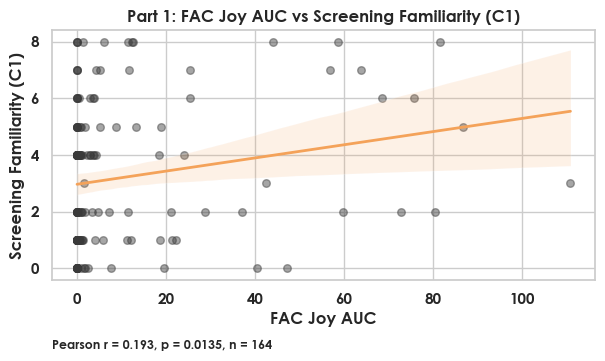

Metric stat  Pearson r  p-value    n
0         AUC   0.192577  p=0.013  164

Part 1 - FAC Joy AUC x Screening Familiarity (C1): Long form (327%) showed 18% greater than short form (309%) (Pearson r=0.193, p=0.013, n=164).


#### Part 2: Format-Specific FAC Joy Ã— Familiarity

=== FAC Joy AUC - Format Diagnostics (Screening Familiarity (C1)) ===


sum_sq     df         F    PR(>F)
C(form)                 0.528310    1.0  0.091965  0.762087
metric_value           34.605586    1.0  6.023951  0.015185
metric_value:C(form)    0.747915    1.0  0.130193  0.718708
Residual              919.146499  160.0       NaN       NaN

Part 2 - FAC Joy AUC x Screening Familiarity (C1): Long form (327%) showed 18% greater than short form (309%) (Interaction p=p=0.719).


#### Part 3: Title-Level FAC Joy Ã— Familiarity

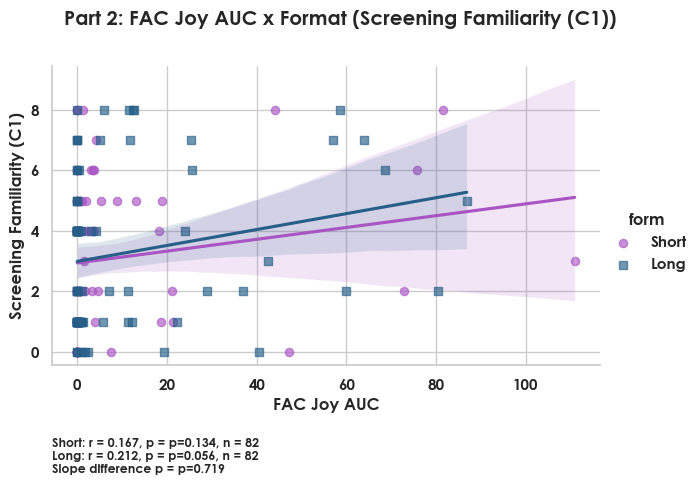

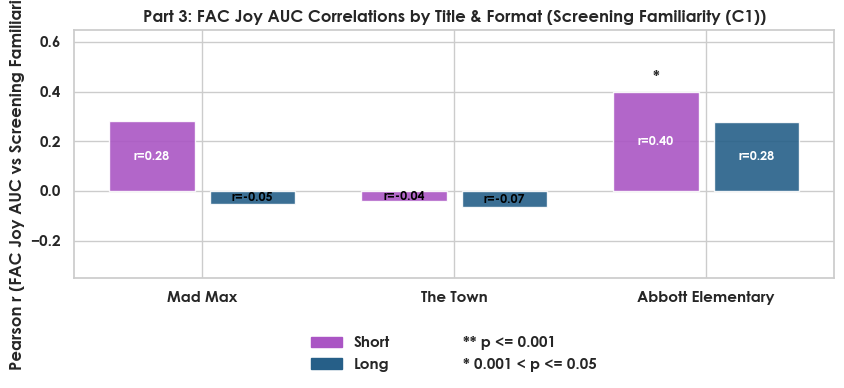

In [82]:
run_three_part_section(
    metric_label=BIOMETRIC_EXTENSION["fac_joy"]["label"],
    metric_df=BIOMETRIC_EXTENSION["fac_joy"]["frame"],
    metric_columns=BIOMETRIC_EXTENSION["fac_joy"]["columns"],
    outcome_df=familiarity_c1,
    outcome_column="familiarity_c1",
    outcome_label="Screening Familiarity (C1)",
    section_label="FAC Joy Ã— Familiarity",
    merge_validate="many_to_one",
    line_color=BIOMETRIC_EXTENSION["fac_joy"]["line_color"],
)

### Section: FAC Joy AUC Ã— Recall
Joy vs pooled recall responses.

FAC Joy AUC: n=161, respondents=82, titles=3


#### Part 1: Overall FAC Joy Ã— Recall

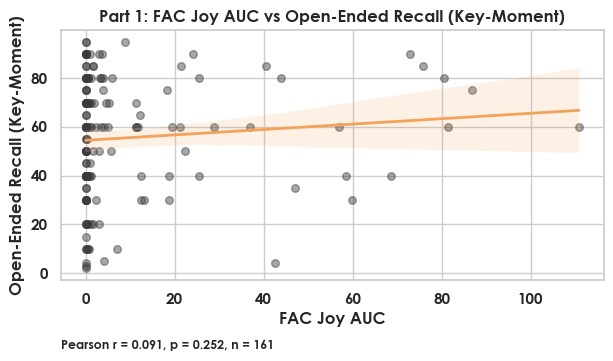

Metric stat  Pearson r  p-value    n
0         AUC   0.090801  p=0.252  161

Part 1 - FAC Joy AUC x Open-Ended Recall (Key-Moment): Long form (5162%) showed 778% lower than short form (5940%) (Pearson r=0.091, p=0.252, n=161).


#### Part 2: Format-Specific FAC Joy Ã— Recall

=== FAC Joy AUC - Format Diagnostics (Open-Ended Recall (Key-Moment)) ===


sum_sq     df         F    PR(>F)
C(form)                2605.096734    1.0  4.550653  0.034460
metric_value            936.062964    1.0  1.635140  0.202881
metric_value:C(form)      1.023308    1.0  0.001788  0.966330
Residual              89877.249530  157.0       NaN       NaN

Part 2 - FAC Joy AUC x Open-Ended Recall (Key-Moment): Long form (5162%) showed 778% lower than short form (5940%) (Interaction p=p=0.966).


#### Part 3: Title-Level FAC Joy Ã— Recall

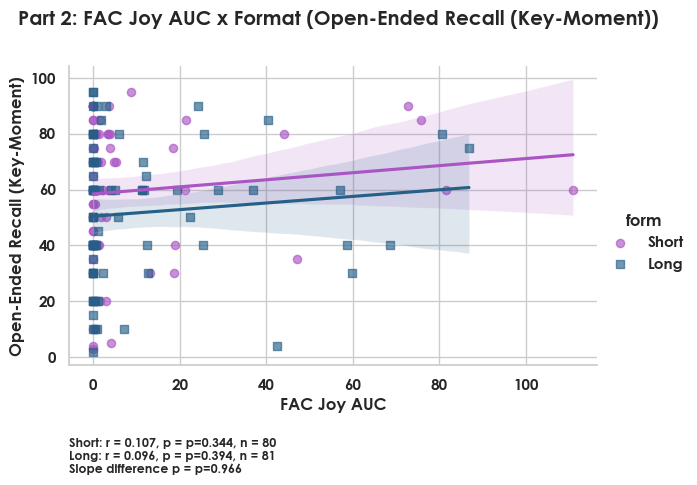

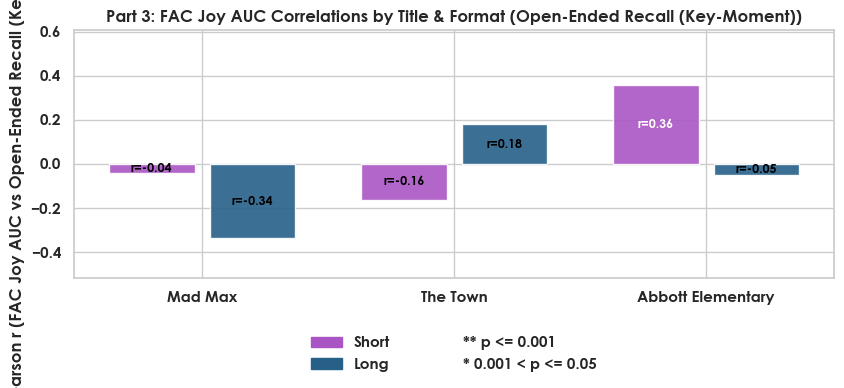

In [83]:
run_three_part_section(
    metric_label=BIOMETRIC_EXTENSION["fac_joy"]["label"],
    metric_df=BIOMETRIC_EXTENSION["fac_joy"]["frame"],
    metric_columns=BIOMETRIC_EXTENSION["fac_joy"]["columns"],
    outcome_df=recall_long_combined,
    outcome_column="recall_value",
    outcome_label=RECALL_COMBINED_LABEL,
    section_label="FAC Joy Ã— Recall",
    merge_validate="one_to_many",
    line_color=BIOMETRIC_EXTENSION["fac_joy"]["line_color"],
)

## Metric: FAC Surprise AUC
Extend the three-part helper workflow to the Surprise signal.

### Section: FAC Surprise AUC Ã— Enjoyment
Runs Parts 1â€“3 versus Stage 2 enjoyment.

FAC Surprise AUC: n=163, respondents=82, titles=3


#### Part 1: Overall FAC Surprise Ã— Enjoyment

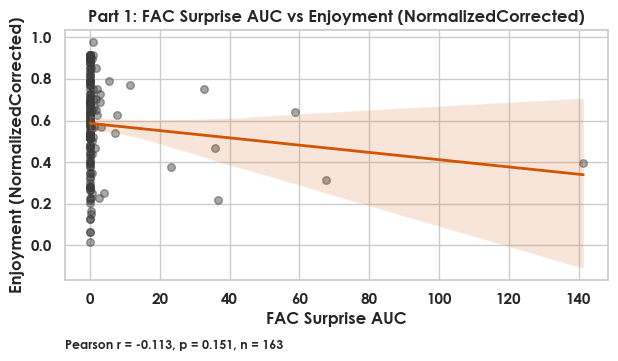

Metric stat  Pearson r  p-value    n
0         AUC  -0.113109  p=0.151  163

Part 1 - FAC Surprise AUC x Enjoyment (NormalizedCorrected): Long form (68%) showed 20% greater than short form (48%) (Pearson r=-0.113, p=0.151, n=163).


#### Part 2: Format-Specific FAC Surprise Ã— Enjoyment

=== FAC Surprise AUC - Format Diagnostics (Enjoyment (NormalizedCorrected)) ===


sum_sq     df          F        PR(>F)
C(form)               1.648201    1.0  46.093113  2.122359e-10
metric_value          0.163388    1.0   4.569260  3.407919e-02
metric_value:C(form)  0.033229    1.0   0.929262  3.365185e-01
Residual              5.685533  159.0        NaN           NaN

Part 2 - FAC Surprise AUC x Enjoyment (NormalizedCorrected): Long form (68%) showed 20% greater than short form (48%) (Interaction p=p=0.337).


#### Part 3: Title-Level FAC Surprise Ã— Enjoyment

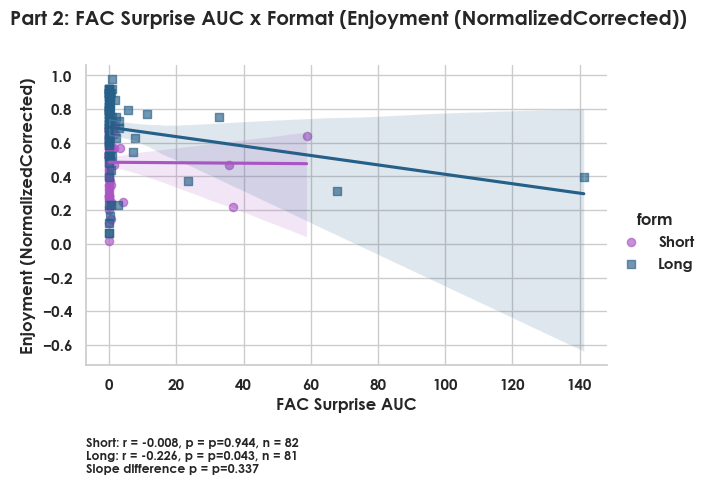

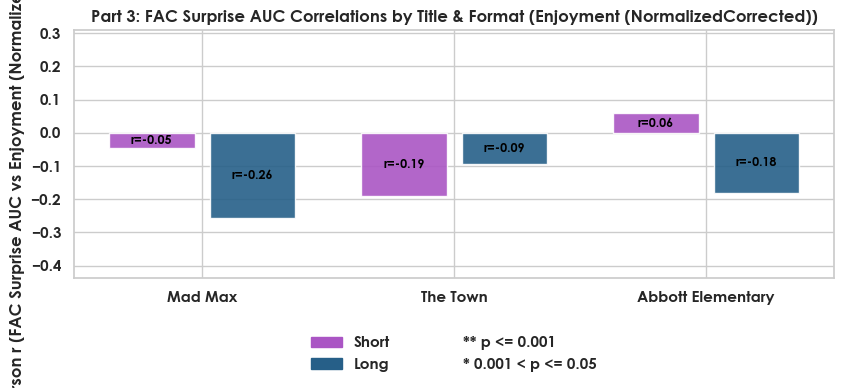

In [84]:
run_three_part_section(
    metric_label=BIOMETRIC_EXTENSION["fac_surprise"]["label"],
    metric_df=BIOMETRIC_EXTENSION["fac_surprise"]["frame"],
    metric_columns=BIOMETRIC_EXTENSION["fac_surprise"]["columns"],
    outcome_df=enjoyment_norm,
    outcome_column="enjoyment_norm",
    outcome_label="Enjoyment (NormalizedCorrected)",
    section_label="FAC Surprise Ã— Enjoyment",
    merge_validate="many_to_one",
    line_color=BIOMETRIC_EXTENSION["fac_surprise"]["line_color"],
)

### Section: FAC Surprise AUC Ã— Familiarity
Correlates with Screening Familiarity C1.

FAC Surprise AUC: n=164, respondents=82, titles=3


#### Part 1: Overall FAC Surprise Ã— Familiarity

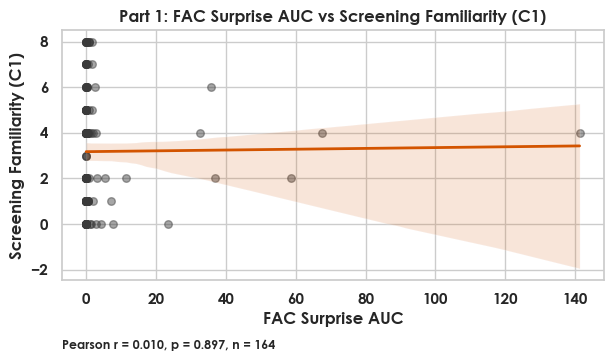

Metric stat  Pearson r  p-value    n
0         AUC   0.010204  p=0.897  164

Part 1 - FAC Surprise AUC x Screening Familiarity (C1): Long form (327%) showed 18% greater than short form (309%) (Pearson r=0.010, p=0.897, n=164).


#### Part 2: Format-Specific FAC Surprise Ã— Familiarity

=== FAC Surprise AUC - Format Diagnostics (Screening Familiarity (C1)) ===


sum_sq     df         F    PR(>F)
C(form)                 1.325412    1.0  0.222191  0.638018
metric_value            0.052989    1.0  0.008883  0.925028
metric_value:C(form)    0.015936    1.0  0.002671  0.958843
Residual              954.431075  160.0       NaN       NaN

Part 2 - FAC Surprise AUC x Screening Familiarity (C1): Long form (327%) showed 18% greater than short form (309%) (Interaction p=p=0.959).


#### Part 3: Title-Level FAC Surprise Ã— Familiarity

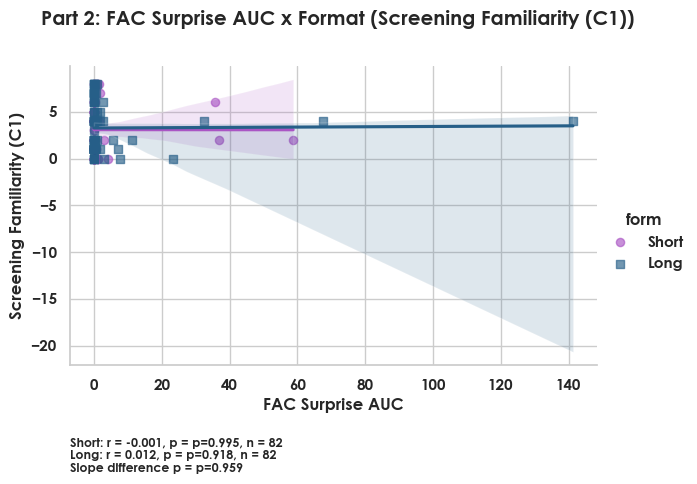

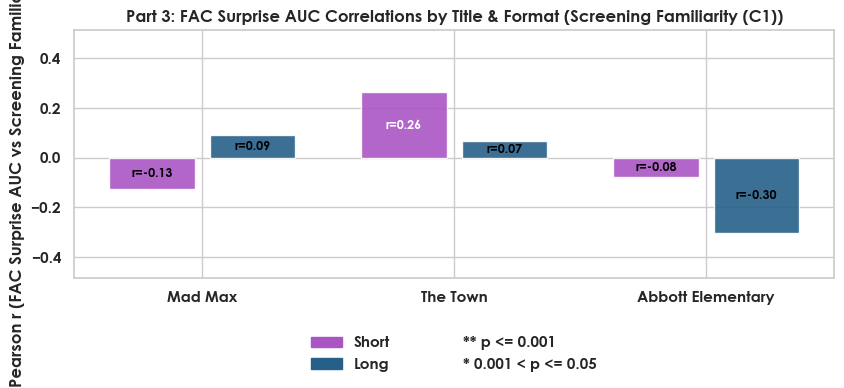

In [85]:
run_three_part_section(
    metric_label=BIOMETRIC_EXTENSION["fac_surprise"]["label"],
    metric_df=BIOMETRIC_EXTENSION["fac_surprise"]["frame"],
    metric_columns=BIOMETRIC_EXTENSION["fac_surprise"]["columns"],
    outcome_df=familiarity_c1,
    outcome_column="familiarity_c1",
    outcome_label="Screening Familiarity (C1)",
    section_label="FAC Surprise Ã— Familiarity",
    merge_validate="many_to_one",
    line_color=BIOMETRIC_EXTENSION["fac_surprise"]["line_color"],
)

### Section: FAC Surprise AUC Ã— Recall
Maps Surprise to the pooled Q13/Q18 recall metric.

FAC Surprise AUC: n=161, respondents=82, titles=3


#### Part 1: Overall FAC Surprise Ã— Recall

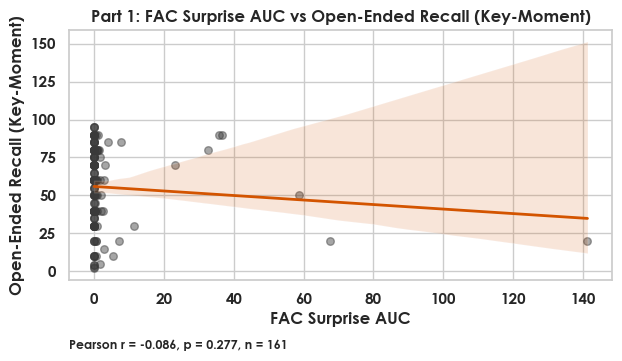

Metric stat  Pearson r  p-value    n
0         AUC  -0.086193  p=0.277  161

Part 1 - FAC Surprise AUC x Open-Ended Recall (Key-Moment): Long form (5162%) showed 778% lower than short form (5940%) (Pearson r=-0.086, p=0.277, n=161).


#### Part 2: Format-Specific FAC Surprise Ã— Recall

=== FAC Surprise AUC - Format Diagnostics (Open-Ended Recall (Key-Moment)) ===


sum_sq     df         F    PR(>F)
C(form)                2264.446271    1.0  3.997553  0.047292
metric_value            519.364242    1.0  0.916862  0.339772
metric_value:C(form)   1361.039841    1.0  2.402719  0.123138
Residual              88933.931719  157.0       NaN       NaN

Part 2 - FAC Surprise AUC x Open-Ended Recall (Key-Moment): Long form (5162%) showed 778% lower than short form (5940%) (Interaction p=p=0.123).


#### Part 3: Title-Level FAC Surprise Ã— Recall

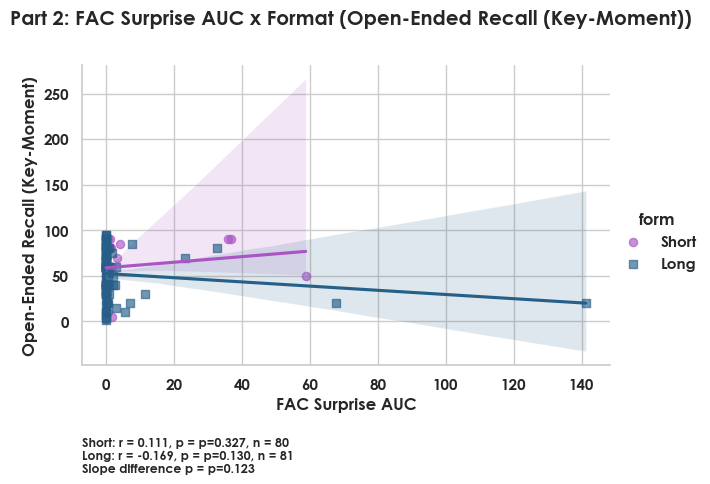

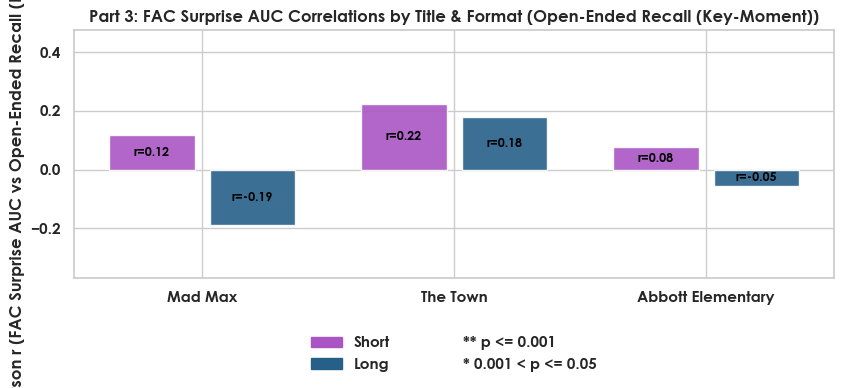

In [86]:
run_three_part_section(
    metric_label=BIOMETRIC_EXTENSION["fac_surprise"]["label"],
    metric_df=BIOMETRIC_EXTENSION["fac_surprise"]["frame"],
    metric_columns=BIOMETRIC_EXTENSION["fac_surprise"]["columns"],
    outcome_df=recall_long_combined,
    outcome_column="recall_value",
    outcome_label=RECALL_COMBINED_LABEL,
    section_label="FAC Surprise Ã— Recall",
    merge_validate="one_to_many",
    line_color=BIOMETRIC_EXTENSION["fac_surprise"]["line_color"],
)

## Metric: FAC Emotion Composite
Run the summed affective trace through the Part 1â€“3 workflow to compare against enjoyment, familiarity, and recall.

### Section: FAC Emotion Ã— Enjoyment
Assess how the composite emotion energy aligns with Stage 2 enjoyment.

FAC Emotion Composite (AUC Sum): n=163, respondents=82, titles=3


#### Part 1: Overall FAC Emotion Ã— Enjoyment

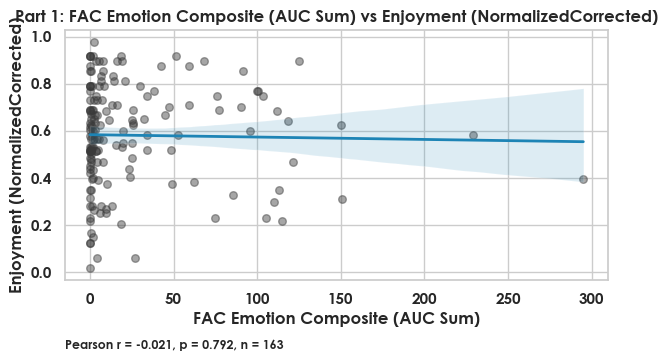

Metric stat  Pearson r  p-value    n
0   Composite  -0.020854  p=0.792  163

Part 1 - FAC Emotion Composite (AUC Sum) x Enjoyment (NormalizedCorrected): Long form (68%) showed 20% greater than short form (48%) (Pearson r=-0.021, p=0.792, n=163).


#### Part 2: Format-Specific FAC Emotion Ã— Enjoyment

=== FAC Emotion Composite (AUC Sum) - Format Diagnostics (Enjoyment (NormalizedCorrected)) ===


sum_sq     df          F        PR(>F)
C(form)               1.628513    1.0  44.908964  3.395578e-10
metric_value          0.051474    1.0   1.419486  2.352634e-01
metric_value:C(form)  0.064931    1.0   1.790569  1.827674e-01
Residual              5.765744  159.0        NaN           NaN

Part 2 - FAC Emotion Composite (AUC Sum) x Enjoyment (NormalizedCorrected): Long form (68%) showed 20% greater than short form (48%) (Interaction p=p=0.183).


#### Part 3: Title-Level FAC Emotion Ã— Enjoyment

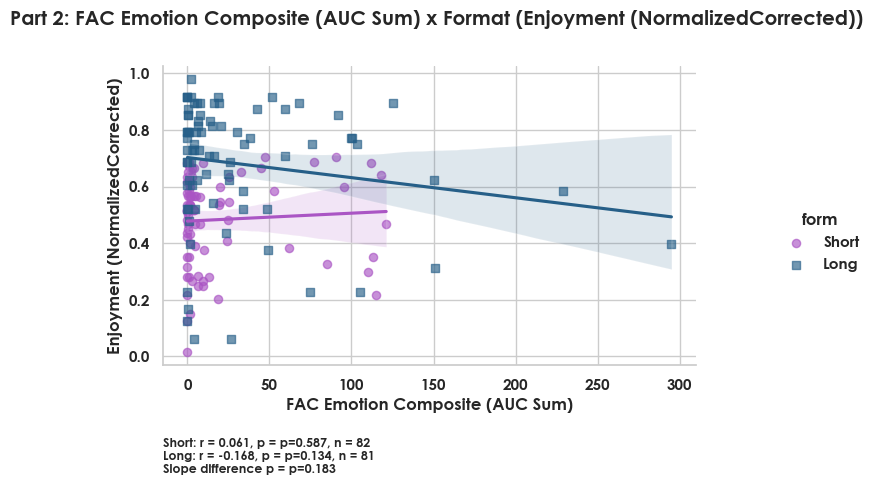

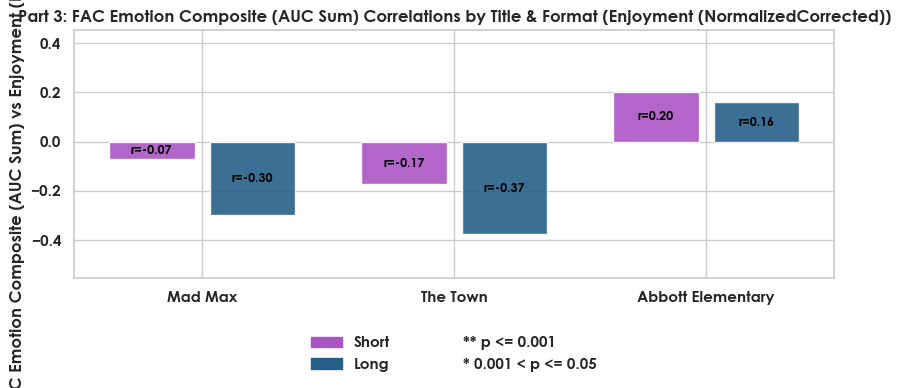

In [87]:
run_three_part_section(
    metric_label=BIOMETRIC_EXTENSION["fac_emotion"]["label"],
    metric_df=BIOMETRIC_EXTENSION["fac_emotion"]["frame"],
    metric_columns=BIOMETRIC_EXTENSION["fac_emotion"]["columns"],
    outcome_df=enjoyment_norm,
    outcome_column="enjoyment_norm",
    outcome_label="Enjoyment (NormalizedCorrected)",
    section_label="FAC Emotion Ã— Enjoyment",
    merge_validate="many_to_one",
    line_color=BIOMETRIC_EXTENSION["fac_emotion"]["line_color"],
)

### Section: FAC Emotion Ã— Familiarity
Compare the composite against Screening Familiarity (C1) scores.

FAC Emotion Composite (AUC Sum): n=164, respondents=82, titles=3


#### Part 1: Overall FAC Emotion Ã— Familiarity

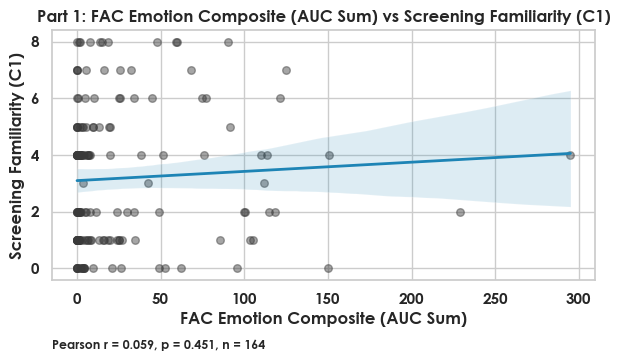

Metric stat  Pearson r  p-value    n
0   Composite   0.059271  p=0.451  164

Part 1 - FAC Emotion Composite (AUC Sum) x Screening Familiarity (C1): Long form (327%) showed 18% greater than short form (309%) (Pearson r=0.059, p=0.451, n=164).


#### Part 2: Format-Specific FAC Emotion Ã— Familiarity

=== FAC Emotion Composite (AUC Sum) - Format Diagnostics (Screening Familiarity (C1)) ===


sum_sq     df         F    PR(>F)
C(form)                 0.887273    1.0  0.149712  0.699325
metric_value            2.873380    1.0  0.484833  0.487252
metric_value:C(form)    3.380636    1.0  0.570424  0.451201
Residual              948.245983  160.0       NaN       NaN

Part 2 - FAC Emotion Composite (AUC Sum) x Screening Familiarity (C1): Long form (327%) showed 18% greater than short form (309%) (Interaction p=p=0.451).


#### Part 3: Title-Level FAC Emotion Ã— Familiarity

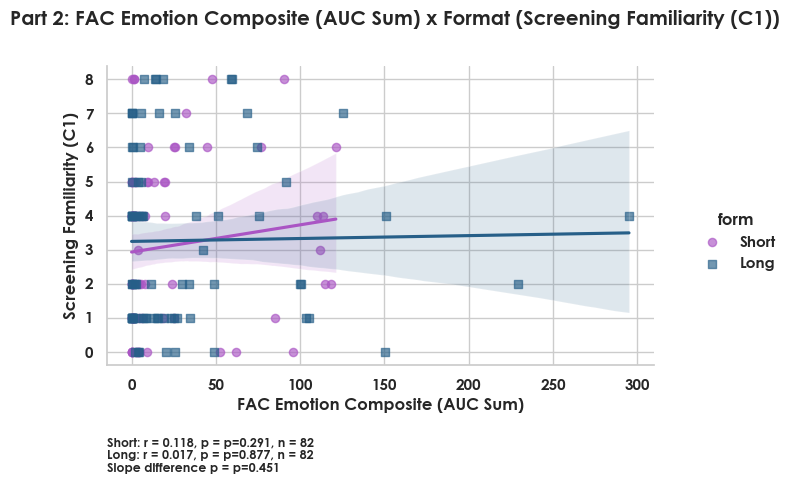

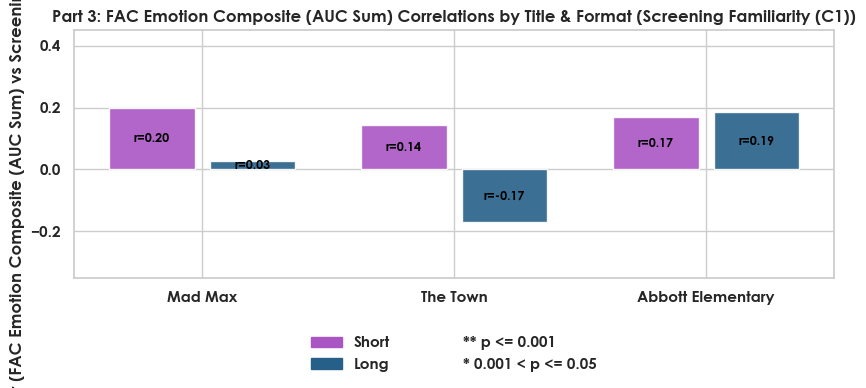

In [88]:
run_three_part_section(
    metric_label=BIOMETRIC_EXTENSION["fac_emotion"]["label"],
    metric_df=BIOMETRIC_EXTENSION["fac_emotion"]["frame"],
    metric_columns=BIOMETRIC_EXTENSION["fac_emotion"]["columns"],
    outcome_df=familiarity_c1,
    outcome_column="familiarity_c1",
    outcome_label="Screening Familiarity (C1)",
    section_label="FAC Emotion Ã— Familiarity",
    merge_validate="many_to_one",
    line_color=BIOMETRIC_EXTENSION["fac_emotion"]["line_color"],
)

### Section: FAC Emotion Ã— Recall
Leverage the pooled recall metric (Q13/Q18) to test how the composite predicts memory outcomes.

FAC Emotion Composite (AUC Sum): n=161, respondents=82, titles=3


#### Part 1: Overall FAC Emotion Ã— Recall

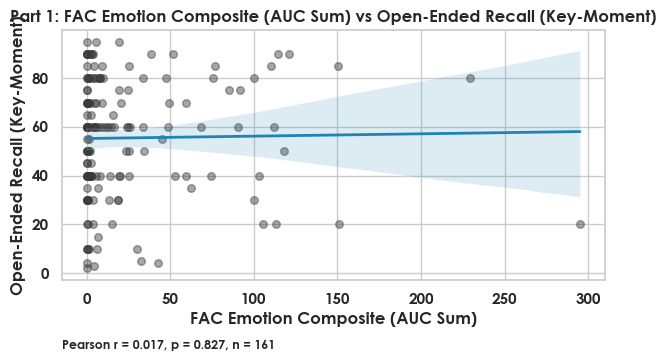

Metric stat  Pearson r  p-value    n
0   Composite   0.017341  p=0.827  161

Part 1 - FAC Emotion Composite (AUC Sum) x Open-Ended Recall (Key-Moment): Long form (5162%) showed 778% lower than short form (5940%) (Pearson r=0.017, p=0.827, n=161).


#### Part 2: Format-Specific FAC Emotion Ã— Recall

=== FAC Emotion Composite (AUC Sum) - Format Diagnostics (Open-Ended Recall (Key-Moment)) ===


sum_sq     df         F    PR(>F)
C(form)                2540.505488    1.0  4.409847  0.037331
metric_value            130.672109    1.0  0.226823  0.634552
metric_value:C(form)    236.222218    1.0  0.410038  0.522884
Residual              90447.441475  157.0       NaN       NaN

Part 2 - FAC Emotion Composite (AUC Sum) x Open-Ended Recall (Key-Moment): Long form (5162%) showed 778% lower than short form (5940%) (Interaction p=p=0.523).


#### Part 3: Title-Level FAC Emotion Ã— Recall

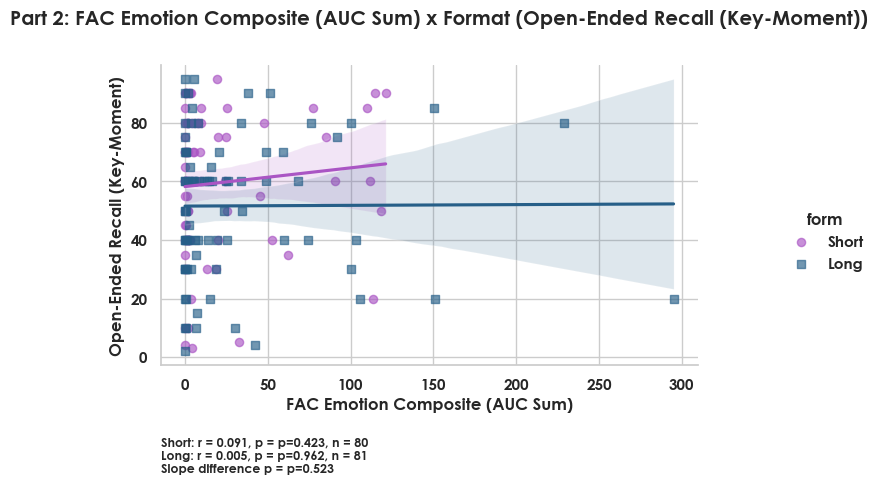

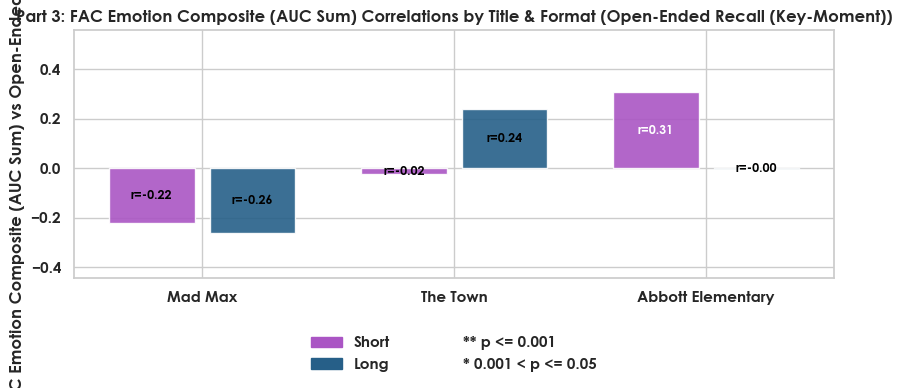

In [89]:
run_three_part_section(
    metric_label=BIOMETRIC_EXTENSION["fac_emotion"]["label"],
    metric_df=BIOMETRIC_EXTENSION["fac_emotion"]["frame"],
    metric_columns=BIOMETRIC_EXTENSION["fac_emotion"]["columns"],
    outcome_df=recall_long_combined,
    outcome_column="recall_value",
    outcome_label=RECALL_COMBINED_LABEL,
    section_label="FAC Emotion Ã— Recall",
    merge_validate="one_to_many",
    line_color=BIOMETRIC_EXTENSION["fac_emotion"]["line_color"],
)

## Metric: GSR Peaks Per Minute
Extend the workflow to the GSR Peaks/Minute stat.

### Section: GSR Peaks Ã— Enjoyment
Overall correlations between peaks/minute and enjoyment.

GSR Peaks Per Minute: n=117, respondents=66, titles=3


#### Part 1: Overall GSR Peaks Ã— Enjoyment

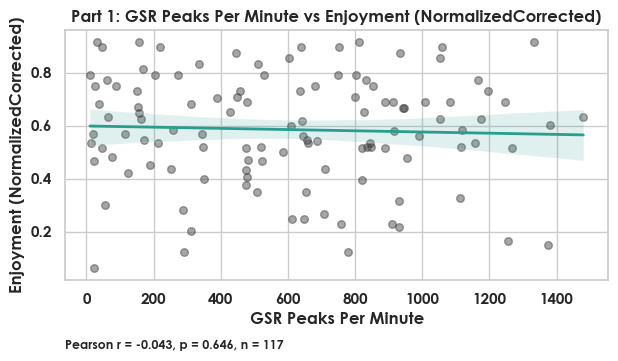

Metric stat  Pearson r  p-value    n
0   PERMINUTE  -0.042885  p=0.646  117

Part 1 - GSR Peaks Per Minute x Enjoyment (NormalizedCorrected): Long form (68%) showed 19% greater than short form (49%) (Pearson r=-0.043, p=0.646, n=117).


#### Part 2: Format-Specific GSR Peaks Ã— Enjoyment

=== GSR Peaks Per Minute - Format Diagnostics (Enjoyment (NormalizedCorrected)) ===


sum_sq     df          F        PR(>F)
C(form)               1.164423    1.0  35.859260  2.567044e-08
metric_value          0.070389    1.0   2.167681  1.437184e-01
metric_value:C(form)  0.023400    1.0   0.720634  3.977308e-01
Residual              3.669339  113.0        NaN           NaN

Part 2 - GSR Peaks Per Minute x Enjoyment (NormalizedCorrected): Long form (68%) showed 19% greater than short form (49%) (Interaction p=p=0.398).


#### Part 3: Title-Level GSR Peaks Ã— Enjoyment

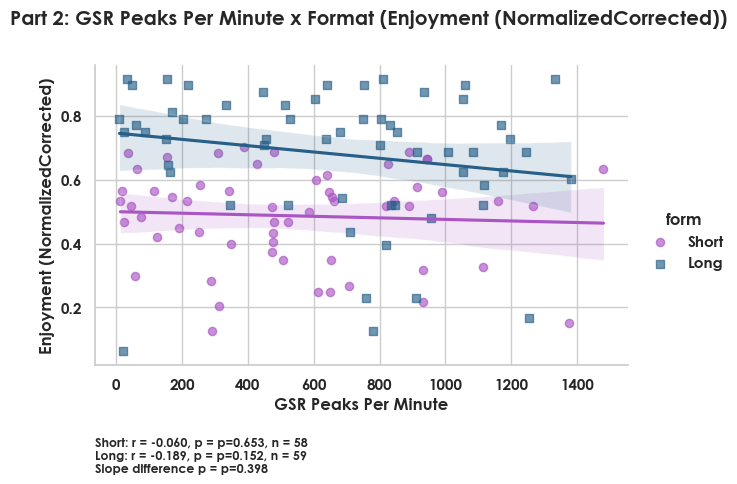

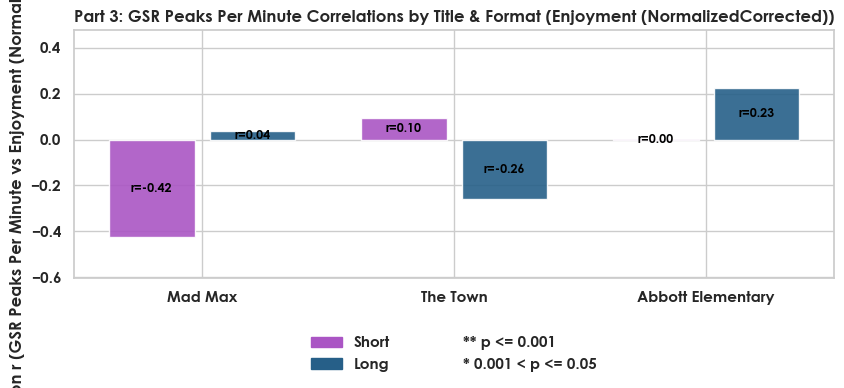

In [90]:
run_three_part_section(
    metric_label=BIOMETRIC_EXTENSION["gsr_peaks"]["label"],
    metric_df=BIOMETRIC_EXTENSION["gsr_peaks"]["frame"],
    metric_columns=BIOMETRIC_EXTENSION["gsr_peaks"]["columns"],
    outcome_df=enjoyment_norm,
    outcome_column="enjoyment_norm",
    outcome_label="Enjoyment (NormalizedCorrected)",
    section_label="GSR Peaks Ã— Enjoyment",
    merge_validate="many_to_one",
    line_color=BIOMETRIC_EXTENSION["gsr_peaks"]["line_color"],
)

### Section: GSR Peaks Ã— Familiarity
Format/title diagnostics for peaks vs familiarity.

GSR Peaks Per Minute: n=118, respondents=66, titles=3


#### Part 1: Overall GSR Peaks Ã— Familiarity

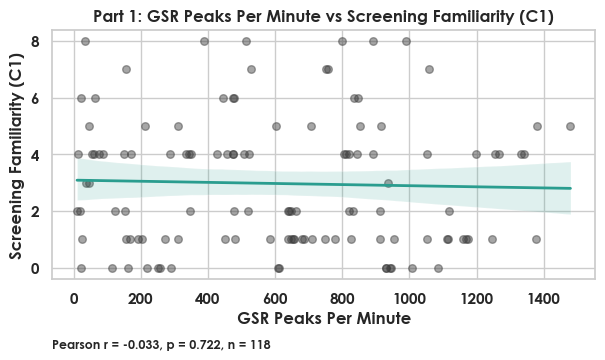

Metric stat  Pearson r  p-value    n
0   PERMINUTE   -0.03312  p=0.722  118

Part 1 - GSR Peaks Per Minute x Screening Familiarity (C1): Long form (305%) showed 15% greater than short form (290%) (Pearson r=-0.033, p=0.722, n=118).


#### Part 2: Format-Specific GSR Peaks Ã— Familiarity

=== GSR Peaks Per Minute - Format Diagnostics (Screening Familiarity (C1)) ===


sum_sq     df         F    PR(>F)
C(form)                 0.981682    1.0  0.179272  0.672798
metric_value            0.974961    1.0  0.178044  0.673854
metric_value:C(form)    0.995886    1.0  0.181865  0.670579
Residual              624.258463  114.0       NaN       NaN

Part 2 - GSR Peaks Per Minute x Screening Familiarity (C1): Long form (305%) showed 15% greater than short form (290%) (Interaction p=p=0.671).


#### Part 3: Title-Level GSR Peaks Ã— Familiarity

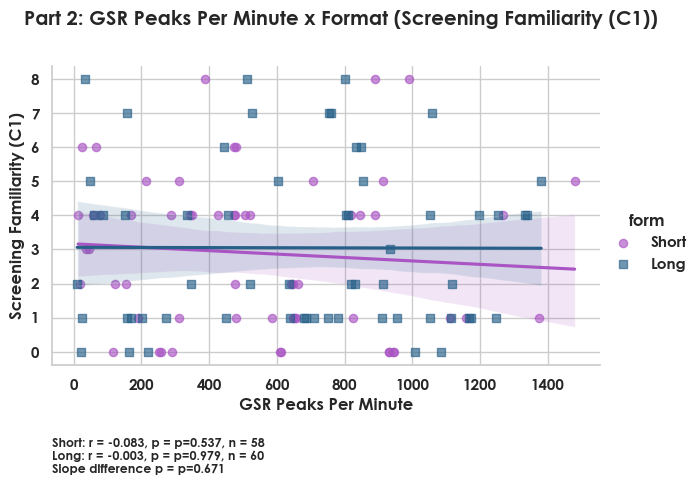

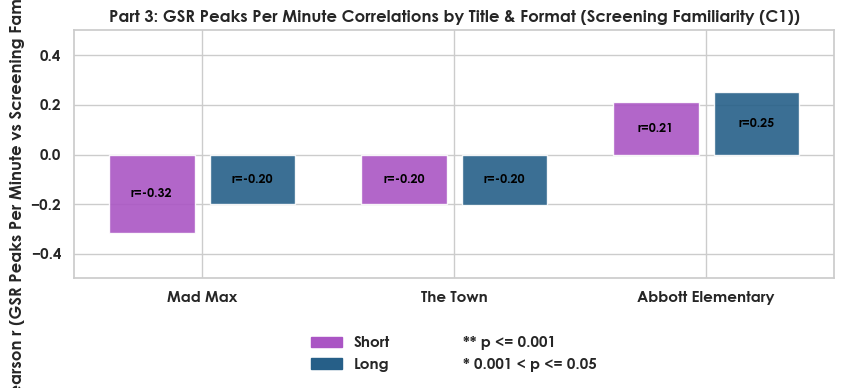

In [91]:
run_three_part_section(
    metric_label=BIOMETRIC_EXTENSION["gsr_peaks"]["label"],
    metric_df=BIOMETRIC_EXTENSION["gsr_peaks"]["frame"],
    metric_columns=BIOMETRIC_EXTENSION["gsr_peaks"]["columns"],
    outcome_df=familiarity_c1,
    outcome_column="familiarity_c1",
    outcome_label="Screening Familiarity (C1)",
    section_label="GSR Peaks Ã— Familiarity",
    merge_validate="many_to_one",
    line_color=BIOMETRIC_EXTENSION["gsr_peaks"]["line_color"],
)

### Section: GSR Peaks Ã— Recall
Recall pooling for the GSR signal.

GSR Peaks Per Minute: n=117, respondents=66, titles=3


#### Part 1: Overall GSR Peaks Ã— Recall

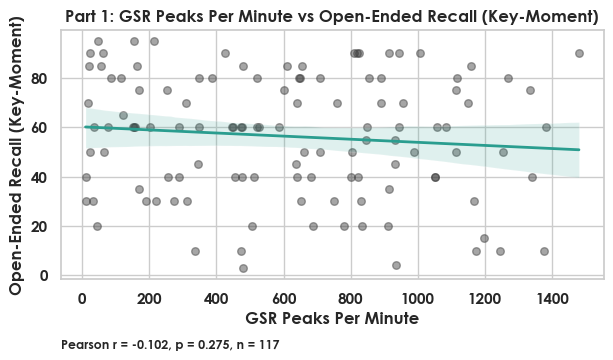

Metric stat  Pearson r  p-value    n
0   PERMINUTE  -0.101815  p=0.275  117

Part 1 - GSR Peaks Per Minute x Open-Ended Recall (Key-Moment): Long form (5115%) showed 1074% lower than short form (6189%) (Pearson r=-0.102, p=0.275, n=117).


#### Part 2: Format-Specific GSR Peaks Ã— Recall

=== GSR Peaks Per Minute - Format Diagnostics (Open-Ended Recall (Key-Moment)) ===


sum_sq     df         F    PR(>F)
C(form)                2931.100625    1.0  5.126557  0.025470
metric_value            278.492546    1.0  0.487089  0.486662
metric_value:C(form)   1394.959555    1.0  2.439814  0.121087
Residual              64607.566320  113.0       NaN       NaN

Part 2 - GSR Peaks Per Minute x Open-Ended Recall (Key-Moment): Long form (5115%) showed 1074% lower than short form (6189%) (Interaction p=p=0.121).


#### Part 3: Title-Level GSR Peaks Ã— Recall

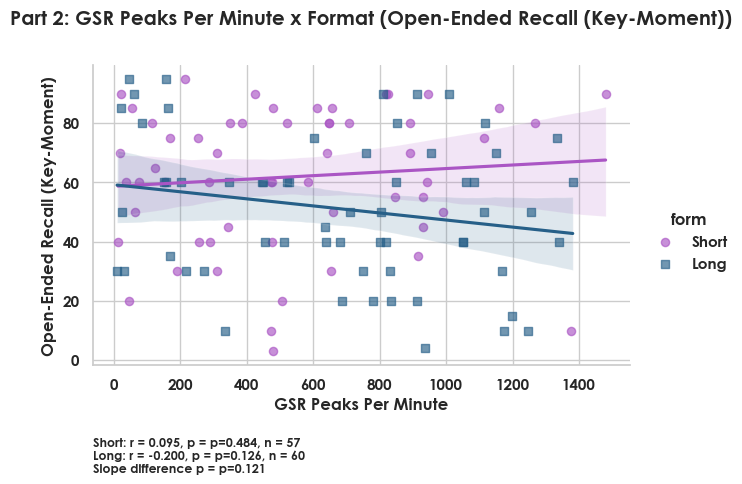

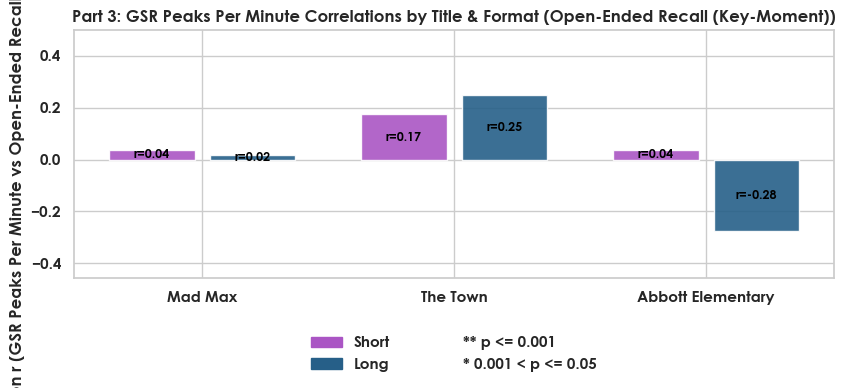

In [92]:
run_three_part_section(
    metric_label=BIOMETRIC_EXTENSION["gsr_peaks"]["label"],
    metric_df=BIOMETRIC_EXTENSION["gsr_peaks"]["frame"],
    metric_columns=BIOMETRIC_EXTENSION["gsr_peaks"]["columns"],
    outcome_df=recall_long_combined,
    outcome_column="recall_value",
    outcome_label=RECALL_COMBINED_LABEL,
    section_label="GSR Peaks Ã— Recall",
    merge_validate="one_to_many",
    line_color=BIOMETRIC_EXTENSION["gsr_peaks"]["line_color"],
)

## Metric: ET Blink Rate
Apply the same correlations to blink rate.

### Section: ET Blink Rate Ã— Enjoyment
Blink rate vs enjoyment.

ET Blink Rate: n=137, respondents=69, titles=3


#### Part 1: Overall ET Blink Rate Ã— Enjoyment

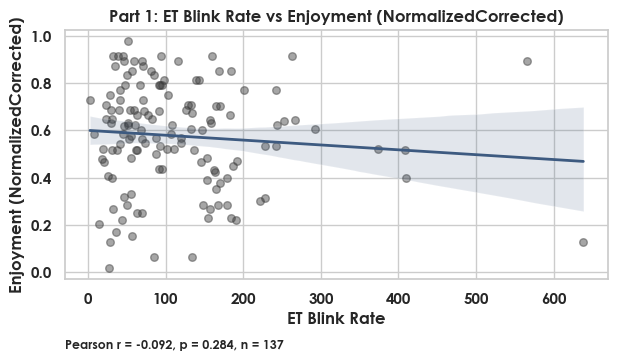

Metric stat  Pearson r  p-value    n
0        RATE  -0.092165  p=0.284  137

Part 1 â€” ET Blink Rate Ã— Enjoyment (NormalizedCorrected): Long form (68%) showed 20% greater than short form (48%) (Pearson r=-0.092, p=0.284, n=137).


#### Part 2: Format-Specific ET Blink Rate Ã— Enjoyment

=== ET Blink Rate â€” Format Diagnostics (Enjoyment (NormalizedCorrected)) ===


sum_sq     df          F        PR(>F)
C(form)               1.453130    1.0  38.683864  6.011471e-09
metric_value          0.132869    1.0   3.537114  6.219638e-02
metric_value:C(form)  0.104478    1.0   2.781304  9.772337e-02
Residual              4.996043  133.0        NaN           NaN

Part 2 â€” ET Blink Rate Ã— Enjoyment (NormalizedCorrected): Long form (68%) showed 20% greater than short form (48%) (Interaction p=p=0.098).


#### Part 2.1: Format-Specific per title ET Blink Rate Ã— Enjoyment

=== ET Blink Rate â€” Format Diagnostics (Enjoyment (NormalizedCorrected)) ===


sum_sq    df          F    PR(>F)
C(form)               0.470276   1.0  25.738700  0.000011
metric_value          0.003326   1.0   0.182061  0.672080
metric_value:C(form)  0.027640   1.0   1.512778  0.226479
Residual              0.676034  37.0        NaN       NaN

Part 2.1 â€” ET Blink Rate Ã— Enjoyment (NormalizedCorrected): Long form (77%) showed 22% greater than short form (56%) (Interaction p=p=0.226).


#### Part 3: Title-Level ET Blink Rate Ã— Enjoyment

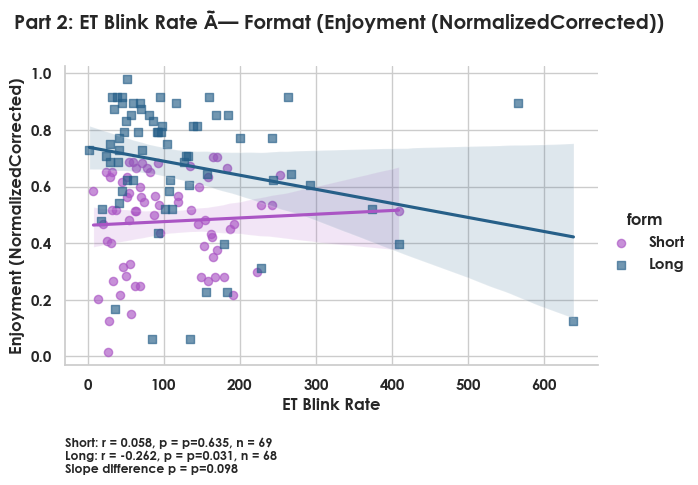

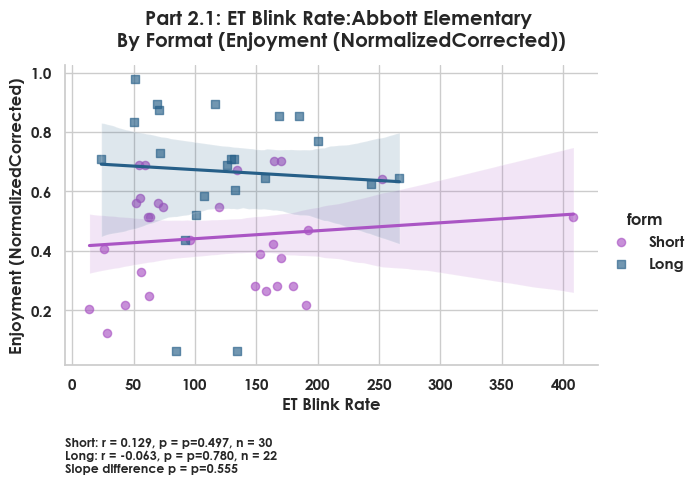

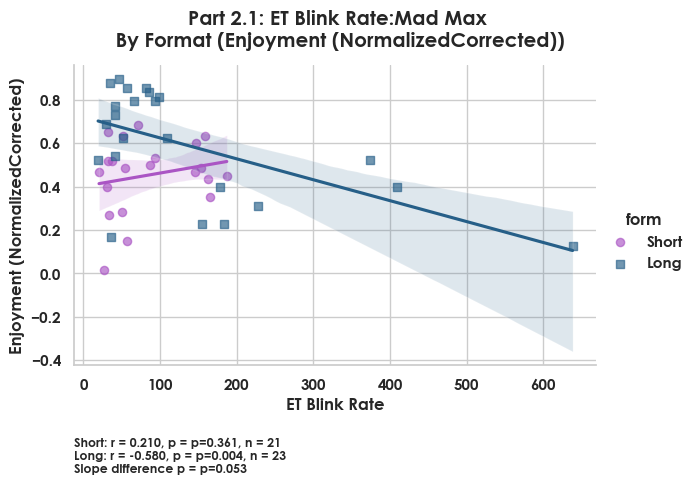

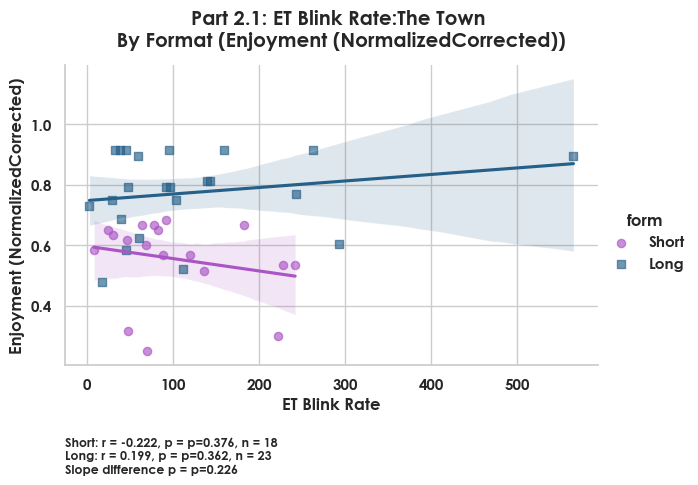

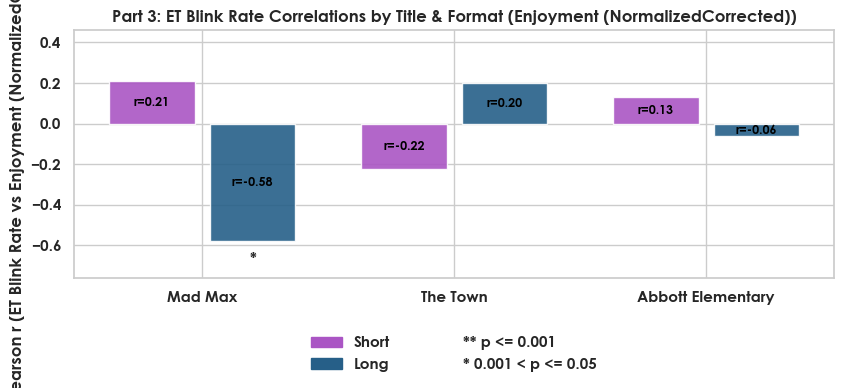

In [93]:
run_three_part_section2(
    metric_label=BIOMETRIC_EXTENSION["et_blink"]["label"],
    metric_df=BIOMETRIC_EXTENSION["et_blink"]["frame"],
    metric_columns=BIOMETRIC_EXTENSION["et_blink"]["columns"],
    outcome_df=enjoyment_norm,
    outcome_column="enjoyment_norm",
    outcome_label="Enjoyment (NormalizedCorrected)",
    section_label="ET Blink Rate Ã— Enjoyment",
    merge_validate="many_to_one",
    line_color=BIOMETRIC_EXTENSION["et_blink"]["line_color"],
)

### Section: ET Blink Rate Ã— Familiarity
Blink rate vs familiarity.

ET Blink Rate: n=138, respondents=69, titles=3


#### Part 1: Overall ET Blink Rate Ã— Familiarity

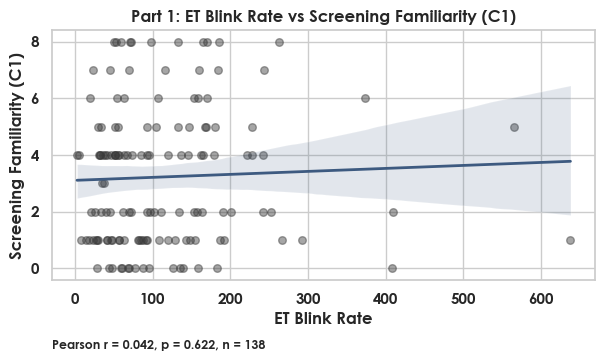

Metric stat  Pearson r  p-value    n
0        RATE    0.04231  p=0.622  138

Part 1 - ET Blink Rate x Screening Familiarity (C1): Long form (330%) showed 16% greater than short form (314%) (Pearson r=0.042, p=0.622, n=138).


#### Part 2: Format-Specific ET Blink Rate Ã— Familiarity

=== ET Blink Rate - Format Diagnostics (Screening Familiarity (C1)) ===


sum_sq     df         F    PR(>F)
C(form)                 0.674845    1.0  0.110560  0.740027
metric_value            1.269610    1.0  0.208001  0.649077
metric_value:C(form)    1.973753    1.0  0.323362  0.570546
Residual              817.916058  134.0       NaN       NaN

Part 2 - ET Blink Rate x Screening Familiarity (C1): Long form (330%) showed 16% greater than short form (314%) (Interaction p=p=0.571).


#### Part 3: Title-Level ET Blink Rate Ã— Familiarity

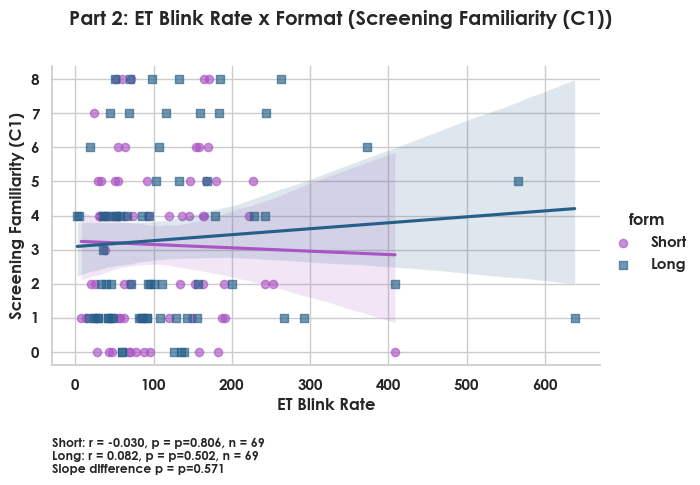

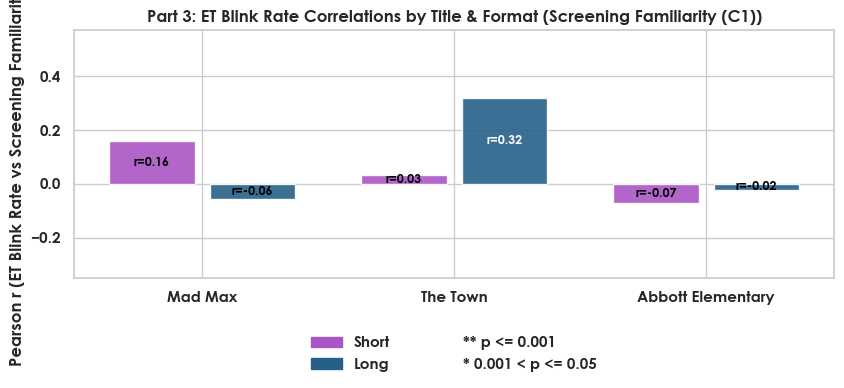

In [94]:
run_three_part_section(
    metric_label=BIOMETRIC_EXTENSION["et_blink"]["label"],
    metric_df=BIOMETRIC_EXTENSION["et_blink"]["frame"],
    metric_columns=BIOMETRIC_EXTENSION["et_blink"]["columns"],
    outcome_df=familiarity_c1,
    outcome_column="familiarity_c1",
    outcome_label="Screening Familiarity (C1)",
    section_label="ET Blink Rate Ã— Familiarity",
    merge_validate="many_to_one",
    line_color=BIOMETRIC_EXTENSION["et_blink"]["line_color"],
)

### Section: ET Blink Rate Ã— Recall
Blink rate vs pooled recall.

ET Blink Rate: n=135, respondents=69, titles=3


#### Part 1: Overall ET Blink Rate Ã— Recall

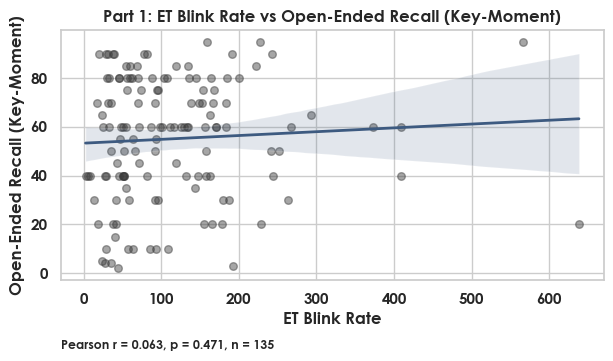

Metric stat  Pearson r  p-value    n
0        RATE   0.062548  p=0.471  135

Part 1 - ET Blink Rate x Open-Ended Recall (Key-Moment): Long form (5090%) showed 854% lower than short form (5943%) (Pearson r=0.063, p=0.471, n=135).


#### Part 2: Format-Specific ET Blink Rate Ã— Recall

=== ET Blink Rate - Format Diagnostics (Open-Ended Recall (Key-Moment)) ===


sum_sq     df         F    PR(>F)
C(form)                2647.607235    1.0  4.305419  0.039948
metric_value            515.745843    1.0  0.838682  0.361457
metric_value:C(form)     54.834699    1.0  0.089170  0.765709
Residual              80558.146632  131.0       NaN       NaN

Part 2 - ET Blink Rate x Open-Ended Recall (Key-Moment): Long form (5090%) showed 854% lower than short form (5943%) (Interaction p=p=0.766).


#### Part 3: Title-Level ET Blink Rate Ã— Recall

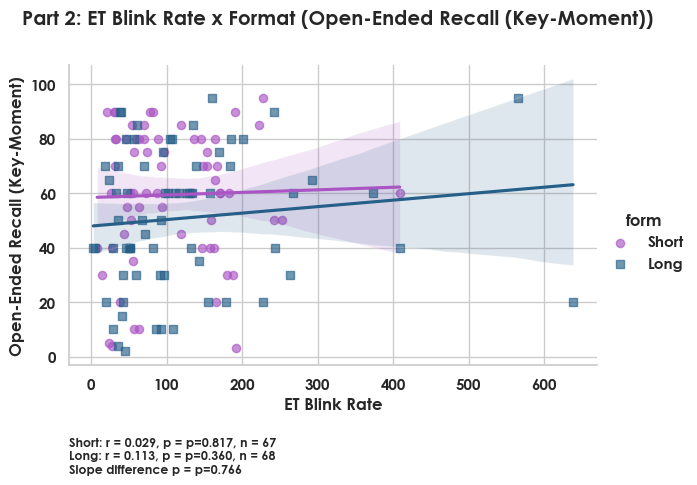

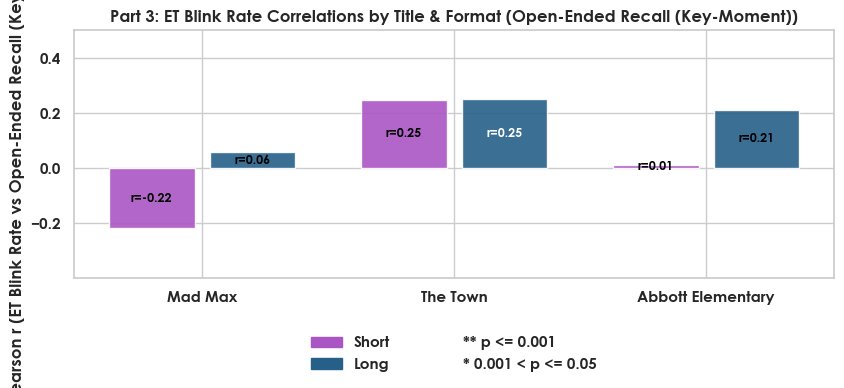

In [95]:
run_three_part_section(
    metric_label=BIOMETRIC_EXTENSION["et_blink"]["label"],
    metric_df=BIOMETRIC_EXTENSION["et_blink"]["frame"],
    metric_columns=BIOMETRIC_EXTENSION["et_blink"]["columns"],
    outcome_df=recall_long_combined,
    outcome_column="recall_value",
    outcome_label=RECALL_COMBINED_LABEL,
    section_label="ET Blink Rate Ã— Recall",
    merge_validate="one_to_many",
    line_color=BIOMETRIC_EXTENSION["et_blink"]["line_color"],
)

## Metric: ET Fixation Dispersion Mean
Replicate the three sections for fixation dispersion.

### Section: ET Fixation Dispersion Ã— Enjoyment
Dispersion vs enjoyment.

ET Fixation Dispersion Mean: n=163, respondents=82, titles=3


#### Part 1: Overall ET Fixation Dispersion Ã— Enjoyment

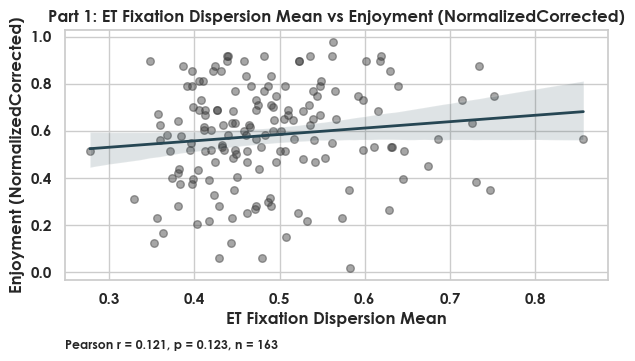

Metric stat  Pearson r  p-value    n
0        MEAN   0.121353  p=0.123  163

Part 1 â€” ET Fixation Dispersion Mean Ã— Enjoyment (NormalizedCorrected): Long form (68%) showed 20% greater than short form (48%) (Pearson r=0.121, p=0.123, n=163).


#### Part 2: Format-Specific ET Fixation Dispersion Ã— Enjoyment

=== ET Fixation Dispersion Mean â€” Format Diagnostics (Enjoyment (NormalizedCorrected)) ===


sum_sq     df          F        PR(>F)
C(form)               1.626858    1.0  46.748141  1.638590e-10
metric_value          0.156470    1.0   4.496203  3.552178e-02
metric_value:C(form)  0.192400    1.0   5.528669  1.993353e-02
Residual              5.533279  159.0        NaN           NaN

Part 2 â€” ET Fixation Dispersion Mean Ã— Enjoyment (NormalizedCorrected): Long form (68%) showed 20% greater than short form (48%) (Interaction p=p=0.020).


#### Part 2.1: Format-Specific per title ET Fixation Dispersion Ã— Enjoyment

=== ET Fixation Dispersion Mean â€” Format Diagnostics (Enjoyment (NormalizedCorrected)) ===


sum_sq    df          F        PR(>F)
C(form)               0.675462   1.0  42.434950  3.454050e-08
metric_value          0.000662   1.0   0.041611  8.391904e-01
metric_value:C(form)  0.000599   1.0   0.037656  8.469212e-01
Residual              0.795879  50.0        NaN           NaN

Part 2.1 â€” ET Fixation Dispersion Mean Ã— Enjoyment (NormalizedCorrected): Long form (78%) showed 23% greater than short form (55%) (Interaction p=p=0.847).


#### Part 3: Title-Level ET Fixation Dispersion Ã— Enjoyment

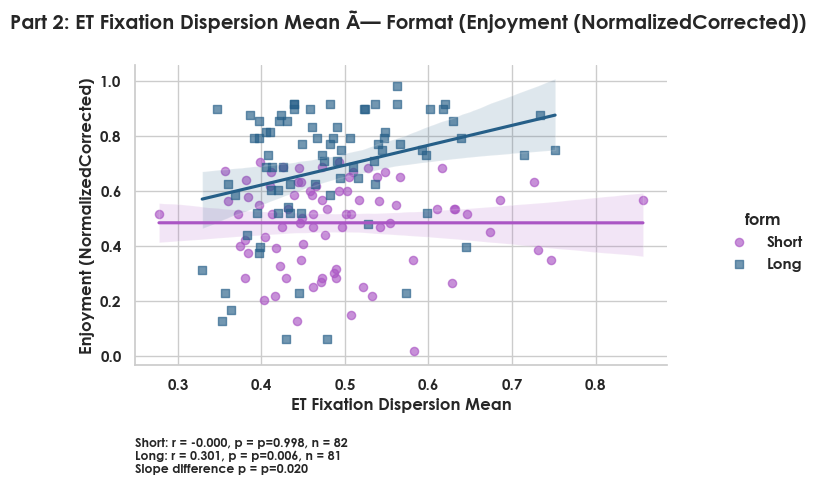

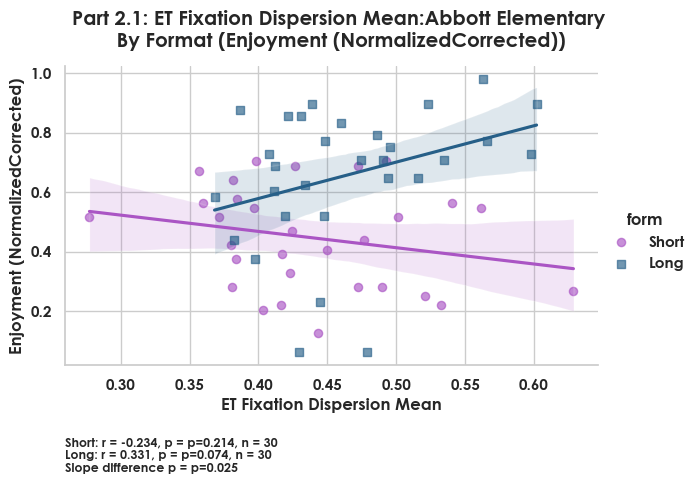

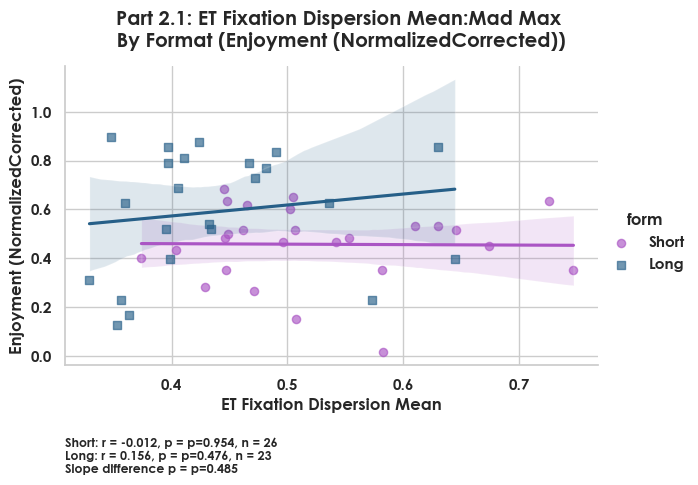

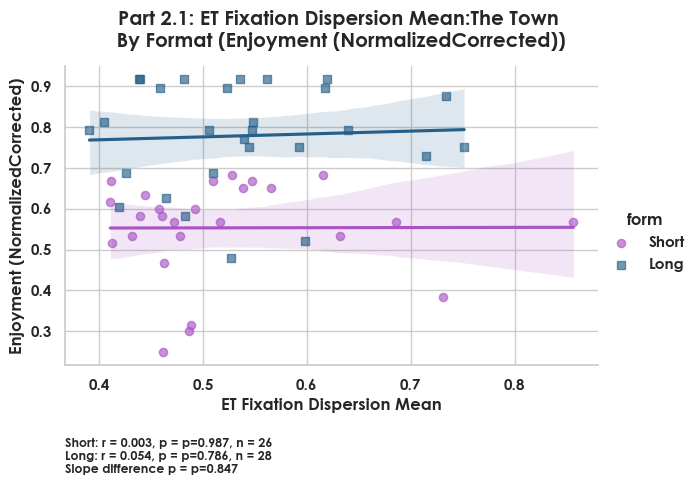

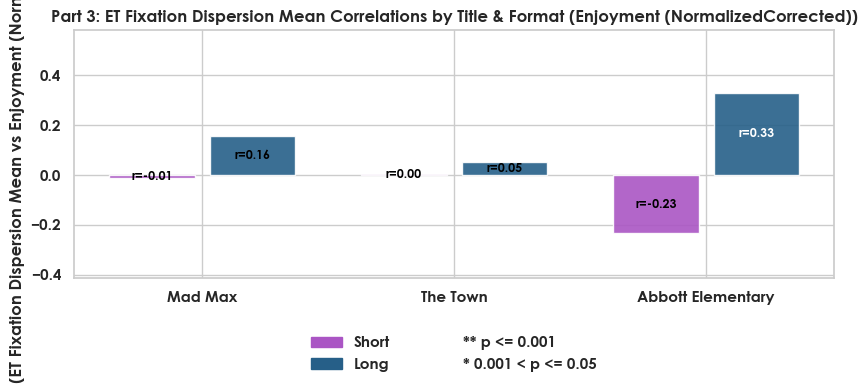

In [96]:
run_three_part_section2(
    metric_label=BIOMETRIC_EXTENSION["et_fixation"]["label"],
    metric_df=BIOMETRIC_EXTENSION["et_fixation"]["frame"],
    metric_columns=BIOMETRIC_EXTENSION["et_fixation"]["columns"],
    outcome_df=enjoyment_norm,
    outcome_column="enjoyment_norm",
    outcome_label="Enjoyment (NormalizedCorrected)",
    section_label="ET Fixation Dispersion Ã— Enjoyment",
    merge_validate="many_to_one",
    line_color=BIOMETRIC_EXTENSION["et_fixation"]["line_color"],
)

### Section: ET Fixation Dispersion Ã— Familiarity
Dispersion vs familiarity.

ET Fixation Dispersion Mean: n=164, respondents=82, titles=3


#### Part 1: Overall ET Fixation Dispersion Ã— Familiarity

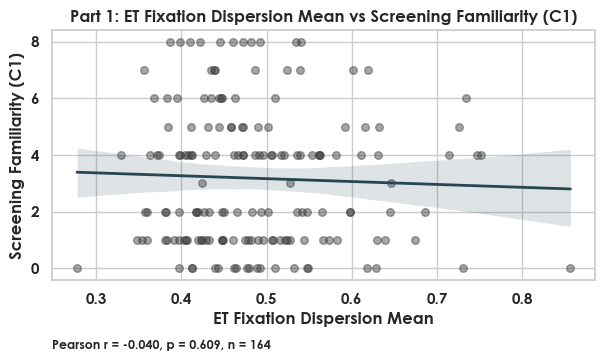

Metric stat  Pearson r  p-value    n
0        MEAN  -0.040269  p=0.609  164

Part 1 - ET Fixation Dispersion Mean x Screening Familiarity (C1): Long form (327%) showed 18% greater than short form (309%) (Pearson r=-0.040, p=0.609, n=164).


#### Part 2: Format-Specific ET Fixation Dispersion Ã— Familiarity

=== ET Fixation Dispersion Mean - Format Diagnostics (Screening Familiarity (C1)) ===


sum_sq     df         F    PR(>F)
C(form)                 1.237608    1.0  0.207765  0.649143
metric_value            1.415712    1.0  0.237665  0.626565
metric_value:C(form)    0.002261    1.0  0.000380  0.984481
Residual              953.082027  160.0       NaN       NaN

Part 2 - ET Fixation Dispersion Mean x Screening Familiarity (C1): Long form (327%) showed 18% greater than short form (309%) (Interaction p=p=0.984).


#### Part 3: Title-Level ET Fixation Dispersion Ã— Familiarity

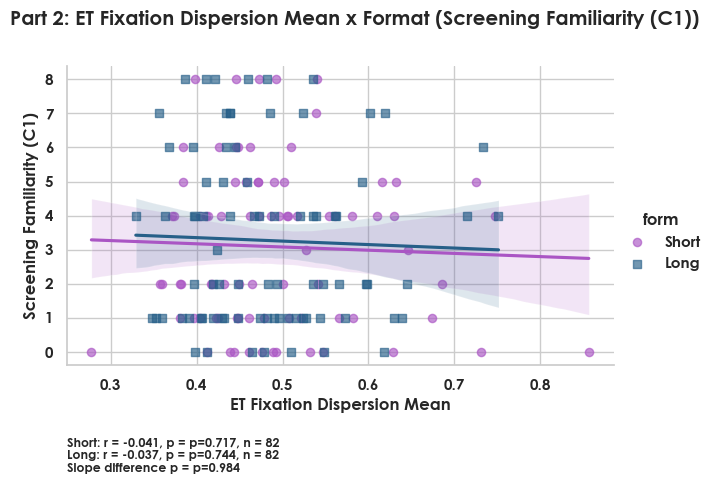

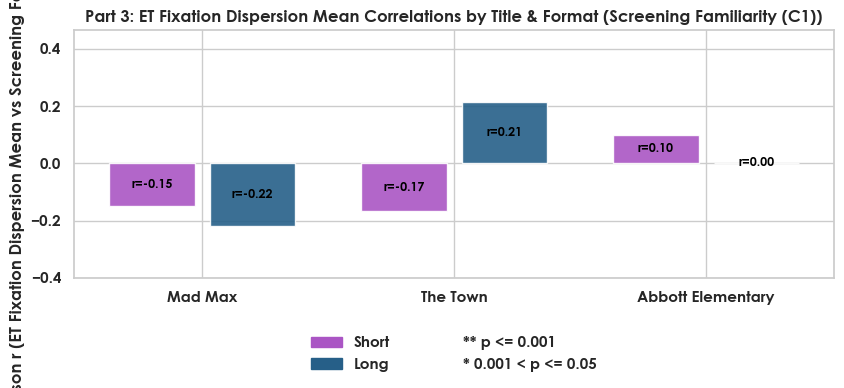

In [97]:
run_three_part_section(
    metric_label=BIOMETRIC_EXTENSION["et_fixation"]["label"],
    metric_df=BIOMETRIC_EXTENSION["et_fixation"]["frame"],
    metric_columns=BIOMETRIC_EXTENSION["et_fixation"]["columns"],
    outcome_df=familiarity_c1,
    outcome_column="familiarity_c1",
    outcome_label="Screening Familiarity (C1)",
    section_label="ET Fixation Dispersion Ã— Familiarity",
    merge_validate="many_to_one",
    line_color=BIOMETRIC_EXTENSION["et_fixation"]["line_color"],
)

### Section: ET Fixation Dispersion Ã— Recall
Dispersion vs pooled recall.

ET Fixation Dispersion Mean: n=161, respondents=82, titles=3


#### Part 1: Overall ET Fixation Dispersion Ã— Recall

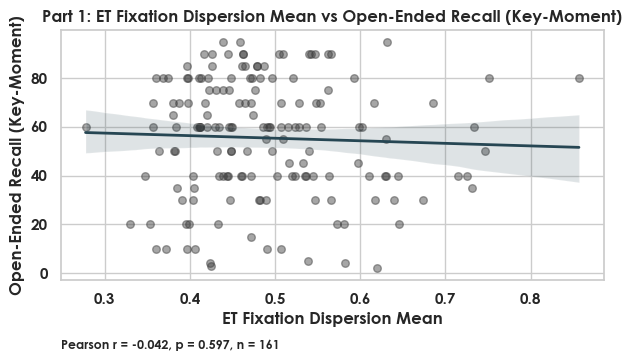

Metric stat  Pearson r  p-value    n
0        MEAN  -0.041976  p=0.597  161

Part 1 - ET Fixation Dispersion Mean x Open-Ended Recall (Key-Moment): Long form (5162%) showed 778% lower than short form (5940%) (Pearson r=-0.042, p=0.597, n=161).


#### Part 2: Format-Specific ET Fixation Dispersion Ã— Recall

=== ET Fixation Dispersion Mean - Format Diagnostics (Open-Ended Recall (Key-Moment)) ===


sum_sq     df         F    PR(>F)
C(form)                2487.681038    1.0  4.339062  0.038868
metric_value            214.116360    1.0  0.373466  0.542005
metric_value:C(form)    588.627255    1.0  1.026695  0.312495
Residual              90011.592187  157.0       NaN       NaN

Part 2 - ET Fixation Dispersion Mean x Open-Ended Recall (Key-Moment): Long form (5162%) showed 778% lower than short form (5940%) (Interaction p=p=0.312).


#### Part 3: Title-Level ET Fixation Dispersion Ã— Recall

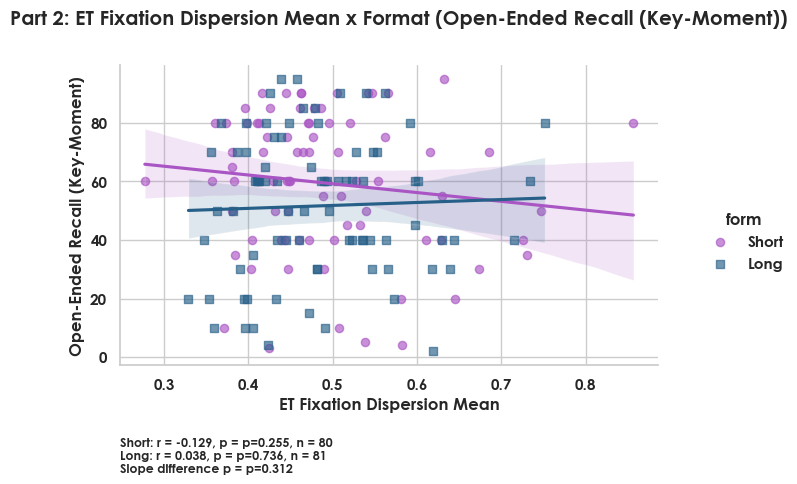

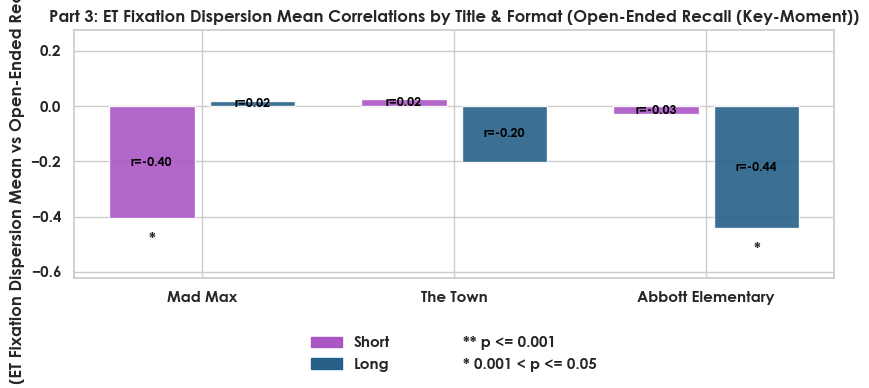

In [98]:
run_three_part_section(
    metric_label=BIOMETRIC_EXTENSION["et_fixation"]["label"],
    metric_df=BIOMETRIC_EXTENSION["et_fixation"]["frame"],
    metric_columns=BIOMETRIC_EXTENSION["et_fixation"]["columns"],
    outcome_df=recall_long_combined,
    outcome_column="recall_value",
    outcome_label=RECALL_COMBINED_LABEL,
    section_label="ET Fixation Dispersion Ã— Recall",
    merge_validate="one_to_many",
    line_color=BIOMETRIC_EXTENSION["et_fixation"]["line_color"],
)

## Metric: EEG Distraction AUC
Finish with the EEG Distraction channel.

### Section: EEG Distraction Ã— Enjoyment
EEG distraction correlations vs enjoyment.

EEG Distraction AUC: n=120, respondents=61, titles=3


#### Part 1: Overall EEG Distraction Ã— Enjoyment

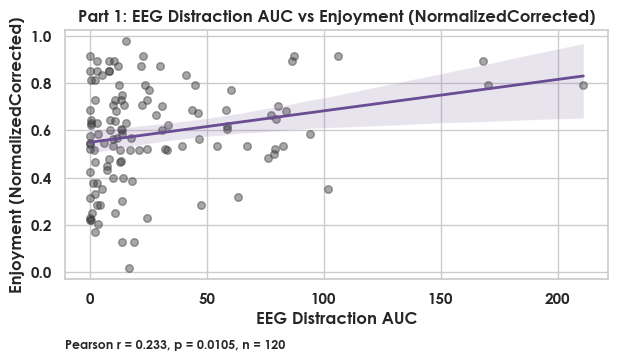

Metric stat  Pearson r  p-value    n
0         AUC   0.232756  p=0.011  120

Part 1 - EEG Distraction AUC x Enjoyment (NormalizedCorrected): Long form (69%) showed 20% greater than short form (49%) (Pearson r=0.233, p=0.011, n=120).


#### Part 2: Format-Specific EEG Distraction Ã— Enjoyment

=== EEG Distraction AUC - Format Diagnostics (Enjoyment (NormalizedCorrected)) ===


sum_sq     df          F        PR(>F)
C(form)               1.202649    1.0  36.640887  1.791888e-08
metric_value          0.265850    1.0   8.099604  5.236621e-03
metric_value:C(form)  0.007232    1.0   0.220323  6.396747e-01
Residual              3.807420  116.0        NaN           NaN

Part 2 - EEG Distraction AUC x Enjoyment (NormalizedCorrected): Long form (69%) showed 20% greater than short form (49%) (Interaction p=p=0.640).


#### Part 3: Title-Level EEG Distraction Ã— Enjoyment

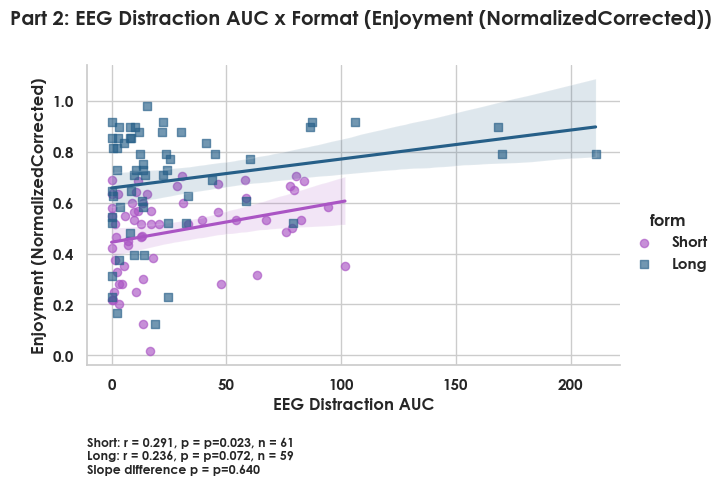

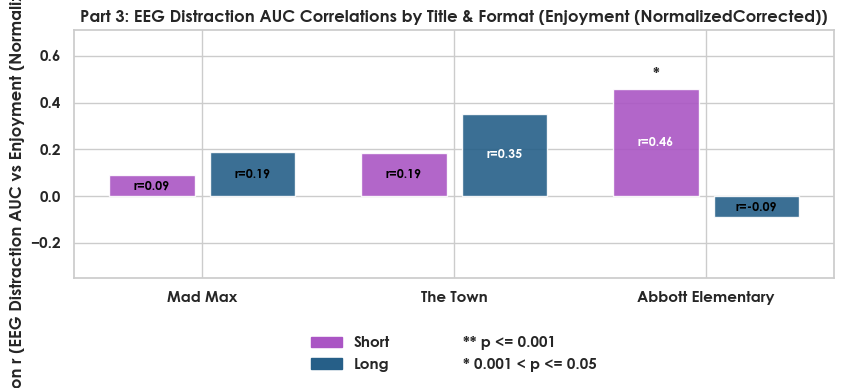

In [99]:
run_three_part_section(
    metric_label=BIOMETRIC_EXTENSION["eeg_distraction"]["label"],
    metric_df=BIOMETRIC_EXTENSION["eeg_distraction"]["frame"],
    metric_columns=BIOMETRIC_EXTENSION["eeg_distraction"]["columns"],
    outcome_df=enjoyment_norm,
    outcome_column="enjoyment_norm",
    outcome_label="Enjoyment (NormalizedCorrected)",
    section_label="EEG Distraction Ã— Enjoyment",
    merge_validate="many_to_one",
    line_color=BIOMETRIC_EXTENSION["eeg_distraction"]["line_color"],
)

### Section: EEG Distraction Ã— Familiarity
EEG distraction vs familiarity.

EEG Distraction AUC: n=121, respondents=61, titles=3


#### Part 1: Overall EEG Distraction Ã— Familiarity

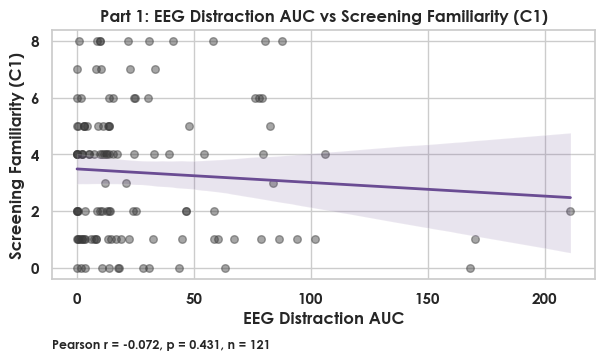

Metric stat  Pearson r  p-value    n
0         AUC  -0.072253  p=0.431  121

Part 1 - EEG Distraction AUC x Screening Familiarity (C1): Long form (362%) showed 52% greater than short form (310%) (Pearson r=-0.072, p=0.431, n=121).


#### Part 2: Format-Specific EEG Distraction Ã— Familiarity

=== EEG Distraction AUC - Format Diagnostics (Screening Familiarity (C1)) ===


sum_sq     df         F    PR(>F)
C(form)                 8.260723    1.0  1.396976  0.239627
metric_value            3.860890    1.0  0.652918  0.420711
metric_value:C(form)    9.877567    1.0  1.670402  0.198751
Residual              691.854712  117.0       NaN       NaN

Part 2 - EEG Distraction AUC x Screening Familiarity (C1): Long form (362%) showed 52% greater than short form (310%) (Interaction p=p=0.199).


#### Part 3: Title-Level EEG Distraction Ã— Familiarity

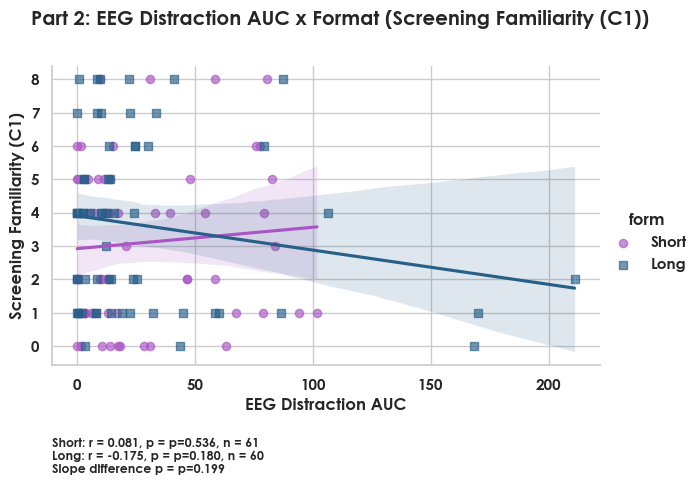

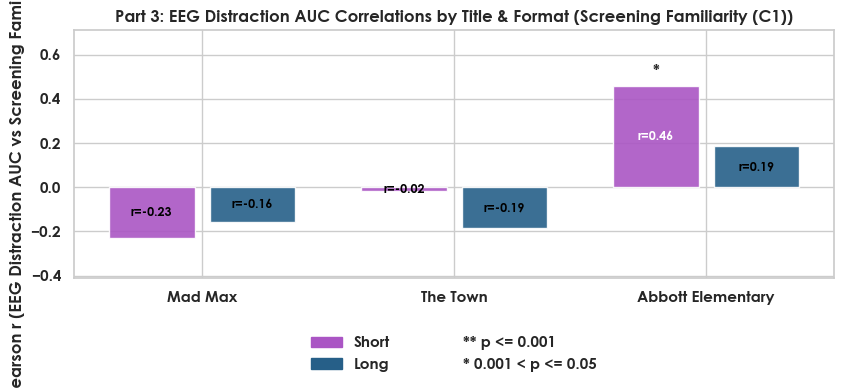

In [100]:
run_three_part_section(
    metric_label=BIOMETRIC_EXTENSION["eeg_distraction"]["label"],
    metric_df=BIOMETRIC_EXTENSION["eeg_distraction"]["frame"],
    metric_columns=BIOMETRIC_EXTENSION["eeg_distraction"]["columns"],
    outcome_df=familiarity_c1,
    outcome_column="familiarity_c1",
    outcome_label="Screening Familiarity (C1)",
    section_label="EEG Distraction Ã— Familiarity",
    merge_validate="many_to_one",
    line_color=BIOMETRIC_EXTENSION["eeg_distraction"]["line_color"],
)

### Section: EEG Distraction Ã— Recall
EEG distraction vs pooled recall.

EEG Distraction AUC: n=121, respondents=61, titles=3


#### Part 1: Overall EEG Distraction Ã— Recall

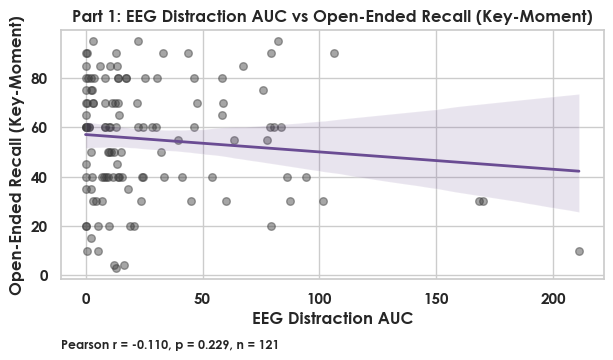

Metric stat  Pearson r  p-value    n
0         AUC  -0.110168  p=0.229  121

Part 1 - EEG Distraction AUC x Open-Ended Recall (Key-Moment): Long form (5056%) showed 923% lower than short form (5978%) (Pearson r=-0.110, p=0.229, n=121).


#### Part 2: Format-Specific EEG Distraction Ã— Recall

=== EEG Distraction AUC - Format Diagnostics (Open-Ended Recall (Key-Moment)) ===


sum_sq     df         F    PR(>F)
C(form)                2555.295643    1.0  4.839789  0.029775
metric_value            789.625332    1.0  1.495569  0.223812
metric_value:C(form)   1516.340119    1.0  2.871983  0.092794
Residual              61773.267062  117.0       NaN       NaN

Part 2 - EEG Distraction AUC x Open-Ended Recall (Key-Moment): Long form (5056%) showed 923% lower than short form (5978%) (Interaction p=p=0.093).


#### Part 3: Title-Level EEG Distraction Ã— Recall

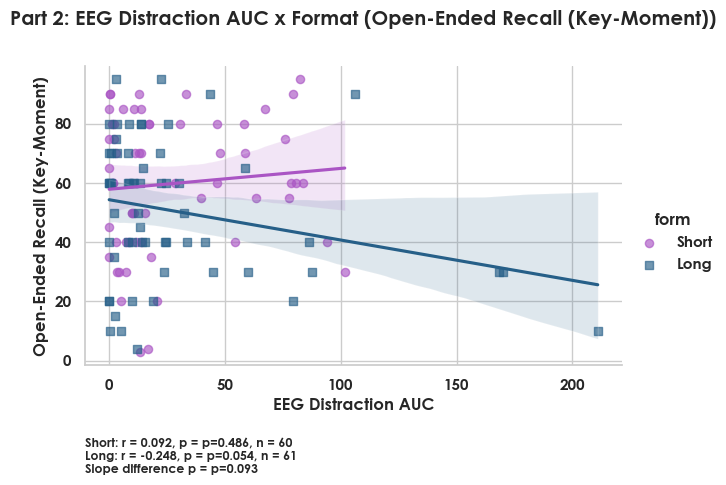

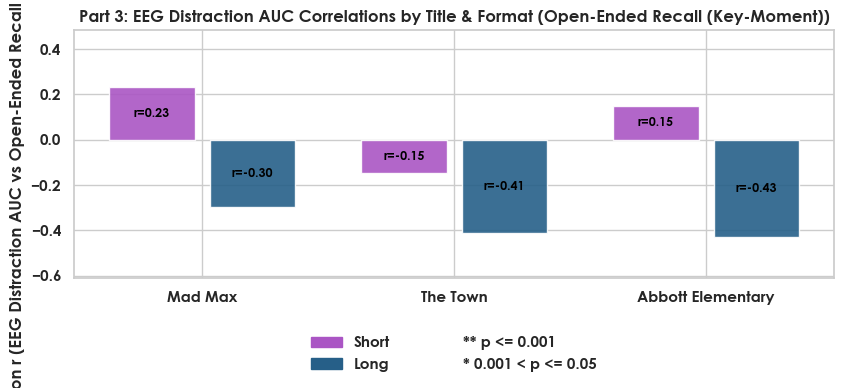

In [101]:
run_three_part_section(
    metric_label=BIOMETRIC_EXTENSION["eeg_distraction"]["label"],
    metric_df=BIOMETRIC_EXTENSION["eeg_distraction"]["frame"],
    metric_columns=BIOMETRIC_EXTENSION["eeg_distraction"]["columns"],
    outcome_df=recall_long_combined,
    outcome_column="recall_value",
    outcome_label=RECALL_COMBINED_LABEL,
    section_label="EEG Distraction Ã— Recall",
    merge_validate="one_to_many",
    line_color=BIOMETRIC_EXTENSION["eeg_distraction"]["line_color"],
)

## Metric: EEG High Engagement AUC
Mirror the automated three-part workflow for the High Engagement channel.

### Section: EEG High Engagement Ã— Enjoyment
Stage 2 enjoyment correlations.

EEG High Engagement AUC: n=120, respondents=61, titles=3


#### Part 1: Overall EEG High Engagement Ã— Enjoyment

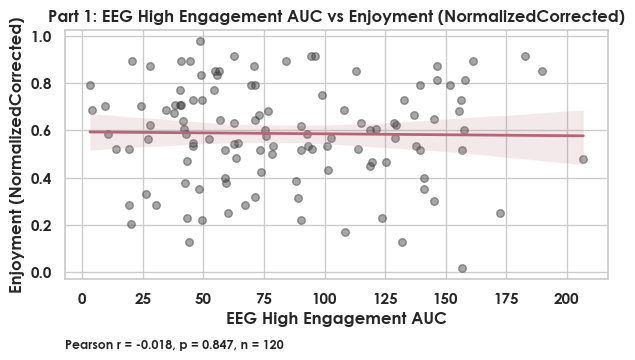

Metric stat  Pearson r  p-value    n
0         AUC  -0.017836  p=0.847  120

Part 1 - EEG High Engagement AUC x Enjoyment (NormalizedCorrected): Long form (69%) showed 20% greater than short form (49%) (Pearson r=-0.018, p=0.847, n=120).


#### Part 2: Format-Specific EEG High Engagement Ã— Enjoyment

=== EEG High Engagement AUC - Format Diagnostics (Enjoyment (NormalizedCorrected)) ===


sum_sq     df          F        PR(>F)
C(form)               1.227890    1.0  34.955062  3.470359e-08
metric_value          0.005395    1.0   0.153572  6.958638e-01
metric_value:C(form)  0.000297    1.0   0.008448  9.269268e-01
Residual              4.074810  116.0        NaN           NaN

Part 2 - EEG High Engagement AUC x Enjoyment (NormalizedCorrected): Long form (69%) showed 20% greater than short form (49%) (Interaction p=p=0.927).


#### Part 3: Title-Level EEG High Engagement Ã— Enjoyment

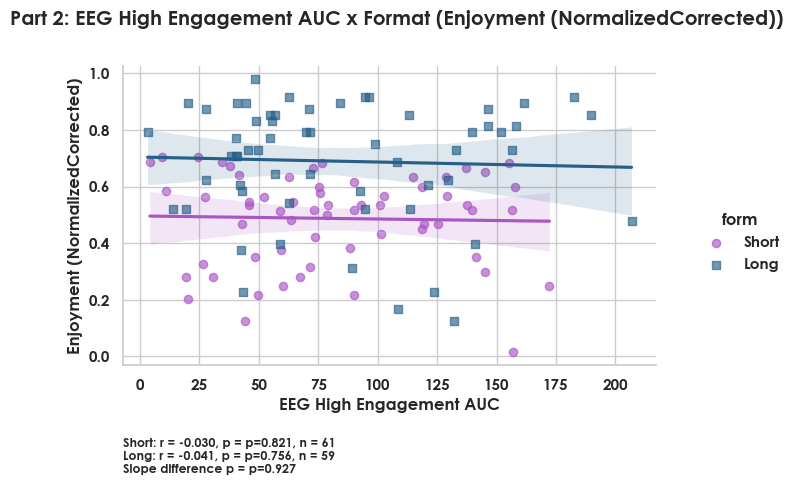

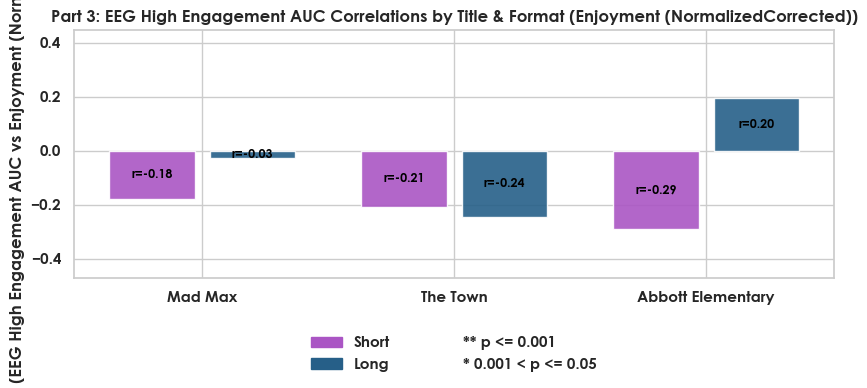

In [102]:
run_three_part_section(
    metric_label=BIOMETRIC_EXTENSION["eeg_high_engagement"]["label"],
    metric_df=BIOMETRIC_EXTENSION["eeg_high_engagement"]["frame"],
    metric_columns=BIOMETRIC_EXTENSION["eeg_high_engagement"]["columns"],
    outcome_df=enjoyment_norm,
    outcome_column="enjoyment_norm",
    outcome_label="Enjoyment (NormalizedCorrected)",
    section_label="EEG High Engagement Ã— Enjoyment",
    merge_validate="many_to_one",
    line_color=BIOMETRIC_EXTENSION["eeg_high_engagement"]["line_color"],
)

### Section: EEG High Engagement Ã— Familiarity
Pairing with Screening Familiarity C1.

EEG High Engagement AUC: n=121, respondents=61, titles=3


#### Part 1: Overall EEG High Engagement Ã— Familiarity

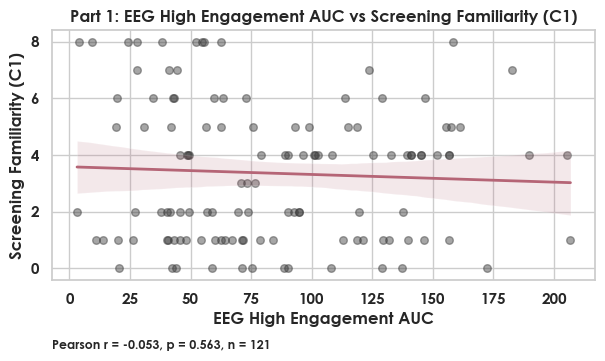

Metric stat  Pearson r  p-value    n
0         AUC  -0.053127  p=0.563  121

Part 1 - EEG High Engagement AUC x Screening Familiarity (C1): Long form (362%) showed 52% greater than short form (310%) (Pearson r=-0.053, p=0.563, n=121).


#### Part 2: Format-Specific EEG High Engagement Ã— Familiarity

=== EEG High Engagement AUC - Format Diagnostics (Screening Familiarity (C1)) ===


sum_sq     df         F    PR(>F)
C(form)                 8.554316    1.0  1.425081  0.234984
metric_value            2.442938    1.0  0.406974  0.524756
metric_value:C(form)    0.835841    1.0  0.139245  0.709708
Residual              702.314390  117.0       NaN       NaN

Part 2 - EEG High Engagement AUC x Screening Familiarity (C1): Long form (362%) showed 52% greater than short form (310%) (Interaction p=p=0.710).


#### Part 3: Title-Level EEG High Engagement Ã— Familiarity

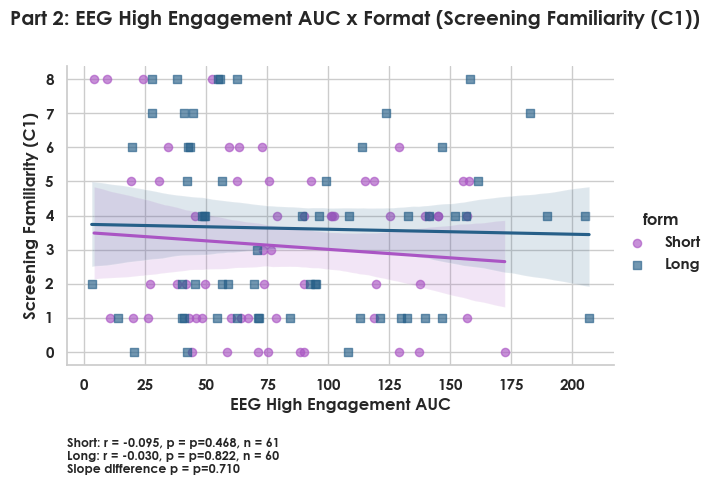

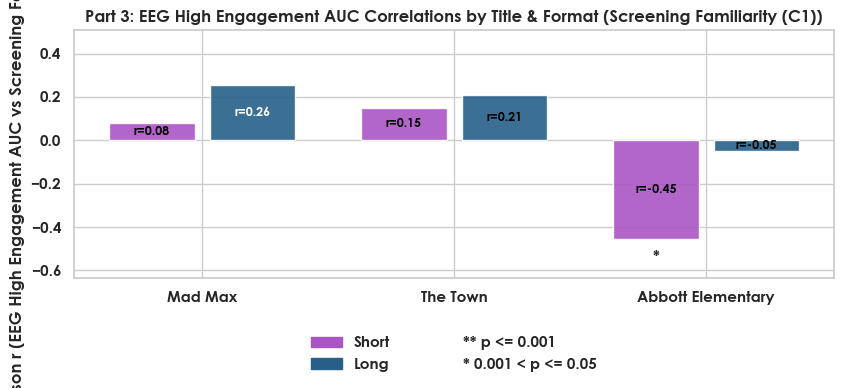

In [103]:
run_three_part_section(
    metric_label=BIOMETRIC_EXTENSION["eeg_high_engagement"]["label"],
    metric_df=BIOMETRIC_EXTENSION["eeg_high_engagement"]["frame"],
    metric_columns=BIOMETRIC_EXTENSION["eeg_high_engagement"]["columns"],
    outcome_df=familiarity_c1,
    outcome_column="familiarity_c1",
    outcome_label="Screening Familiarity (C1)",
    section_label="EEG High Engagement Ã— Familiarity",
    merge_validate="many_to_one",
    line_color=BIOMETRIC_EXTENSION["eeg_high_engagement"]["line_color"],
)

### Section: EEG High Engagement Ã— Recall
Use the pooled Q13/Q18 recall metric.

EEG High Engagement AUC: n=121, respondents=61, titles=3


#### Part 1: Overall EEG High Engagement Ã— Recall

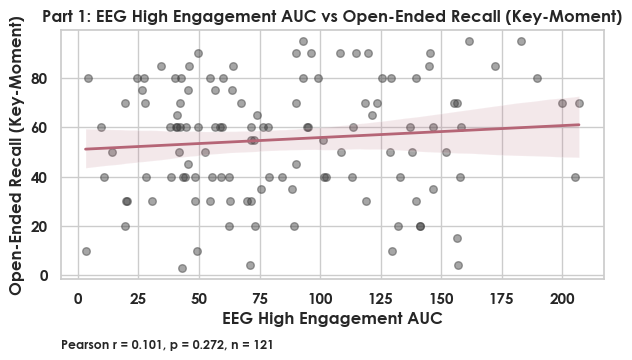

Metric stat  Pearson r  p-value    n
0         AUC   0.100709  p=0.272  121

Part 1 - EEG High Engagement AUC x Open-Ended Recall (Key-Moment): Long form (5056%) showed 923% lower than short form (5978%) (Pearson r=0.101, p=0.272, n=121).


#### Part 2: Format-Specific EEG High Engagement Ã— Recall

=== EEG High Engagement AUC - Format Diagnostics (Open-Ended Recall (Key-Moment)) ===


sum_sq     df         F    PR(>F)
C(form)                2765.469602    1.0  5.139336  0.025226
metric_value            866.837546    1.0  1.610927  0.206881
metric_value:C(form)    254.859215    1.0  0.473629  0.492685
Residual              62957.535754  117.0       NaN       NaN

Part 2 - EEG High Engagement AUC x Open-Ended Recall (Key-Moment): Long form (5056%) showed 923% lower than short form (5978%) (Interaction p=p=0.493).


#### Part 3: Title-Level EEG High Engagement Ã— Recall

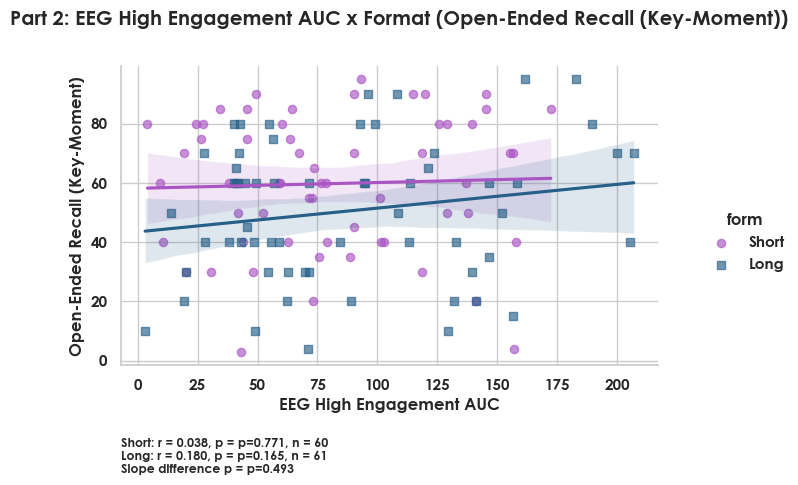

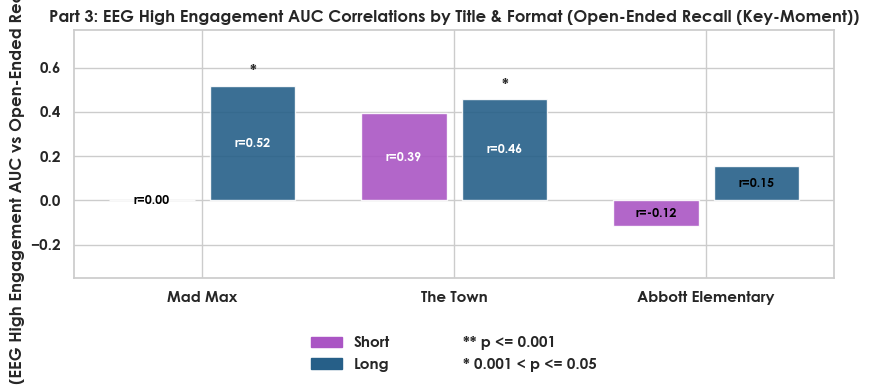

In [104]:
run_three_part_section(
    metric_label=BIOMETRIC_EXTENSION["eeg_high_engagement"]["label"],
    metric_df=BIOMETRIC_EXTENSION["eeg_high_engagement"]["frame"],
    metric_columns=BIOMETRIC_EXTENSION["eeg_high_engagement"]["columns"],
    outcome_df=recall_long_combined,
    outcome_column="recall_value",
    outcome_label=RECALL_COMBINED_LABEL,
    section_label="EEG High Engagement Ã— Recall",
    merge_validate="one_to_many",
    line_color=BIOMETRIC_EXTENSION["eeg_high_engagement"]["line_color"],
)

## Section: Enjoyment Regression Model (Arousal Feel-Good Test)
Link the multi-sensor signals to normalized enjoyment scores to test whether heightened arousal and attention markers predict liking once Short vs Long formats are controlled.

**Model specification**
- Enjoyment ~ GSR Peaks/Minute + EEG Distraction + ET Blink Rate + ET Fixation Dispersion + Format.
- Include interaction terms for GSRÃ—Format and DistractionÃ—Format to see if Long-form edits change those slopes.
- Encode Format as a Short baseline with a Long indicator to keep coefficients interpretable.

**Hypotheses**
1. Higher GSR Peaks/Minute â†’ higher enjoyment (Î”PPM tracks excitement).
2. Higher Blink Rate â†’ lower enjoyment (sustained focus feels better).
3. Higher EEG Distraction â†’ slightly higher enjoyment (pleasurable attentional shifts).
4. Long vs Short formats may moderate the GSR and Distraction slopes.

In [105]:
ENJOYMENT_MODEL_PREDICTORS = {
    "gsr_ppm": ("gsr_peaks", "gsr_peaks_perminute", "GSR Peaks Per Minute"),
    "eeg_distraction": ("eeg_distraction", "eeg_distraction_auc", "EEG Distraction AUC"),
    "blink_rate": ("et_blink", "et_blink_rate", "ET Blink Rate"),
    "fixation_dispersion": ("et_fixation", "et_fixdisp_mean", "ET Fixation Dispersion Mean"),
}

enjoyment_model_data = enjoyment_norm.rename(
    columns={"enjoyment_norm": "enjoyment_score"}
).copy()

for alias, (ext_key, column_name, _) in ENJOYMENT_MODEL_PREDICTORS.items():
    metric_frame = (
        BIOMETRIC_EXTENSION[ext_key]["frame"][BASE_JOIN_KEYS + [column_name]]
        .rename(columns={column_name: alias})
    )
    enjoyment_model_data = enjoyment_model_data.merge(
        metric_frame,
        on=BASE_JOIN_KEYS,
        how="inner",
        validate="one_to_one",
    )

predictor_cols = list(ENJOYMENT_MODEL_PREDICTORS.keys())
enjoyment_model_data = enjoyment_model_data.dropna(
    subset=["enjoyment_score", *predictor_cols]
)

valid_formats = [
    form for form in FORM_ORDER if form in enjoyment_model_data["form"].astype(str).unique()
]
if not valid_formats:
    raise ValueError("Enjoyment regression: no overlapping Short/Long observations detected.")

enjoyment_model_data["form"] = enjoyment_model_data["form"].astype(str)
enjoyment_model_data = enjoyment_model_data.loc[
    enjoyment_model_data["form"].isin(valid_formats)
].copy()
enjoyment_model_data["is_long"] = enjoyment_model_data["form"].eq("Long").astype(int)
enjoyment_model_data["format_label"] = enjoyment_model_data["form"].

format_counts = (
    enjoyment_model_data["format_label"].value_counts().rename_axis("Format").reset_index(name="Rows")
)
coverage_summary = {
    "rows": enjoyment_model_data.shape[0],
    "respondents": enjoyment_model_data["respondent"].nunique(),
    "titles": enjoyment_model_data["title"].nunique(),
}

display(format_counts.style.format({"Rows": "{:,}"}))
print(
    "Enjoyment regression frame:",
    f"rows={coverage_summary['rows']:,}",
    f"respondents={coverage_summary['respondents']:,}",
    f"titles={coverage_summary['titles']:,}",
)

SyntaxError: invalid syntax (1004789979.py, line 40)

In [ ]:
enjoyment_model_formula = (
    "enjoyment_score ~ blink_rate + fixation_dispersion + gsr_ppm + eeg_distraction + "
    "is_long + gsr_ppm:is_long + eeg_distraction:is_long"
)

enjoyment_model_ols = smf.ols(
    enjoyment_model_formula, data=enjoyment_model_data
).fit(cov_type="HC3")

enjoyment_model_mixed = None
mixed_error = None
try:
    enjoyment_model_mixed = smf.mixedlm(
        enjoyment_model_formula,
        data=enjoyment_model_data,
        groups=enjoyment_model_data["respondent"],
        re_formula="1",
    ).fit(reml=False, method="lbfgs", maxiter=200)
except Exception as exc:
    mixed_error = str(exc)

TERM_LABELS = {
    "Intercept": "Intercept (Short form)",
    "gsr_ppm": "GSR Peaks/Minute (Short slope)",
    "eeg_distraction": "EEG Distraction (Short slope)",
    "blink_rate": "ET Blink Rate",
    "fixation_dispersion": "ET Fixation Dispersion",
    "is_long": "Format: Long vs Short (baseline shift)",
    "gsr_ppm:is_long": "Long-form shift in GSR slope",
    "eeg_distraction:is_long": "Long-form shift in Distraction slope",
}

def tidy_result(result, label):
    table = pd.DataFrame({
        "Model": label,
        "Term": result.params.index,
        "Coefficient": result.params.values,
        "Std. Error": result.bse.values,
        "t/z": getattr(result, "tvalues", result.params / result.bse),
        "p_value": result.pvalues.values,
    })
    table["Term"] = table["Term"].astype(str)
    table["Pretty Term"] = table["Term"].map(TERM_LABELS).fillna(table["Term"])
    table["p-value"] = table["p_value"].apply(format_p_value)
    table["Sig."] = table["p_value"].apply(significance_label).fillna("")
    return table[["Model", "Pretty Term", "Coefficient", "Std. Error", "t/z", "p-value", "Sig."]]

tidy_frames = [tidy_result(enjoyment_model_ols, "OLS (HC3)")]
if enjoyment_model_mixed is not None:
    tidy_frames.append(tidy_result(enjoyment_model_mixed, "MixedLM (respondent intercept)"))
elif mixed_error:
    print(f"Mixed-effects model not available: {mixed_error}")

enjoyment_model_tidy = pd.concat(tidy_frames, ignore_index=True)
display(
    enjoyment_model_tidy.style.format({
        "Coefficient": "{:.3f}",
        "Std. Error": "{:.3f}",
        "t/z": "{:.2f}",
    })
)

print(
    "OLS fit: R^2 =", f"{enjoyment_model_ols.rsquared:.3f}",
    "| adj R^2 =", f"{enjoyment_model_ols.rsquared_adj:.3f}",
    "| n =", enjoyment_model_ols.nobs,
)
if enjoyment_model_mixed is not None:
    print(
        "MixedLM fit: AIC =", f"{enjoyment_model_mixed.aic:.1f}",
        "| BIC =", f"{enjoyment_model_mixed.bic:.1f}",
    )

def interpret_term(term, label):
    if term not in enjoyment_model_ols.params:
        return f"- {label}: term missing"
    coef = enjoyment_model_ols.params[term]
    p_val = enjoyment_model_ols.pvalues[term]
    direction = "positive" if coef >= 0 else "negative"
    sig = significance_label(p_val) or "ns"
    return f"- {label}: beta={coef:.3f} ({direction}), p={format_p_value(p_val)} [{sig}]"

summary_lines = [
    interpret_term("gsr_ppm", "H1 Delta PPM → Enjoyment"),
    interpret_term("blink_rate", "H2 Blink Rate → Enjoyment"),
    interpret_term("eeg_distraction", "H3 EEG Distraction → Enjoyment"),
    interpret_term("gsr_ppm:is_long", "Format moderation (GSR)"),
    interpret_term("eeg_distraction:is_long", "Format moderation (Distraction)"),
    interpret_term("is_long", "Average Long vs Short shift"),
]

short_gsr = enjoyment_model_ols.params.get("gsr_ppm", np.nan)
long_gsr = short_gsr + enjoyment_model_ols.params.get("gsr_ppm:is_long", 0.0)
short_distraction = enjoyment_model_ols.params.get("eeg_distraction", np.nan)
long_distraction = short_distraction + enjoyment_model_ols.params.get("eeg_distraction:is_long", 0.0)

summary_lines.append(
    f"- Derived slopes: Short GSR beta={short_gsr:.3f}, Long GSR beta~{long_gsr:.3f}; Short Distraction beta={short_distraction:.3f}, Long Distraction beta~{long_distraction:.3f}"
)

display(
    Markdown(
        "\n".join(["**Enjoyment model checkpoints**", *summary_lines])
    )
)

## Notebook Summary Export
Gather every helper log entry into a single table and persist it for downstream reporting.

In [ ]:
if not THREE_PART_SUMMARY:
    print("Three-part summary log is empty. Re-run the helper sections before exporting.")
else:
    summary_df = pd.DataFrame(THREE_PART_SUMMARY).copy()

    string_columns = ["subtype", "group", "title", "comparison"]
    for col in string_columns:
        if col not in summary_df:
            summary_df[col] = ""
        summary_df[col] = summary_df[col].fillna("")

    numeric_columns = [
        "pearson_r",
        "slope",
        "n",
        "metric_mean",
        "outcome_mean",
        "long_mean",
        "short_mean",
        "p_value",
    ]
    for col in numeric_columns:
        if col not in summary_df:
            summary_df[col] = np.nan
        summary_df[col] = pd.to_numeric(summary_df[col], errors="coerce")

    summary_df["p_value_label"] = summary_df["p_value"].apply(format_p_value)
    summary_df["significance"] = summary_df["p_value"].apply(significance_label).fillna("")

    sort_columns = [
        "metric_label",
        "outcome_label",
        "section_label",
        "metric_stat",
        "part",
        "subtype",
        "group",
        "title",
    ]
    sort_columns = [col for col in sort_columns if col in summary_df.columns]
    if sort_columns:
        summary_df = summary_df.sort_values(sort_columns).reset_index(drop=True)

    display_columns = [
        "metric_label",
        "outcome_label",
        "section_label",
        "metric_stat",
        "part",
        "subtype",
        "group",
        "title",
        "n",
        "pearson_r",
        "slope",
        "p_value_label",
        "significance",
    ]
    display_columns = [col for col in display_columns if col in summary_df.columns]
    summary_view = summary_df[display_columns].rename(columns={
        "metric_label": "Metric",
        "outcome_label": "Outcome",
        "section_label": "Section",
        "metric_stat": "Stat",
        "part": "Part",
        "subtype": "Subtype",
        "group": "Group/Format",
        "title": "Title",
        "n": "n",
        "pearson_r": "Pearson r",
        "slope": "Slope",
        "p_value_label": "p-value",
        "significance": "Sig.",
    })
    display(
        summary_view.style.format({
            "Pearson r": "{:.3f}",
            "Slope": "{:.3f}",
            "n": "{:.0f}",
        })
    )

    RESULTS_PATH.mkdir(parents=True, exist_ok=True)
    export_path = RESULTS_PATH / "biometric_three_part_summary.csv"
    export_columns = [
        "metric_label",
        "metric_axis",
        "metric_stat",
        "outcome_label",
        "section_label",
        "part",
        "subtype",
        "group",
        "title",
        "comparison",
        "n",
        "pearson_r",
        "slope",
        "metric_mean",
        "outcome_mean",
        "long_mean",
        "short_mean",
        "p_value",
        "significance",
    ]
    export_columns = [col for col in export_columns if col in summary_df.columns]
    summary_df.to_csv(export_path, columns=export_columns, index=False)
    print(
        f"Exported {summary_df.shape[0]} rows to {export_path.relative_to(PROJECT_ROOT)}"
    )

Exported 450 rows to results\biometric_three_part_summary.csv
